In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import re
import lightgbm as lgb
import catboost as ctb
import datetime as dt
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
from sklearn.impute import SimpleImputer
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer

In [31]:
borrar = ["Opportunity_Name", "ID", "Brand", "Product_Type", "ASP_converted_Currency", 
          "Prod_Category_A", "Product_Category_B", "Actual_Delivery_Date", "Last_Activity", 
          "ASP_converted_Currency", "Prod_Category_A", "Product_Name", "Delivery_Year", 
          "TRF", "Product_Family", "Account_Name"]

useless = ["Submitted_for_Approval", "Account_Type", "Delivery_Terms", "Size", "Price", "ASP_Currency", 
           "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type"]

dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date"]

target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [60]:
def preprocess(data):
    
    # elimino caracteres prohibidos en los headers
    
    data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
        
    for d in dates:
        data[d] = pd.to_datetime(data[d])

    # agrego features
    
    data["Contacts"] = data.groupby("Opportunity_ID", sort = False)["Opportunity_ID"].transform("count")
    data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days == 0
    data["Same_Owner"] = (data.Opportunity_Owner == data.Account_Owner) & (data.Opportunity_Owner == data.Last_Modified_By)
    data["Has_Brand"] = data.Brand != "None"
    data["Has_Contract"] = data.Sales_Contract_No != "None"
    data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")    
    data.loc[data.TRF == 0, "TRF_Cat"] = 0
    data.loc[(1 <= data.TRF) & (data.TRF <= 7), "TRF_Cat"] = 1
    data.loc[data.TRF > 7, "TRF_Cat"] = 2
    data["Sales"] = data.groupby("Account_Name", sort = False)["Account_Name"].transform("count")
    
    data["Concrete_Offer"] = (data["Planned_Delivery_End_Date"] - data["Opportunity_Created_Date"]).dt.days
    data["Offer_Duration"] = (data["Quote_Expiry_Date"] - data["Opportunity_Created_Date"]).dt.days
    
    # fabri
    
    data["Territory_Defined"] = data.Territory != "None"
    data["Past_Quote"] = (data["Last_Modified_Date"] - data["Quote_Expiry_Date"]).dt.days
    data["Month"] = data.Month.str[-2:].astype(int)
    
    # casteo a categoricas varias columnas
    categorical = [x for x in data.columns if data[x].dtype == "object"]
    for c in categorical:       
        data[c] = data[c].astype('category')
        
    # limpio columnas
    
    data = data.drop(borrar + useless + dates, axis = 1)
    
    if 'Stage' in data:
        data = data[(data.Stage == "Closed Won") | (data.Stage == "Closed Lost")]
        data.Stage = data.Stage.replace({"Closed Won": 1, "Closed Lost": 0})
    
    # numeric encode de categoricals
    
    label_encoder = LabelEncoder()
    cat_vars = [x for x in data.select_dtypes('category').columns if x != 'Stage']
    for col in cat_vars:
        data[col] = label_encoder.fit_transform(data[col])
        
    # elimino nans. strategy --> mean
    imputer = SimpleImputer(strategy='mean')
    cols = data.columns
    data = imputer.fit_transform(data)
    data = pd.DataFrame(data, columns = cols)
    
    return (data)

In [61]:
data = pd.read_csv("Entrenamieto_ECI_2020.csv")

In [62]:
prep = preprocess(data)

In [63]:
x_train, x_test, y_train, y_test = train_test_split(prep, prep.Stage, test_size=0.3, random_state=0)

In [64]:
clf = ctb.CatBoostClassifier(num_boost_round=5000,
                             learning_rate=0.015,
                             l2_leaf_reg=3.5,
                             depth=8, 
                             max_bin=400,
                             num_leaves=31,
                             rsm=0.98,
                             eval_metric='Logloss',
                             random_seed=42)

In [65]:
model = AdaBoostClassifier(base_estimator=clf, random_state=42, n_estimators=5)

In [66]:
model.fit(X=x_train.drop(target, axis=1), y=y_train)

0:	learn: 0.6649293	total: 7.63ms	remaining: 38.1s
1:	learn: 0.6394075	total: 20.4ms	remaining: 51.1s
2:	learn: 0.6131241	total: 28.6ms	remaining: 47.6s
3:	learn: 0.5898624	total: 36.6ms	remaining: 45.7s
4:	learn: 0.5680609	total: 45.6ms	remaining: 45.6s
5:	learn: 0.5469423	total: 53.7ms	remaining: 44.7s
6:	learn: 0.5265482	total: 61.9ms	remaining: 44.2s
7:	learn: 0.5069888	total: 70.5ms	remaining: 44s
8:	learn: 0.4882941	total: 78.5ms	remaining: 43.6s
9:	learn: 0.4711084	total: 86.8ms	remaining: 43.3s
10:	learn: 0.4549758	total: 95.1ms	remaining: 43.1s
11:	learn: 0.4374036	total: 104ms	remaining: 43.1s
12:	learn: 0.4224108	total: 112ms	remaining: 42.9s
13:	learn: 0.4070748	total: 123ms	remaining: 43.7s
14:	learn: 0.3927176	total: 133ms	remaining: 44.1s
15:	learn: 0.3795156	total: 143ms	remaining: 44.5s
16:	learn: 0.3670339	total: 154ms	remaining: 45.1s
17:	learn: 0.3547554	total: 162ms	remaining: 44.8s
18:	learn: 0.3437418	total: 170ms	remaining: 44.6s
19:	learn: 0.3330127	total: 179m

178:	learn: 0.0789984	total: 1.64s	remaining: 44.1s
179:	learn: 0.0788560	total: 1.64s	remaining: 44s
180:	learn: 0.0786631	total: 1.65s	remaining: 44s
181:	learn: 0.0784785	total: 1.66s	remaining: 44s
182:	learn: 0.0782639	total: 1.67s	remaining: 44s
183:	learn: 0.0780619	total: 1.68s	remaining: 43.9s
184:	learn: 0.0778695	total: 1.69s	remaining: 43.9s
185:	learn: 0.0777034	total: 1.69s	remaining: 43.8s
186:	learn: 0.0775473	total: 1.7s	remaining: 43.8s
187:	learn: 0.0773465	total: 1.71s	remaining: 43.7s
188:	learn: 0.0771550	total: 1.72s	remaining: 43.7s
189:	learn: 0.0769619	total: 1.73s	remaining: 43.7s
190:	learn: 0.0767326	total: 1.73s	remaining: 43.7s
191:	learn: 0.0765976	total: 1.74s	remaining: 43.7s
192:	learn: 0.0763673	total: 1.75s	remaining: 43.6s
193:	learn: 0.0761820	total: 1.76s	remaining: 43.6s
194:	learn: 0.0760365	total: 1.77s	remaining: 43.5s
195:	learn: 0.0758155	total: 1.77s	remaining: 43.5s
196:	learn: 0.0755576	total: 1.78s	remaining: 43.5s
197:	learn: 0.0753210

338:	learn: 0.0586423	total: 3.06s	remaining: 42s
339:	learn: 0.0585617	total: 3.06s	remaining: 42s
340:	learn: 0.0584826	total: 3.07s	remaining: 42s
341:	learn: 0.0584165	total: 3.08s	remaining: 41.9s
342:	learn: 0.0583140	total: 3.09s	remaining: 41.9s
343:	learn: 0.0582359	total: 3.1s	remaining: 41.9s
344:	learn: 0.0581455	total: 3.1s	remaining: 41.9s
345:	learn: 0.0580600	total: 3.11s	remaining: 41.9s
346:	learn: 0.0579324	total: 3.12s	remaining: 41.9s
347:	learn: 0.0578227	total: 3.13s	remaining: 41.9s
348:	learn: 0.0577554	total: 3.14s	remaining: 41.8s
349:	learn: 0.0576948	total: 3.15s	remaining: 41.8s
350:	learn: 0.0575979	total: 3.15s	remaining: 41.8s
351:	learn: 0.0574853	total: 3.16s	remaining: 41.8s
352:	learn: 0.0574116	total: 3.17s	remaining: 41.7s
353:	learn: 0.0573761	total: 3.18s	remaining: 41.7s
354:	learn: 0.0572877	total: 3.18s	remaining: 41.7s
355:	learn: 0.0572257	total: 3.19s	remaining: 41.6s
356:	learn: 0.0571677	total: 3.2s	remaining: 41.6s
357:	learn: 0.0570484

499:	learn: 0.0467461	total: 4.48s	remaining: 40.3s
500:	learn: 0.0466866	total: 4.48s	remaining: 40.3s
501:	learn: 0.0466270	total: 4.49s	remaining: 40.3s
502:	learn: 0.0466140	total: 4.5s	remaining: 40.2s
503:	learn: 0.0465758	total: 4.51s	remaining: 40.3s
504:	learn: 0.0465346	total: 4.52s	remaining: 40.3s
505:	learn: 0.0464405	total: 4.53s	remaining: 40.2s
506:	learn: 0.0464054	total: 4.54s	remaining: 40.2s
507:	learn: 0.0463783	total: 4.55s	remaining: 40.2s
508:	learn: 0.0463390	total: 4.56s	remaining: 40.2s
509:	learn: 0.0462568	total: 4.57s	remaining: 40.2s
510:	learn: 0.0462098	total: 4.57s	remaining: 40.2s
511:	learn: 0.0461224	total: 4.58s	remaining: 40.2s
512:	learn: 0.0460653	total: 4.59s	remaining: 40.2s
513:	learn: 0.0459926	total: 4.6s	remaining: 40.2s
514:	learn: 0.0459785	total: 4.61s	remaining: 40.1s
515:	learn: 0.0458954	total: 4.62s	remaining: 40.1s
516:	learn: 0.0458315	total: 4.63s	remaining: 40.2s
517:	learn: 0.0457835	total: 4.64s	remaining: 40.1s
518:	learn: 0.

663:	learn: 0.0384197	total: 5.9s	remaining: 38.5s
664:	learn: 0.0383590	total: 5.91s	remaining: 38.5s
665:	learn: 0.0382989	total: 5.92s	remaining: 38.5s
666:	learn: 0.0382181	total: 5.92s	remaining: 38.5s
667:	learn: 0.0381298	total: 5.93s	remaining: 38.5s
668:	learn: 0.0380792	total: 5.94s	remaining: 38.5s
669:	learn: 0.0380218	total: 5.95s	remaining: 38.5s
670:	learn: 0.0379572	total: 5.96s	remaining: 38.4s
671:	learn: 0.0379200	total: 5.97s	remaining: 38.4s
672:	learn: 0.0378669	total: 5.97s	remaining: 38.4s
673:	learn: 0.0378351	total: 5.98s	remaining: 38.4s
674:	learn: 0.0378163	total: 5.99s	remaining: 38.4s
675:	learn: 0.0377520	total: 6s	remaining: 38.4s
676:	learn: 0.0377015	total: 6.01s	remaining: 38.4s
677:	learn: 0.0376631	total: 6.02s	remaining: 38.4s
678:	learn: 0.0376585	total: 6.03s	remaining: 38.3s
679:	learn: 0.0376188	total: 6.03s	remaining: 38.3s
680:	learn: 0.0375887	total: 6.04s	remaining: 38.3s
681:	learn: 0.0375393	total: 6.05s	remaining: 38.3s
682:	learn: 0.03

836:	learn: 0.0313176	total: 7.53s	remaining: 37.4s
837:	learn: 0.0312826	total: 7.54s	remaining: 37.4s
838:	learn: 0.0312415	total: 7.55s	remaining: 37.5s
839:	learn: 0.0312243	total: 7.57s	remaining: 37.5s
840:	learn: 0.0311941	total: 7.58s	remaining: 37.5s
841:	learn: 0.0311416	total: 7.59s	remaining: 37.5s
842:	learn: 0.0310692	total: 7.61s	remaining: 37.5s
843:	learn: 0.0310430	total: 7.62s	remaining: 37.5s
844:	learn: 0.0309952	total: 7.63s	remaining: 37.5s
845:	learn: 0.0309514	total: 7.64s	remaining: 37.5s
846:	learn: 0.0309212	total: 7.66s	remaining: 37.6s
847:	learn: 0.0308729	total: 7.67s	remaining: 37.6s
848:	learn: 0.0308393	total: 7.68s	remaining: 37.6s
849:	learn: 0.0308299	total: 7.7s	remaining: 37.6s
850:	learn: 0.0308136	total: 7.71s	remaining: 37.6s
851:	learn: 0.0307796	total: 7.71s	remaining: 37.6s
852:	learn: 0.0307402	total: 7.72s	remaining: 37.5s
853:	learn: 0.0307046	total: 7.74s	remaining: 37.6s
854:	learn: 0.0306771	total: 7.75s	remaining: 37.6s
855:	learn: 0

1008:	learn: 0.0258889	total: 9.15s	remaining: 36.2s
1009:	learn: 0.0258682	total: 9.16s	remaining: 36.2s
1010:	learn: 0.0258471	total: 9.17s	remaining: 36.2s
1011:	learn: 0.0258434	total: 9.18s	remaining: 36.2s
1012:	learn: 0.0258071	total: 9.18s	remaining: 36.1s
1013:	learn: 0.0257887	total: 9.19s	remaining: 36.1s
1014:	learn: 0.0257500	total: 9.2s	remaining: 36.1s
1015:	learn: 0.0257238	total: 9.21s	remaining: 36.1s
1016:	learn: 0.0257160	total: 9.21s	remaining: 36.1s
1017:	learn: 0.0256837	total: 9.22s	remaining: 36.1s
1018:	learn: 0.0256651	total: 9.23s	remaining: 36.1s
1019:	learn: 0.0256344	total: 9.24s	remaining: 36.1s
1020:	learn: 0.0255930	total: 9.25s	remaining: 36s
1021:	learn: 0.0255758	total: 9.26s	remaining: 36s
1022:	learn: 0.0255498	total: 9.26s	remaining: 36s
1023:	learn: 0.0255284	total: 9.27s	remaining: 36s
1024:	learn: 0.0255186	total: 9.28s	remaining: 36s
1025:	learn: 0.0254972	total: 9.29s	remaining: 36s
1026:	learn: 0.0254588	total: 9.29s	remaining: 36s
1027:	le

1180:	learn: 0.0221297	total: 10.6s	remaining: 34.2s
1181:	learn: 0.0221197	total: 10.6s	remaining: 34.2s
1182:	learn: 0.0221092	total: 10.6s	remaining: 34.2s
1183:	learn: 0.0220901	total: 10.6s	remaining: 34.1s
1184:	learn: 0.0220626	total: 10.6s	remaining: 34.1s
1185:	learn: 0.0220502	total: 10.6s	remaining: 34.1s
1186:	learn: 0.0220144	total: 10.6s	remaining: 34.1s
1187:	learn: 0.0219872	total: 10.6s	remaining: 34.1s
1188:	learn: 0.0219502	total: 10.6s	remaining: 34.1s
1189:	learn: 0.0219237	total: 10.6s	remaining: 34.1s
1190:	learn: 0.0219073	total: 10.7s	remaining: 34.1s
1191:	learn: 0.0218933	total: 10.7s	remaining: 34.1s
1192:	learn: 0.0218748	total: 10.7s	remaining: 34.1s
1193:	learn: 0.0218631	total: 10.7s	remaining: 34s
1194:	learn: 0.0218466	total: 10.7s	remaining: 34s
1195:	learn: 0.0218302	total: 10.7s	remaining: 34s
1196:	learn: 0.0218184	total: 10.7s	remaining: 34s
1197:	learn: 0.0218061	total: 10.7s	remaining: 34s
1198:	learn: 0.0217582	total: 10.7s	remaining: 34s
1199:

1350:	learn: 0.0189110	total: 12s	remaining: 32.4s
1351:	learn: 0.0189041	total: 12s	remaining: 32.3s
1352:	learn: 0.0188836	total: 12s	remaining: 32.3s
1353:	learn: 0.0188470	total: 12s	remaining: 32.3s
1354:	learn: 0.0188380	total: 12s	remaining: 32.3s
1355:	learn: 0.0188079	total: 12s	remaining: 32.3s
1356:	learn: 0.0187981	total: 12s	remaining: 32.3s
1357:	learn: 0.0187900	total: 12s	remaining: 32.3s
1358:	learn: 0.0187745	total: 12s	remaining: 32.3s
1359:	learn: 0.0187592	total: 12.1s	remaining: 32.3s
1360:	learn: 0.0187543	total: 12.1s	remaining: 32.3s
1361:	learn: 0.0187249	total: 12.1s	remaining: 32.2s
1362:	learn: 0.0186970	total: 12.1s	remaining: 32.2s
1363:	learn: 0.0186731	total: 12.1s	remaining: 32.2s
1364:	learn: 0.0186629	total: 12.1s	remaining: 32.2s
1365:	learn: 0.0186541	total: 12.1s	remaining: 32.2s
1366:	learn: 0.0186380	total: 12.1s	remaining: 32.2s
1367:	learn: 0.0186184	total: 12.1s	remaining: 32.2s
1368:	learn: 0.0186073	total: 12.1s	remaining: 32.2s
1369:	learn

1526:	learn: 0.0163729	total: 13.4s	remaining: 30.5s
1527:	learn: 0.0163629	total: 13.4s	remaining: 30.5s
1528:	learn: 0.0163552	total: 13.4s	remaining: 30.5s
1529:	learn: 0.0163459	total: 13.4s	remaining: 30.4s
1530:	learn: 0.0163248	total: 13.4s	remaining: 30.4s
1531:	learn: 0.0163067	total: 13.4s	remaining: 30.4s
1532:	learn: 0.0162971	total: 13.4s	remaining: 30.4s
1533:	learn: 0.0162905	total: 13.5s	remaining: 30.4s
1534:	learn: 0.0162788	total: 13.5s	remaining: 30.4s
1535:	learn: 0.0162630	total: 13.5s	remaining: 30.4s
1536:	learn: 0.0162601	total: 13.5s	remaining: 30.4s
1537:	learn: 0.0162526	total: 13.5s	remaining: 30.4s
1538:	learn: 0.0162405	total: 13.5s	remaining: 30.4s
1539:	learn: 0.0162133	total: 13.5s	remaining: 30.3s
1540:	learn: 0.0161990	total: 13.5s	remaining: 30.3s
1541:	learn: 0.0161830	total: 13.5s	remaining: 30.3s
1542:	learn: 0.0161665	total: 13.5s	remaining: 30.3s
1543:	learn: 0.0161585	total: 13.5s	remaining: 30.3s
1544:	learn: 0.0161524	total: 13.5s	remaining:

1696:	learn: 0.0145029	total: 14.8s	remaining: 28.8s
1697:	learn: 0.0144985	total: 14.8s	remaining: 28.8s
1698:	learn: 0.0144855	total: 14.8s	remaining: 28.8s
1699:	learn: 0.0144730	total: 14.8s	remaining: 28.8s
1700:	learn: 0.0144675	total: 14.8s	remaining: 28.8s
1701:	learn: 0.0144606	total: 14.8s	remaining: 28.8s
1702:	learn: 0.0144521	total: 14.8s	remaining: 28.7s
1703:	learn: 0.0144416	total: 14.9s	remaining: 28.7s
1704:	learn: 0.0144316	total: 14.9s	remaining: 28.7s
1705:	learn: 0.0144231	total: 14.9s	remaining: 28.7s
1706:	learn: 0.0144136	total: 14.9s	remaining: 28.7s
1707:	learn: 0.0144080	total: 14.9s	remaining: 28.7s
1708:	learn: 0.0144016	total: 14.9s	remaining: 28.7s
1709:	learn: 0.0143854	total: 14.9s	remaining: 28.7s
1710:	learn: 0.0143764	total: 14.9s	remaining: 28.7s
1711:	learn: 0.0143688	total: 14.9s	remaining: 28.7s
1712:	learn: 0.0143648	total: 14.9s	remaining: 28.7s
1713:	learn: 0.0143554	total: 14.9s	remaining: 28.7s
1714:	learn: 0.0143493	total: 15s	remaining: 2

1859:	learn: 0.0129165	total: 16.2s	remaining: 27.4s
1860:	learn: 0.0129095	total: 16.2s	remaining: 27.4s
1861:	learn: 0.0128993	total: 16.2s	remaining: 27.4s
1862:	learn: 0.0128828	total: 16.3s	remaining: 27.4s
1863:	learn: 0.0128691	total: 16.3s	remaining: 27.4s
1864:	learn: 0.0128658	total: 16.3s	remaining: 27.4s
1865:	learn: 0.0128580	total: 16.3s	remaining: 27.4s
1866:	learn: 0.0128524	total: 16.3s	remaining: 27.4s
1867:	learn: 0.0128423	total: 16.3s	remaining: 27.4s
1868:	learn: 0.0128284	total: 16.3s	remaining: 27.4s
1869:	learn: 0.0128190	total: 16.3s	remaining: 27.4s
1870:	learn: 0.0128078	total: 16.4s	remaining: 27.4s
1871:	learn: 0.0127945	total: 16.4s	remaining: 27.4s
1872:	learn: 0.0127906	total: 16.4s	remaining: 27.4s
1873:	learn: 0.0127870	total: 16.4s	remaining: 27.4s
1874:	learn: 0.0127834	total: 16.4s	remaining: 27.4s
1875:	learn: 0.0127636	total: 16.4s	remaining: 27.4s
1876:	learn: 0.0127537	total: 16.4s	remaining: 27.4s
1877:	learn: 0.0127450	total: 16.5s	remaining:

2023:	learn: 0.0116403	total: 17.9s	remaining: 26.3s
2024:	learn: 0.0116354	total: 17.9s	remaining: 26.3s
2025:	learn: 0.0116261	total: 17.9s	remaining: 26.2s
2026:	learn: 0.0116151	total: 17.9s	remaining: 26.2s
2027:	learn: 0.0116112	total: 17.9s	remaining: 26.2s
2028:	learn: 0.0116035	total: 17.9s	remaining: 26.2s
2029:	learn: 0.0115979	total: 17.9s	remaining: 26.2s
2030:	learn: 0.0115955	total: 17.9s	remaining: 26.2s
2031:	learn: 0.0115924	total: 17.9s	remaining: 26.2s
2032:	learn: 0.0115912	total: 17.9s	remaining: 26.2s
2033:	learn: 0.0115810	total: 17.9s	remaining: 26.2s
2034:	learn: 0.0115701	total: 17.9s	remaining: 26.1s
2035:	learn: 0.0115600	total: 18s	remaining: 26.1s
2036:	learn: 0.0115540	total: 18s	remaining: 26.1s
2037:	learn: 0.0115458	total: 18s	remaining: 26.1s
2038:	learn: 0.0115248	total: 18s	remaining: 26.1s
2039:	learn: 0.0115130	total: 18s	remaining: 26.1s
2040:	learn: 0.0115045	total: 18s	remaining: 26.1s
2041:	learn: 0.0114933	total: 18s	remaining: 26.1s
2042:	l

2202:	learn: 0.0104249	total: 19.3s	remaining: 24.5s
2203:	learn: 0.0104118	total: 19.3s	remaining: 24.5s
2204:	learn: 0.0104008	total: 19.3s	remaining: 24.4s
2205:	learn: 0.0103958	total: 19.3s	remaining: 24.4s
2206:	learn: 0.0103881	total: 19.3s	remaining: 24.4s
2207:	learn: 0.0103847	total: 19.3s	remaining: 24.4s
2208:	learn: 0.0103802	total: 19.3s	remaining: 24.4s
2209:	learn: 0.0103768	total: 19.3s	remaining: 24.4s
2210:	learn: 0.0103683	total: 19.3s	remaining: 24.4s
2211:	learn: 0.0103494	total: 19.4s	remaining: 24.4s
2212:	learn: 0.0103364	total: 19.4s	remaining: 24.4s
2213:	learn: 0.0103318	total: 19.4s	remaining: 24.4s
2214:	learn: 0.0103256	total: 19.4s	remaining: 24.4s
2215:	learn: 0.0103206	total: 19.4s	remaining: 24.4s
2216:	learn: 0.0103206	total: 19.4s	remaining: 24.3s
2217:	learn: 0.0103156	total: 19.4s	remaining: 24.3s
2218:	learn: 0.0103081	total: 19.4s	remaining: 24.3s
2219:	learn: 0.0103030	total: 19.4s	remaining: 24.3s
2220:	learn: 0.0102928	total: 19.4s	remaining:

2373:	learn: 0.0094627	total: 20.7s	remaining: 22.9s
2374:	learn: 0.0094505	total: 20.7s	remaining: 22.9s
2375:	learn: 0.0094418	total: 20.7s	remaining: 22.9s
2376:	learn: 0.0094345	total: 20.7s	remaining: 22.8s
2377:	learn: 0.0094292	total: 20.7s	remaining: 22.8s
2378:	learn: 0.0094238	total: 20.7s	remaining: 22.8s
2379:	learn: 0.0094213	total: 20.7s	remaining: 22.8s
2380:	learn: 0.0094162	total: 20.7s	remaining: 22.8s
2381:	learn: 0.0094162	total: 20.7s	remaining: 22.8s
2382:	learn: 0.0094132	total: 20.7s	remaining: 22.8s
2383:	learn: 0.0094067	total: 20.8s	remaining: 22.8s
2384:	learn: 0.0093999	total: 20.8s	remaining: 22.8s
2385:	learn: 0.0093953	total: 20.8s	remaining: 22.8s
2386:	learn: 0.0093899	total: 20.8s	remaining: 22.7s
2387:	learn: 0.0093803	total: 20.8s	remaining: 22.7s
2388:	learn: 0.0093719	total: 20.8s	remaining: 22.7s
2389:	learn: 0.0093680	total: 20.8s	remaining: 22.7s
2390:	learn: 0.0093632	total: 20.8s	remaining: 22.7s
2391:	learn: 0.0093564	total: 20.8s	remaining:

2552:	learn: 0.0085867	total: 22.1s	remaining: 21.2s
2553:	learn: 0.0085838	total: 22.1s	remaining: 21.2s
2554:	learn: 0.0085838	total: 22.1s	remaining: 21.1s
2555:	learn: 0.0085790	total: 22.1s	remaining: 21.1s
2556:	learn: 0.0085711	total: 22.1s	remaining: 21.1s
2557:	learn: 0.0085692	total: 22.1s	remaining: 21.1s
2558:	learn: 0.0085658	total: 22.1s	remaining: 21.1s
2559:	learn: 0.0085658	total: 22.1s	remaining: 21.1s
2560:	learn: 0.0085612	total: 22.1s	remaining: 21.1s
2561:	learn: 0.0085564	total: 22.1s	remaining: 21.1s
2562:	learn: 0.0085514	total: 22.1s	remaining: 21.1s
2563:	learn: 0.0085460	total: 22.2s	remaining: 21.1s
2564:	learn: 0.0085398	total: 22.2s	remaining: 21s
2565:	learn: 0.0085355	total: 22.2s	remaining: 21s
2566:	learn: 0.0085280	total: 22.2s	remaining: 21s
2567:	learn: 0.0085233	total: 22.2s	remaining: 21s
2568:	learn: 0.0085191	total: 22.2s	remaining: 21s
2569:	learn: 0.0085108	total: 22.2s	remaining: 21s
2570:	learn: 0.0085037	total: 22.2s	remaining: 21s
2571:	l

2732:	learn: 0.0078801	total: 23.5s	remaining: 19.5s
2733:	learn: 0.0078749	total: 23.5s	remaining: 19.5s
2734:	learn: 0.0078718	total: 23.5s	remaining: 19.5s
2735:	learn: 0.0078642	total: 23.5s	remaining: 19.5s
2736:	learn: 0.0078609	total: 23.5s	remaining: 19.5s
2737:	learn: 0.0078609	total: 23.5s	remaining: 19.4s
2738:	learn: 0.0078609	total: 23.5s	remaining: 19.4s
2739:	learn: 0.0078575	total: 23.5s	remaining: 19.4s
2740:	learn: 0.0078575	total: 23.6s	remaining: 19.4s
2741:	learn: 0.0078575	total: 23.6s	remaining: 19.4s
2742:	learn: 0.0078575	total: 23.6s	remaining: 19.4s
2743:	learn: 0.0078555	total: 23.6s	remaining: 19.4s
2744:	learn: 0.0078555	total: 23.6s	remaining: 19.4s
2745:	learn: 0.0078522	total: 23.6s	remaining: 19.4s
2746:	learn: 0.0078484	total: 23.6s	remaining: 19.4s
2747:	learn: 0.0078426	total: 23.6s	remaining: 19.3s
2748:	learn: 0.0078345	total: 23.6s	remaining: 19.3s
2749:	learn: 0.0078277	total: 23.6s	remaining: 19.3s
2750:	learn: 0.0078248	total: 23.6s	remaining:

2894:	learn: 0.0074725	total: 24.7s	remaining: 18s
2895:	learn: 0.0074681	total: 24.7s	remaining: 18s
2896:	learn: 0.0074681	total: 24.7s	remaining: 18s
2897:	learn: 0.0074681	total: 24.7s	remaining: 17.9s
2898:	learn: 0.0074681	total: 24.8s	remaining: 17.9s
2899:	learn: 0.0074660	total: 24.8s	remaining: 17.9s
2900:	learn: 0.0074610	total: 24.8s	remaining: 17.9s
2901:	learn: 0.0074561	total: 24.8s	remaining: 17.9s
2902:	learn: 0.0074561	total: 24.8s	remaining: 17.9s
2903:	learn: 0.0074561	total: 24.8s	remaining: 17.9s
2904:	learn: 0.0074530	total: 24.8s	remaining: 17.9s
2905:	learn: 0.0074498	total: 24.8s	remaining: 17.9s
2906:	learn: 0.0074498	total: 24.8s	remaining: 17.9s
2907:	learn: 0.0074498	total: 24.8s	remaining: 17.8s
2908:	learn: 0.0074498	total: 24.8s	remaining: 17.8s
2909:	learn: 0.0074498	total: 24.8s	remaining: 17.8s
2910:	learn: 0.0074498	total: 24.8s	remaining: 17.8s
2911:	learn: 0.0074498	total: 24.8s	remaining: 17.8s
2912:	learn: 0.0074498	total: 24.8s	remaining: 17.8s

3084:	learn: 0.0072386	total: 25.9s	remaining: 16.1s
3085:	learn: 0.0072386	total: 25.9s	remaining: 16.1s
3086:	learn: 0.0072386	total: 25.9s	remaining: 16.1s
3087:	learn: 0.0072386	total: 25.9s	remaining: 16s
3088:	learn: 0.0072386	total: 25.9s	remaining: 16s
3089:	learn: 0.0072386	total: 25.9s	remaining: 16s
3090:	learn: 0.0072386	total: 25.9s	remaining: 16s
3091:	learn: 0.0072386	total: 25.9s	remaining: 16s
3092:	learn: 0.0072386	total: 25.9s	remaining: 16s
3093:	learn: 0.0072385	total: 25.9s	remaining: 16s
3094:	learn: 0.0072358	total: 26s	remaining: 16s
3095:	learn: 0.0072318	total: 26s	remaining: 16s
3096:	learn: 0.0072268	total: 26s	remaining: 16s
3097:	learn: 0.0072245	total: 26s	remaining: 15.9s
3098:	learn: 0.0072245	total: 26s	remaining: 15.9s
3099:	learn: 0.0072245	total: 26s	remaining: 15.9s
3100:	learn: 0.0072245	total: 26s	remaining: 15.9s
3101:	learn: 0.0072245	total: 26s	remaining: 15.9s
3102:	learn: 0.0072245	total: 26s	remaining: 15.9s
3103:	learn: 0.0072245	total: 2

3252:	learn: 0.0070736	total: 26.9s	remaining: 14.4s
3253:	learn: 0.0070736	total: 26.9s	remaining: 14.4s
3254:	learn: 0.0070736	total: 26.9s	remaining: 14.4s
3255:	learn: 0.0070736	total: 26.9s	remaining: 14.4s
3256:	learn: 0.0070736	total: 26.9s	remaining: 14.4s
3257:	learn: 0.0070736	total: 26.9s	remaining: 14.4s
3258:	learn: 0.0070735	total: 26.9s	remaining: 14.4s
3259:	learn: 0.0070735	total: 26.9s	remaining: 14.4s
3260:	learn: 0.0070735	total: 27s	remaining: 14.4s
3261:	learn: 0.0070735	total: 27s	remaining: 14.4s
3262:	learn: 0.0070719	total: 27s	remaining: 14.4s
3263:	learn: 0.0070642	total: 27s	remaining: 14.4s
3264:	learn: 0.0070622	total: 27s	remaining: 14.3s
3265:	learn: 0.0070582	total: 27s	remaining: 14.3s
3266:	learn: 0.0070582	total: 27s	remaining: 14.3s
3267:	learn: 0.0070551	total: 27s	remaining: 14.3s
3268:	learn: 0.0070551	total: 27s	remaining: 14.3s
3269:	learn: 0.0070551	total: 27.1s	remaining: 14.3s
3270:	learn: 0.0070551	total: 27.1s	remaining: 14.3s
3271:	learn

3415:	learn: 0.0069599	total: 28.5s	remaining: 13.2s
3416:	learn: 0.0069599	total: 28.5s	remaining: 13.2s
3417:	learn: 0.0069599	total: 28.5s	remaining: 13.2s
3418:	learn: 0.0069599	total: 28.5s	remaining: 13.2s
3419:	learn: 0.0069599	total: 28.6s	remaining: 13.2s
3420:	learn: 0.0069599	total: 28.6s	remaining: 13.2s
3421:	learn: 0.0069599	total: 28.6s	remaining: 13.2s
3422:	learn: 0.0069599	total: 28.6s	remaining: 13.2s
3423:	learn: 0.0069598	total: 28.6s	remaining: 13.2s
3424:	learn: 0.0069598	total: 28.6s	remaining: 13.2s
3425:	learn: 0.0069566	total: 28.6s	remaining: 13.1s
3426:	learn: 0.0069509	total: 28.6s	remaining: 13.1s
3427:	learn: 0.0069462	total: 28.6s	remaining: 13.1s
3428:	learn: 0.0069462	total: 28.6s	remaining: 13.1s
3429:	learn: 0.0069462	total: 28.7s	remaining: 13.1s
3430:	learn: 0.0069462	total: 28.7s	remaining: 13.1s
3431:	learn: 0.0069462	total: 28.7s	remaining: 13.1s
3432:	learn: 0.0069462	total: 28.7s	remaining: 13.1s
3433:	learn: 0.0069462	total: 28.7s	remaining:

3599:	learn: 0.0068981	total: 29.7s	remaining: 11.6s
3600:	learn: 0.0068981	total: 29.7s	remaining: 11.5s
3601:	learn: 0.0068981	total: 29.7s	remaining: 11.5s
3602:	learn: 0.0068981	total: 29.7s	remaining: 11.5s
3603:	learn: 0.0068980	total: 29.7s	remaining: 11.5s
3604:	learn: 0.0068980	total: 29.7s	remaining: 11.5s
3605:	learn: 0.0068980	total: 29.7s	remaining: 11.5s
3606:	learn: 0.0068969	total: 29.8s	remaining: 11.5s
3607:	learn: 0.0068926	total: 29.8s	remaining: 11.5s
3608:	learn: 0.0068894	total: 29.8s	remaining: 11.5s
3609:	learn: 0.0068894	total: 29.8s	remaining: 11.5s
3610:	learn: 0.0068894	total: 29.8s	remaining: 11.5s
3611:	learn: 0.0068894	total: 29.8s	remaining: 11.4s
3612:	learn: 0.0068894	total: 29.8s	remaining: 11.4s
3613:	learn: 0.0068882	total: 29.8s	remaining: 11.4s
3614:	learn: 0.0068846	total: 29.8s	remaining: 11.4s
3615:	learn: 0.0068846	total: 29.8s	remaining: 11.4s
3616:	learn: 0.0068846	total: 29.8s	remaining: 11.4s
3617:	learn: 0.0068846	total: 29.8s	remaining:

3780:	learn: 0.0068533	total: 30.7s	remaining: 9.9s
3781:	learn: 0.0068500	total: 30.7s	remaining: 9.89s
3782:	learn: 0.0068473	total: 30.7s	remaining: 9.88s
3783:	learn: 0.0068394	total: 30.7s	remaining: 9.87s
3784:	learn: 0.0068393	total: 30.7s	remaining: 9.87s
3785:	learn: 0.0068373	total: 30.7s	remaining: 9.86s
3786:	learn: 0.0068346	total: 30.7s	remaining: 9.85s
3787:	learn: 0.0068346	total: 30.8s	remaining: 9.84s
3788:	learn: 0.0068340	total: 30.8s	remaining: 9.83s
3789:	learn: 0.0068340	total: 30.8s	remaining: 9.82s
3790:	learn: 0.0068340	total: 30.8s	remaining: 9.81s
3791:	learn: 0.0068340	total: 30.8s	remaining: 9.8s
3792:	learn: 0.0068309	total: 30.8s	remaining: 9.79s
3793:	learn: 0.0068256	total: 30.8s	remaining: 9.79s
3794:	learn: 0.0068231	total: 30.8s	remaining: 9.78s
3795:	learn: 0.0068198	total: 30.8s	remaining: 9.77s
3796:	learn: 0.0068198	total: 30.8s	remaining: 9.76s
3797:	learn: 0.0068198	total: 30.8s	remaining: 9.75s
3798:	learn: 0.0068198	total: 30.8s	remaining: 9

3949:	learn: 0.0067490	total: 31.7s	remaining: 8.43s
3950:	learn: 0.0067489	total: 31.7s	remaining: 8.42s
3951:	learn: 0.0067477	total: 31.7s	remaining: 8.41s
3952:	learn: 0.0067416	total: 31.7s	remaining: 8.4s
3953:	learn: 0.0067346	total: 31.7s	remaining: 8.39s
3954:	learn: 0.0067311	total: 31.7s	remaining: 8.38s
3955:	learn: 0.0067274	total: 31.7s	remaining: 8.38s
3956:	learn: 0.0067256	total: 31.8s	remaining: 8.37s
3957:	learn: 0.0067214	total: 31.8s	remaining: 8.36s
3958:	learn: 0.0067144	total: 31.8s	remaining: 8.35s
3959:	learn: 0.0067144	total: 31.8s	remaining: 8.34s
3960:	learn: 0.0067144	total: 31.8s	remaining: 8.34s
3961:	learn: 0.0067121	total: 31.8s	remaining: 8.33s
3962:	learn: 0.0067089	total: 31.8s	remaining: 8.32s
3963:	learn: 0.0067024	total: 31.8s	remaining: 8.31s
3964:	learn: 0.0066970	total: 31.8s	remaining: 8.3s
3965:	learn: 0.0066939	total: 31.8s	remaining: 8.29s
3966:	learn: 0.0066938	total: 31.8s	remaining: 8.29s
3967:	learn: 0.0066900	total: 31.8s	remaining: 8

4125:	learn: 0.0066421	total: 32.7s	remaining: 6.93s
4126:	learn: 0.0066421	total: 32.7s	remaining: 6.92s
4127:	learn: 0.0066421	total: 32.7s	remaining: 6.91s
4128:	learn: 0.0066421	total: 32.7s	remaining: 6.9s
4129:	learn: 0.0066421	total: 32.7s	remaining: 6.89s
4130:	learn: 0.0066400	total: 32.7s	remaining: 6.88s
4131:	learn: 0.0066400	total: 32.7s	remaining: 6.88s
4132:	learn: 0.0066400	total: 32.7s	remaining: 6.87s
4133:	learn: 0.0066400	total: 32.7s	remaining: 6.86s
4134:	learn: 0.0066400	total: 32.7s	remaining: 6.85s
4135:	learn: 0.0066400	total: 32.8s	remaining: 6.84s
4136:	learn: 0.0066400	total: 32.8s	remaining: 6.83s
4137:	learn: 0.0066400	total: 32.8s	remaining: 6.83s
4138:	learn: 0.0066400	total: 32.8s	remaining: 6.82s
4139:	learn: 0.0066400	total: 32.8s	remaining: 6.81s
4140:	learn: 0.0066400	total: 32.8s	remaining: 6.8s
4141:	learn: 0.0066360	total: 32.8s	remaining: 6.79s
4142:	learn: 0.0066360	total: 32.8s	remaining: 6.78s
4143:	learn: 0.0066360	total: 32.8s	remaining: 6

4290:	learn: 0.0064902	total: 33.7s	remaining: 5.57s
4291:	learn: 0.0064877	total: 33.7s	remaining: 5.56s
4292:	learn: 0.0064856	total: 33.7s	remaining: 5.55s
4293:	learn: 0.0064823	total: 33.7s	remaining: 5.54s
4294:	learn: 0.0064795	total: 33.7s	remaining: 5.54s
4295:	learn: 0.0064754	total: 33.7s	remaining: 5.53s
4296:	learn: 0.0064726	total: 33.7s	remaining: 5.52s
4297:	learn: 0.0064706	total: 33.7s	remaining: 5.51s
4298:	learn: 0.0064675	total: 33.7s	remaining: 5.5s
4299:	learn: 0.0064675	total: 33.8s	remaining: 5.5s
4300:	learn: 0.0064675	total: 33.8s	remaining: 5.49s
4301:	learn: 0.0064675	total: 33.8s	remaining: 5.48s
4302:	learn: 0.0064675	total: 33.8s	remaining: 5.47s
4303:	learn: 0.0064675	total: 33.8s	remaining: 5.46s
4304:	learn: 0.0064644	total: 33.8s	remaining: 5.45s
4305:	learn: 0.0064614	total: 33.8s	remaining: 5.45s
4306:	learn: 0.0064614	total: 33.8s	remaining: 5.44s
4307:	learn: 0.0064614	total: 33.8s	remaining: 5.43s
4308:	learn: 0.0064614	total: 33.8s	remaining: 5

4473:	learn: 0.0063854	total: 34.7s	remaining: 4.08s
4474:	learn: 0.0063830	total: 34.7s	remaining: 4.07s
4475:	learn: 0.0063830	total: 34.7s	remaining: 4.06s
4476:	learn: 0.0063830	total: 34.7s	remaining: 4.05s
4477:	learn: 0.0063830	total: 34.7s	remaining: 4.05s
4478:	learn: 0.0063830	total: 34.7s	remaining: 4.04s
4479:	learn: 0.0063830	total: 34.7s	remaining: 4.03s
4480:	learn: 0.0063830	total: 34.7s	remaining: 4.02s
4481:	learn: 0.0063829	total: 34.7s	remaining: 4.01s
4482:	learn: 0.0063792	total: 34.7s	remaining: 4.01s
4483:	learn: 0.0063792	total: 34.7s	remaining: 4s
4484:	learn: 0.0063792	total: 34.7s	remaining: 3.99s
4485:	learn: 0.0063792	total: 34.8s	remaining: 3.98s
4486:	learn: 0.0063792	total: 34.8s	remaining: 3.97s
4487:	learn: 0.0063792	total: 34.8s	remaining: 3.96s
4488:	learn: 0.0063792	total: 34.8s	remaining: 3.96s
4489:	learn: 0.0063792	total: 34.8s	remaining: 3.95s
4490:	learn: 0.0063792	total: 34.8s	remaining: 3.94s
4491:	learn: 0.0063792	total: 34.8s	remaining: 3.

4630:	learn: 0.0063699	total: 35.5s	remaining: 2.83s
4631:	learn: 0.0063699	total: 35.5s	remaining: 2.82s
4632:	learn: 0.0063699	total: 35.5s	remaining: 2.81s
4633:	learn: 0.0063699	total: 35.5s	remaining: 2.8s
4634:	learn: 0.0063699	total: 35.5s	remaining: 2.79s
4635:	learn: 0.0063699	total: 35.5s	remaining: 2.79s
4636:	learn: 0.0063699	total: 35.5s	remaining: 2.78s
4637:	learn: 0.0063699	total: 35.5s	remaining: 2.77s
4638:	learn: 0.0063699	total: 35.5s	remaining: 2.76s
4639:	learn: 0.0063698	total: 35.5s	remaining: 2.75s
4640:	learn: 0.0063698	total: 35.5s	remaining: 2.75s
4641:	learn: 0.0063698	total: 35.5s	remaining: 2.74s
4642:	learn: 0.0063698	total: 35.5s	remaining: 2.73s
4643:	learn: 0.0063676	total: 35.5s	remaining: 2.72s
4644:	learn: 0.0063643	total: 35.5s	remaining: 2.72s
4645:	learn: 0.0063643	total: 35.5s	remaining: 2.71s
4646:	learn: 0.0063643	total: 35.6s	remaining: 2.7s
4647:	learn: 0.0063643	total: 35.6s	remaining: 2.69s
4648:	learn: 0.0063643	total: 35.6s	remaining: 2

4821:	learn: 0.0063265	total: 36.5s	remaining: 1.35s
4822:	learn: 0.0063265	total: 36.5s	remaining: 1.34s
4823:	learn: 0.0063265	total: 36.5s	remaining: 1.33s
4824:	learn: 0.0063265	total: 36.5s	remaining: 1.32s
4825:	learn: 0.0063265	total: 36.5s	remaining: 1.31s
4826:	learn: 0.0063265	total: 36.5s	remaining: 1.31s
4827:	learn: 0.0063265	total: 36.5s	remaining: 1.3s
4828:	learn: 0.0063265	total: 36.5s	remaining: 1.29s
4829:	learn: 0.0063264	total: 36.5s	remaining: 1.28s
4830:	learn: 0.0063264	total: 36.5s	remaining: 1.28s
4831:	learn: 0.0063264	total: 36.5s	remaining: 1.27s
4832:	learn: 0.0063264	total: 36.5s	remaining: 1.26s
4833:	learn: 0.0063264	total: 36.5s	remaining: 1.25s
4834:	learn: 0.0063264	total: 36.5s	remaining: 1.25s
4835:	learn: 0.0063264	total: 36.5s	remaining: 1.24s
4836:	learn: 0.0063264	total: 36.5s	remaining: 1.23s
4837:	learn: 0.0063264	total: 36.5s	remaining: 1.22s
4838:	learn: 0.0063264	total: 36.5s	remaining: 1.22s
4839:	learn: 0.0063264	total: 36.6s	remaining: 

0:	learn: 0.6829860	total: 8.28ms	remaining: 41.4s
1:	learn: 0.6728649	total: 16.2ms	remaining: 40.5s
2:	learn: 0.6626714	total: 24.8ms	remaining: 41.2s
3:	learn: 0.6536896	total: 32.4ms	remaining: 40.5s
4:	learn: 0.6443152	total: 41.1ms	remaining: 41s
5:	learn: 0.6362598	total: 49ms	remaining: 40.8s
6:	learn: 0.6288939	total: 57.3ms	remaining: 40.9s
7:	learn: 0.6202151	total: 65.5ms	remaining: 40.9s
8:	learn: 0.6106694	total: 74.3ms	remaining: 41.2s
9:	learn: 0.6030932	total: 81.9ms	remaining: 40.9s
10:	learn: 0.5962641	total: 90.5ms	remaining: 41.1s
11:	learn: 0.5890836	total: 98.3ms	remaining: 40.9s
12:	learn: 0.5821605	total: 106ms	remaining: 40.8s
13:	learn: 0.5755721	total: 114ms	remaining: 40.6s
14:	learn: 0.5691409	total: 122ms	remaining: 40.6s
15:	learn: 0.5631658	total: 130ms	remaining: 40.6s
16:	learn: 0.5569226	total: 138ms	remaining: 40.5s
17:	learn: 0.5511452	total: 146ms	remaining: 40.5s
18:	learn: 0.5442831	total: 155ms	remaining: 40.6s
19:	learn: 0.5381035	total: 164ms

169:	learn: 0.2686271	total: 1.42s	remaining: 40.3s
170:	learn: 0.2679638	total: 1.43s	remaining: 40.3s
171:	learn: 0.2674843	total: 1.43s	remaining: 40.3s
172:	learn: 0.2668815	total: 1.44s	remaining: 40.3s
173:	learn: 0.2661663	total: 1.45s	remaining: 40.2s
174:	learn: 0.2652174	total: 1.46s	remaining: 40.2s
175:	learn: 0.2645257	total: 1.47s	remaining: 40.2s
176:	learn: 0.2637368	total: 1.48s	remaining: 40.2s
177:	learn: 0.2631260	total: 1.48s	remaining: 40.2s
178:	learn: 0.2621997	total: 1.49s	remaining: 40.2s
179:	learn: 0.2611198	total: 1.5s	remaining: 40.2s
180:	learn: 0.2607355	total: 1.51s	remaining: 40.2s
181:	learn: 0.2602972	total: 1.52s	remaining: 40.2s
182:	learn: 0.2596369	total: 1.53s	remaining: 40.2s
183:	learn: 0.2588767	total: 1.53s	remaining: 40.2s
184:	learn: 0.2583546	total: 1.54s	remaining: 40.1s
185:	learn: 0.2576646	total: 1.55s	remaining: 40.1s
186:	learn: 0.2570784	total: 1.56s	remaining: 40.1s
187:	learn: 0.2564183	total: 1.57s	remaining: 40.1s
188:	learn: 0

341:	learn: 0.1770290	total: 2.83s	remaining: 38.6s
342:	learn: 0.1765921	total: 2.84s	remaining: 38.6s
343:	learn: 0.1760329	total: 2.85s	remaining: 38.5s
344:	learn: 0.1756036	total: 2.86s	remaining: 38.5s
345:	learn: 0.1752154	total: 2.86s	remaining: 38.5s
346:	learn: 0.1747282	total: 2.87s	remaining: 38.5s
347:	learn: 0.1742825	total: 2.88s	remaining: 38.5s
348:	learn: 0.1740079	total: 2.89s	remaining: 38.5s
349:	learn: 0.1735566	total: 2.9s	remaining: 38.5s
350:	learn: 0.1732386	total: 2.9s	remaining: 38.5s
351:	learn: 0.1729081	total: 2.91s	remaining: 38.5s
352:	learn: 0.1725904	total: 2.92s	remaining: 38.5s
353:	learn: 0.1722571	total: 2.93s	remaining: 38.4s
354:	learn: 0.1719298	total: 2.94s	remaining: 38.4s
355:	learn: 0.1715727	total: 2.94s	remaining: 38.4s
356:	learn: 0.1712051	total: 2.95s	remaining: 38.4s
357:	learn: 0.1710116	total: 2.96s	remaining: 38.4s
358:	learn: 0.1706208	total: 2.97s	remaining: 38.4s
359:	learn: 0.1702936	total: 2.98s	remaining: 38.4s
360:	learn: 0.

510:	learn: 0.1234421	total: 4.24s	remaining: 37.3s
511:	learn: 0.1232708	total: 4.25s	remaining: 37.3s
512:	learn: 0.1229859	total: 4.26s	remaining: 37.3s
513:	learn: 0.1227675	total: 4.27s	remaining: 37.3s
514:	learn: 0.1224760	total: 4.28s	remaining: 37.3s
515:	learn: 0.1220914	total: 4.29s	remaining: 37.2s
516:	learn: 0.1217963	total: 4.3s	remaining: 37.3s
517:	learn: 0.1215427	total: 4.3s	remaining: 37.3s
518:	learn: 0.1214355	total: 4.31s	remaining: 37.2s
519:	learn: 0.1211219	total: 4.32s	remaining: 37.3s
520:	learn: 0.1208588	total: 4.33s	remaining: 37.2s
521:	learn: 0.1206358	total: 4.34s	remaining: 37.2s
522:	learn: 0.1204382	total: 4.35s	remaining: 37.2s
523:	learn: 0.1201948	total: 4.36s	remaining: 37.2s
524:	learn: 0.1200359	total: 4.36s	remaining: 37.2s
525:	learn: 0.1198566	total: 4.37s	remaining: 37.2s
526:	learn: 0.1195010	total: 4.38s	remaining: 37.2s
527:	learn: 0.1191953	total: 4.39s	remaining: 37.2s
528:	learn: 0.1189814	total: 4.4s	remaining: 37.2s
529:	learn: 0.1

677:	learn: 0.0896217	total: 5.67s	remaining: 36.1s
678:	learn: 0.0894613	total: 5.67s	remaining: 36.1s
679:	learn: 0.0893197	total: 5.68s	remaining: 36.1s
680:	learn: 0.0891804	total: 5.69s	remaining: 36.1s
681:	learn: 0.0890599	total: 5.7s	remaining: 36.1s
682:	learn: 0.0888501	total: 5.71s	remaining: 36.1s
683:	learn: 0.0887337	total: 5.71s	remaining: 36.1s
684:	learn: 0.0885868	total: 5.72s	remaining: 36s
685:	learn: 0.0883808	total: 5.73s	remaining: 36s
686:	learn: 0.0882739	total: 5.74s	remaining: 36s
687:	learn: 0.0880155	total: 5.75s	remaining: 36s
688:	learn: 0.0879079	total: 5.75s	remaining: 36s
689:	learn: 0.0877454	total: 5.76s	remaining: 36s
690:	learn: 0.0876065	total: 5.77s	remaining: 36s
691:	learn: 0.0873969	total: 5.78s	remaining: 36s
692:	learn: 0.0871938	total: 5.79s	remaining: 36s
693:	learn: 0.0870648	total: 5.8s	remaining: 36s
694:	learn: 0.0869509	total: 5.81s	remaining: 36s
695:	learn: 0.0868504	total: 5.82s	remaining: 36s
696:	learn: 0.0867134	total: 5.83s	rem

842:	learn: 0.0681812	total: 7.09s	remaining: 35s
843:	learn: 0.0680900	total: 7.1s	remaining: 35s
844:	learn: 0.0679996	total: 7.11s	remaining: 35s
845:	learn: 0.0678948	total: 7.12s	remaining: 34.9s
846:	learn: 0.0677276	total: 7.12s	remaining: 34.9s
847:	learn: 0.0676260	total: 7.13s	remaining: 34.9s
848:	learn: 0.0675349	total: 7.14s	remaining: 34.9s
849:	learn: 0.0674363	total: 7.15s	remaining: 34.9s
850:	learn: 0.0673320	total: 7.16s	remaining: 34.9s
851:	learn: 0.0672374	total: 7.16s	remaining: 34.9s
852:	learn: 0.0670843	total: 7.17s	remaining: 34.9s
853:	learn: 0.0670044	total: 7.18s	remaining: 34.9s
854:	learn: 0.0669227	total: 7.19s	remaining: 34.9s
855:	learn: 0.0667635	total: 7.2s	remaining: 34.8s
856:	learn: 0.0666481	total: 7.21s	remaining: 34.8s
857:	learn: 0.0665162	total: 7.21s	remaining: 34.8s
858:	learn: 0.0664119	total: 7.22s	remaining: 34.8s
859:	learn: 0.0663406	total: 7.23s	remaining: 34.8s
860:	learn: 0.0661288	total: 7.24s	remaining: 34.8s
861:	learn: 0.065969

1005:	learn: 0.0524762	total: 8.51s	remaining: 33.8s
1006:	learn: 0.0524069	total: 8.52s	remaining: 33.8s
1007:	learn: 0.0523718	total: 8.52s	remaining: 33.8s
1008:	learn: 0.0523104	total: 8.53s	remaining: 33.7s
1009:	learn: 0.0522725	total: 8.54s	remaining: 33.7s
1010:	learn: 0.0522041	total: 8.55s	remaining: 33.7s
1011:	learn: 0.0520857	total: 8.55s	remaining: 33.7s
1012:	learn: 0.0520321	total: 8.56s	remaining: 33.7s
1013:	learn: 0.0519195	total: 8.57s	remaining: 33.7s
1014:	learn: 0.0518563	total: 8.58s	remaining: 33.7s
1015:	learn: 0.0517610	total: 8.59s	remaining: 33.7s
1016:	learn: 0.0516763	total: 8.59s	remaining: 33.7s
1017:	learn: 0.0516202	total: 8.6s	remaining: 33.6s
1018:	learn: 0.0515216	total: 8.61s	remaining: 33.6s
1019:	learn: 0.0514493	total: 8.62s	remaining: 33.6s
1020:	learn: 0.0513921	total: 8.63s	remaining: 33.6s
1021:	learn: 0.0513407	total: 8.63s	remaining: 33.6s
1022:	learn: 0.0512521	total: 8.64s	remaining: 33.6s
1023:	learn: 0.0511864	total: 8.65s	remaining: 

1171:	learn: 0.0416205	total: 9.91s	remaining: 32.4s
1172:	learn: 0.0415474	total: 9.92s	remaining: 32.4s
1173:	learn: 0.0414819	total: 9.93s	remaining: 32.4s
1174:	learn: 0.0414367	total: 9.94s	remaining: 32.3s
1175:	learn: 0.0413865	total: 9.94s	remaining: 32.3s
1176:	learn: 0.0413576	total: 9.95s	remaining: 32.3s
1177:	learn: 0.0412916	total: 9.96s	remaining: 32.3s
1178:	learn: 0.0412506	total: 9.97s	remaining: 32.3s
1179:	learn: 0.0411760	total: 9.97s	remaining: 32.3s
1180:	learn: 0.0411423	total: 9.98s	remaining: 32.3s
1181:	learn: 0.0410843	total: 9.99s	remaining: 32.3s
1182:	learn: 0.0410283	total: 10s	remaining: 32.3s
1183:	learn: 0.0409866	total: 10s	remaining: 32.3s
1184:	learn: 0.0409407	total: 10s	remaining: 32.2s
1185:	learn: 0.0409120	total: 10s	remaining: 32.2s
1186:	learn: 0.0408702	total: 10s	remaining: 32.2s
1187:	learn: 0.0407957	total: 10s	remaining: 32.2s
1188:	learn: 0.0406744	total: 10s	remaining: 32.2s
1189:	learn: 0.0406459	total: 10.1s	remaining: 32.2s
1190:	l

1342:	learn: 0.0335286	total: 11.3s	remaining: 30.9s
1343:	learn: 0.0334900	total: 11.3s	remaining: 30.9s
1344:	learn: 0.0334373	total: 11.4s	remaining: 30.9s
1345:	learn: 0.0334107	total: 11.4s	remaining: 30.8s
1346:	learn: 0.0333676	total: 11.4s	remaining: 30.8s
1347:	learn: 0.0333411	total: 11.4s	remaining: 30.8s
1348:	learn: 0.0333027	total: 11.4s	remaining: 30.8s
1349:	learn: 0.0332510	total: 11.4s	remaining: 30.8s
1350:	learn: 0.0332031	total: 11.4s	remaining: 30.8s
1351:	learn: 0.0331830	total: 11.4s	remaining: 30.8s
1352:	learn: 0.0331518	total: 11.4s	remaining: 30.8s
1353:	learn: 0.0331274	total: 11.4s	remaining: 30.8s
1354:	learn: 0.0330959	total: 11.4s	remaining: 30.8s
1355:	learn: 0.0330235	total: 11.5s	remaining: 30.8s
1356:	learn: 0.0329892	total: 11.5s	remaining: 30.8s
1357:	learn: 0.0329587	total: 11.5s	remaining: 30.8s
1358:	learn: 0.0329331	total: 11.5s	remaining: 30.8s
1359:	learn: 0.0328680	total: 11.5s	remaining: 30.8s
1360:	learn: 0.0328228	total: 11.5s	remaining:

1503:	learn: 0.0278489	total: 12.7s	remaining: 29.6s
1504:	learn: 0.0278252	total: 12.8s	remaining: 29.6s
1505:	learn: 0.0277856	total: 12.8s	remaining: 29.6s
1506:	learn: 0.0277512	total: 12.8s	remaining: 29.6s
1507:	learn: 0.0277288	total: 12.8s	remaining: 29.6s
1508:	learn: 0.0277084	total: 12.8s	remaining: 29.6s
1509:	learn: 0.0276756	total: 12.8s	remaining: 29.6s
1510:	learn: 0.0276496	total: 12.8s	remaining: 29.6s
1511:	learn: 0.0275993	total: 12.8s	remaining: 29.6s
1512:	learn: 0.0275696	total: 12.8s	remaining: 29.5s
1513:	learn: 0.0275506	total: 12.8s	remaining: 29.5s
1514:	learn: 0.0275300	total: 12.8s	remaining: 29.5s
1515:	learn: 0.0275082	total: 12.8s	remaining: 29.5s
1516:	learn: 0.0274657	total: 12.9s	remaining: 29.5s
1517:	learn: 0.0274358	total: 12.9s	remaining: 29.5s
1518:	learn: 0.0274097	total: 12.9s	remaining: 29.5s
1519:	learn: 0.0273905	total: 12.9s	remaining: 29.5s
1520:	learn: 0.0273400	total: 12.9s	remaining: 29.5s
1521:	learn: 0.0273093	total: 12.9s	remaining:

1677:	learn: 0.0233570	total: 14.4s	remaining: 28.4s
1678:	learn: 0.0233426	total: 14.4s	remaining: 28.4s
1679:	learn: 0.0233049	total: 14.4s	remaining: 28.4s
1680:	learn: 0.0232832	total: 14.4s	remaining: 28.4s
1681:	learn: 0.0232474	total: 14.4s	remaining: 28.4s
1682:	learn: 0.0232198	total: 14.4s	remaining: 28.4s
1683:	learn: 0.0231953	total: 14.4s	remaining: 28.4s
1684:	learn: 0.0231793	total: 14.4s	remaining: 28.4s
1685:	learn: 0.0231618	total: 14.4s	remaining: 28.4s
1686:	learn: 0.0231444	total: 14.4s	remaining: 28.4s
1687:	learn: 0.0231260	total: 14.5s	remaining: 28.4s
1688:	learn: 0.0231101	total: 14.5s	remaining: 28.3s
1689:	learn: 0.0230981	total: 14.5s	remaining: 28.3s
1690:	learn: 0.0230714	total: 14.5s	remaining: 28.3s
1691:	learn: 0.0230298	total: 14.5s	remaining: 28.3s
1692:	learn: 0.0230148	total: 14.5s	remaining: 28.3s
1693:	learn: 0.0229923	total: 14.5s	remaining: 28.3s
1694:	learn: 0.0229790	total: 14.5s	remaining: 28.3s
1695:	learn: 0.0229652	total: 14.5s	remaining:

1836:	learn: 0.0201709	total: 15.8s	remaining: 27.2s
1837:	learn: 0.0201583	total: 15.8s	remaining: 27.2s
1838:	learn: 0.0201395	total: 15.8s	remaining: 27.2s
1839:	learn: 0.0201268	total: 15.8s	remaining: 27.1s
1840:	learn: 0.0201008	total: 15.8s	remaining: 27.1s
1841:	learn: 0.0200778	total: 15.8s	remaining: 27.1s
1842:	learn: 0.0200552	total: 15.8s	remaining: 27.1s
1843:	learn: 0.0200349	total: 15.8s	remaining: 27.1s
1844:	learn: 0.0200054	total: 15.8s	remaining: 27.1s
1845:	learn: 0.0199861	total: 15.9s	remaining: 27.1s
1846:	learn: 0.0199730	total: 15.9s	remaining: 27.1s
1847:	learn: 0.0199580	total: 15.9s	remaining: 27.1s
1848:	learn: 0.0199395	total: 15.9s	remaining: 27.1s
1849:	learn: 0.0199315	total: 15.9s	remaining: 27.1s
1850:	learn: 0.0199052	total: 15.9s	remaining: 27s
1851:	learn: 0.0198752	total: 15.9s	remaining: 27s
1852:	learn: 0.0198602	total: 15.9s	remaining: 27s
1853:	learn: 0.0198474	total: 15.9s	remaining: 27s
1854:	learn: 0.0198313	total: 15.9s	remaining: 27s
185

2007:	learn: 0.0174942	total: 17.4s	remaining: 25.9s
2008:	learn: 0.0174779	total: 17.4s	remaining: 25.9s
2009:	learn: 0.0174668	total: 17.4s	remaining: 25.9s
2010:	learn: 0.0174551	total: 17.4s	remaining: 25.9s
2011:	learn: 0.0174398	total: 17.4s	remaining: 25.9s
2012:	learn: 0.0174249	total: 17.4s	remaining: 25.9s
2013:	learn: 0.0174104	total: 17.5s	remaining: 25.9s
2014:	learn: 0.0174023	total: 17.5s	remaining: 25.9s
2015:	learn: 0.0173835	total: 17.5s	remaining: 25.9s
2016:	learn: 0.0173693	total: 17.5s	remaining: 25.8s
2017:	learn: 0.0173526	total: 17.5s	remaining: 25.8s
2018:	learn: 0.0173387	total: 17.5s	remaining: 25.8s
2019:	learn: 0.0173302	total: 17.5s	remaining: 25.8s
2020:	learn: 0.0173131	total: 17.5s	remaining: 25.8s
2021:	learn: 0.0173042	total: 17.5s	remaining: 25.8s
2022:	learn: 0.0172947	total: 17.5s	remaining: 25.8s
2023:	learn: 0.0172869	total: 17.6s	remaining: 25.8s
2024:	learn: 0.0172651	total: 17.6s	remaining: 25.8s
2025:	learn: 0.0172444	total: 17.6s	remaining:

2167:	learn: 0.0155475	total: 18.8s	remaining: 24.6s
2168:	learn: 0.0155341	total: 18.8s	remaining: 24.6s
2169:	learn: 0.0155226	total: 18.8s	remaining: 24.6s
2170:	learn: 0.0155099	total: 18.8s	remaining: 24.5s
2171:	learn: 0.0154979	total: 18.8s	remaining: 24.5s
2172:	learn: 0.0154898	total: 18.9s	remaining: 24.5s
2173:	learn: 0.0154709	total: 18.9s	remaining: 24.5s
2174:	learn: 0.0154570	total: 18.9s	remaining: 24.5s
2175:	learn: 0.0154451	total: 18.9s	remaining: 24.5s
2176:	learn: 0.0154408	total: 18.9s	remaining: 24.5s
2177:	learn: 0.0154346	total: 18.9s	remaining: 24.5s
2178:	learn: 0.0154290	total: 18.9s	remaining: 24.5s
2179:	learn: 0.0154084	total: 18.9s	remaining: 24.5s
2180:	learn: 0.0153938	total: 18.9s	remaining: 24.5s
2181:	learn: 0.0153864	total: 18.9s	remaining: 24.4s
2182:	learn: 0.0153790	total: 18.9s	remaining: 24.4s
2183:	learn: 0.0153665	total: 18.9s	remaining: 24.4s
2184:	learn: 0.0153596	total: 18.9s	remaining: 24.4s
2185:	learn: 0.0153537	total: 19s	remaining: 2

2339:	learn: 0.0138170	total: 20.2s	remaining: 23s
2340:	learn: 0.0138107	total: 20.2s	remaining: 23s
2341:	learn: 0.0138036	total: 20.2s	remaining: 23s
2342:	learn: 0.0137957	total: 20.2s	remaining: 23s
2343:	learn: 0.0137904	total: 20.3s	remaining: 22.9s
2344:	learn: 0.0137793	total: 20.3s	remaining: 22.9s
2345:	learn: 0.0137740	total: 20.3s	remaining: 22.9s
2346:	learn: 0.0137649	total: 20.3s	remaining: 22.9s
2347:	learn: 0.0137522	total: 20.3s	remaining: 22.9s
2348:	learn: 0.0137411	total: 20.3s	remaining: 22.9s
2349:	learn: 0.0137290	total: 20.3s	remaining: 22.9s
2350:	learn: 0.0137185	total: 20.3s	remaining: 22.9s
2351:	learn: 0.0137126	total: 20.3s	remaining: 22.9s
2352:	learn: 0.0137048	total: 20.3s	remaining: 22.9s
2353:	learn: 0.0136981	total: 20.3s	remaining: 22.9s
2354:	learn: 0.0136901	total: 20.3s	remaining: 22.9s
2355:	learn: 0.0136833	total: 20.4s	remaining: 22.8s
2356:	learn: 0.0136792	total: 20.4s	remaining: 22.8s
2357:	learn: 0.0136687	total: 20.4s	remaining: 22.8s
2

2495:	learn: 0.0124941	total: 21.6s	remaining: 21.7s
2496:	learn: 0.0124835	total: 21.6s	remaining: 21.7s
2497:	learn: 0.0124767	total: 21.6s	remaining: 21.7s
2498:	learn: 0.0124697	total: 21.7s	remaining: 21.7s
2499:	learn: 0.0124641	total: 21.7s	remaining: 21.7s
2500:	learn: 0.0124530	total: 21.7s	remaining: 21.7s
2501:	learn: 0.0124476	total: 21.7s	remaining: 21.6s
2502:	learn: 0.0124355	total: 21.7s	remaining: 21.6s
2503:	learn: 0.0124291	total: 21.7s	remaining: 21.6s
2504:	learn: 0.0124229	total: 21.7s	remaining: 21.6s
2505:	learn: 0.0124168	total: 21.7s	remaining: 21.6s
2506:	learn: 0.0124124	total: 21.7s	remaining: 21.6s
2507:	learn: 0.0124066	total: 21.7s	remaining: 21.6s
2508:	learn: 0.0124011	total: 21.7s	remaining: 21.6s
2509:	learn: 0.0123958	total: 21.7s	remaining: 21.6s
2510:	learn: 0.0123822	total: 21.8s	remaining: 21.6s
2511:	learn: 0.0123767	total: 21.8s	remaining: 21.6s
2512:	learn: 0.0123714	total: 21.8s	remaining: 21.6s
2513:	learn: 0.0123674	total: 21.8s	remaining:

2672:	learn: 0.0113232	total: 23.3s	remaining: 20.2s
2673:	learn: 0.0113141	total: 23.3s	remaining: 20.2s
2674:	learn: 0.0113078	total: 23.3s	remaining: 20.2s
2675:	learn: 0.0113011	total: 23.3s	remaining: 20.2s
2676:	learn: 0.0112914	total: 23.3s	remaining: 20.2s
2677:	learn: 0.0112877	total: 23.3s	remaining: 20.2s
2678:	learn: 0.0112825	total: 23.3s	remaining: 20.2s
2679:	learn: 0.0112750	total: 23.3s	remaining: 20.2s
2680:	learn: 0.0112709	total: 23.3s	remaining: 20.2s
2681:	learn: 0.0112653	total: 23.3s	remaining: 20.2s
2682:	learn: 0.0112570	total: 23.4s	remaining: 20.2s
2683:	learn: 0.0112512	total: 23.4s	remaining: 20.2s
2684:	learn: 0.0112450	total: 23.4s	remaining: 20.1s
2685:	learn: 0.0112372	total: 23.4s	remaining: 20.1s
2686:	learn: 0.0112302	total: 23.4s	remaining: 20.1s
2687:	learn: 0.0112256	total: 23.4s	remaining: 20.1s
2688:	learn: 0.0112158	total: 23.4s	remaining: 20.1s
2689:	learn: 0.0112125	total: 23.4s	remaining: 20.1s
2690:	learn: 0.0112059	total: 23.4s	remaining:

2834:	learn: 0.0104368	total: 24.7s	remaining: 18.8s
2835:	learn: 0.0104342	total: 24.7s	remaining: 18.8s
2836:	learn: 0.0104313	total: 24.7s	remaining: 18.8s
2837:	learn: 0.0104263	total: 24.7s	remaining: 18.8s
2838:	learn: 0.0104193	total: 24.7s	remaining: 18.8s
2839:	learn: 0.0104158	total: 24.7s	remaining: 18.8s
2840:	learn: 0.0104105	total: 24.7s	remaining: 18.8s
2841:	learn: 0.0104042	total: 24.7s	remaining: 18.8s
2842:	learn: 0.0103962	total: 24.7s	remaining: 18.8s
2843:	learn: 0.0103914	total: 24.7s	remaining: 18.8s
2844:	learn: 0.0103859	total: 24.8s	remaining: 18.8s
2845:	learn: 0.0103821	total: 24.8s	remaining: 18.7s
2846:	learn: 0.0103786	total: 24.8s	remaining: 18.7s
2847:	learn: 0.0103741	total: 24.8s	remaining: 18.7s
2848:	learn: 0.0103741	total: 24.8s	remaining: 18.7s
2849:	learn: 0.0103693	total: 24.8s	remaining: 18.7s
2850:	learn: 0.0103658	total: 24.8s	remaining: 18.7s
2851:	learn: 0.0103610	total: 24.8s	remaining: 18.7s
2852:	learn: 0.0103561	total: 24.8s	remaining:

3012:	learn: 0.0096676	total: 26.1s	remaining: 17.2s
3013:	learn: 0.0096635	total: 26.1s	remaining: 17.2s
3014:	learn: 0.0096604	total: 26.1s	remaining: 17.2s
3015:	learn: 0.0096529	total: 26.1s	remaining: 17.2s
3016:	learn: 0.0096473	total: 26.1s	remaining: 17.2s
3017:	learn: 0.0096432	total: 26.1s	remaining: 17.2s
3018:	learn: 0.0096382	total: 26.1s	remaining: 17.2s
3019:	learn: 0.0096349	total: 26.1s	remaining: 17.1s
3020:	learn: 0.0096292	total: 26.2s	remaining: 17.1s
3021:	learn: 0.0096269	total: 26.2s	remaining: 17.1s
3022:	learn: 0.0096205	total: 26.2s	remaining: 17.1s
3023:	learn: 0.0096167	total: 26.2s	remaining: 17.1s
3024:	learn: 0.0096115	total: 26.2s	remaining: 17.1s
3025:	learn: 0.0096071	total: 26.2s	remaining: 17.1s
3026:	learn: 0.0095979	total: 26.2s	remaining: 17.1s
3027:	learn: 0.0095979	total: 26.2s	remaining: 17.1s
3028:	learn: 0.0095979	total: 26.2s	remaining: 17.1s
3029:	learn: 0.0095946	total: 26.2s	remaining: 17.1s
3030:	learn: 0.0095932	total: 26.2s	remaining:

3191:	learn: 0.0090847	total: 27.5s	remaining: 15.6s
3192:	learn: 0.0090781	total: 27.5s	remaining: 15.6s
3193:	learn: 0.0090749	total: 27.5s	remaining: 15.6s
3194:	learn: 0.0090726	total: 27.5s	remaining: 15.6s
3195:	learn: 0.0090667	total: 27.5s	remaining: 15.6s
3196:	learn: 0.0090640	total: 27.6s	remaining: 15.5s
3197:	learn: 0.0090584	total: 27.6s	remaining: 15.5s
3198:	learn: 0.0090533	total: 27.6s	remaining: 15.5s
3199:	learn: 0.0090489	total: 27.6s	remaining: 15.5s
3200:	learn: 0.0090464	total: 27.6s	remaining: 15.5s
3201:	learn: 0.0090464	total: 27.6s	remaining: 15.5s
3202:	learn: 0.0090464	total: 27.6s	remaining: 15.5s
3203:	learn: 0.0090463	total: 27.6s	remaining: 15.5s
3204:	learn: 0.0090426	total: 27.6s	remaining: 15.5s
3205:	learn: 0.0090394	total: 27.6s	remaining: 15.5s
3206:	learn: 0.0090368	total: 27.6s	remaining: 15.4s
3207:	learn: 0.0090325	total: 27.6s	remaining: 15.4s
3208:	learn: 0.0090273	total: 27.7s	remaining: 15.4s
3209:	learn: 0.0090240	total: 27.7s	remaining:

3362:	learn: 0.0087791	total: 28.7s	remaining: 14s
3363:	learn: 0.0087791	total: 28.7s	remaining: 14s
3364:	learn: 0.0087791	total: 28.7s	remaining: 14s
3365:	learn: 0.0087791	total: 28.7s	remaining: 14s
3366:	learn: 0.0087791	total: 28.7s	remaining: 13.9s
3367:	learn: 0.0087791	total: 28.7s	remaining: 13.9s
3368:	learn: 0.0087791	total: 28.8s	remaining: 13.9s
3369:	learn: 0.0087791	total: 28.8s	remaining: 13.9s
3370:	learn: 0.0087791	total: 28.8s	remaining: 13.9s
3371:	learn: 0.0087791	total: 28.8s	remaining: 13.9s
3372:	learn: 0.0087791	total: 28.8s	remaining: 13.9s
3373:	learn: 0.0087791	total: 28.8s	remaining: 13.9s
3374:	learn: 0.0087791	total: 28.8s	remaining: 13.9s
3375:	learn: 0.0087791	total: 28.8s	remaining: 13.8s
3376:	learn: 0.0087791	total: 28.8s	remaining: 13.8s
3377:	learn: 0.0087791	total: 28.8s	remaining: 13.8s
3378:	learn: 0.0087791	total: 28.8s	remaining: 13.8s
3379:	learn: 0.0087791	total: 28.8s	remaining: 13.8s
3380:	learn: 0.0087791	total: 28.8s	remaining: 13.8s
3

3542:	learn: 0.0087071	total: 29.7s	remaining: 12.2s
3543:	learn: 0.0087071	total: 29.7s	remaining: 12.2s
3544:	learn: 0.0087054	total: 29.7s	remaining: 12.2s
3545:	learn: 0.0087012	total: 29.7s	remaining: 12.2s
3546:	learn: 0.0086973	total: 29.7s	remaining: 12.2s
3547:	learn: 0.0086926	total: 29.7s	remaining: 12.2s
3548:	learn: 0.0086926	total: 29.7s	remaining: 12.2s
3549:	learn: 0.0086926	total: 29.8s	remaining: 12.2s
3550:	learn: 0.0086926	total: 29.8s	remaining: 12.1s
3551:	learn: 0.0086926	total: 29.8s	remaining: 12.1s
3552:	learn: 0.0086926	total: 29.8s	remaining: 12.1s
3553:	learn: 0.0086926	total: 29.8s	remaining: 12.1s
3554:	learn: 0.0086926	total: 29.8s	remaining: 12.1s
3555:	learn: 0.0086926	total: 29.8s	remaining: 12.1s
3556:	learn: 0.0086926	total: 29.8s	remaining: 12.1s
3557:	learn: 0.0086926	total: 29.8s	remaining: 12.1s
3558:	learn: 0.0086926	total: 29.8s	remaining: 12.1s
3559:	learn: 0.0086926	total: 29.8s	remaining: 12.1s
3560:	learn: 0.0086926	total: 29.8s	remaining:

3722:	learn: 0.0086255	total: 30.7s	remaining: 10.5s
3723:	learn: 0.0086255	total: 30.7s	remaining: 10.5s
3724:	learn: 0.0086255	total: 30.7s	remaining: 10.5s
3725:	learn: 0.0086255	total: 30.7s	remaining: 10.5s
3726:	learn: 0.0086255	total: 30.7s	remaining: 10.5s
3727:	learn: 0.0086255	total: 30.7s	remaining: 10.5s
3728:	learn: 0.0086255	total: 30.7s	remaining: 10.5s
3729:	learn: 0.0086255	total: 30.7s	remaining: 10.5s
3730:	learn: 0.0086255	total: 30.7s	remaining: 10.5s
3731:	learn: 0.0086255	total: 30.7s	remaining: 10.4s
3732:	learn: 0.0086255	total: 30.8s	remaining: 10.4s
3733:	learn: 0.0086255	total: 30.8s	remaining: 10.4s
3734:	learn: 0.0086255	total: 30.8s	remaining: 10.4s
3735:	learn: 0.0086255	total: 30.8s	remaining: 10.4s
3736:	learn: 0.0086255	total: 30.8s	remaining: 10.4s
3737:	learn: 0.0086255	total: 30.8s	remaining: 10.4s
3738:	learn: 0.0086255	total: 30.8s	remaining: 10.4s
3739:	learn: 0.0086255	total: 30.8s	remaining: 10.4s
3740:	learn: 0.0086255	total: 30.8s	remaining:

3908:	learn: 0.0085862	total: 31.7s	remaining: 8.85s
3909:	learn: 0.0085862	total: 31.7s	remaining: 8.84s
3910:	learn: 0.0085862	total: 31.7s	remaining: 8.83s
3911:	learn: 0.0085862	total: 31.7s	remaining: 8.82s
3912:	learn: 0.0085862	total: 31.7s	remaining: 8.81s
3913:	learn: 0.0085862	total: 31.7s	remaining: 8.8s
3914:	learn: 0.0085862	total: 31.7s	remaining: 8.79s
3915:	learn: 0.0085862	total: 31.7s	remaining: 8.79s
3916:	learn: 0.0085862	total: 31.7s	remaining: 8.78s
3917:	learn: 0.0085862	total: 31.8s	remaining: 8.77s
3918:	learn: 0.0085862	total: 31.8s	remaining: 8.76s
3919:	learn: 0.0085862	total: 31.8s	remaining: 8.75s
3920:	learn: 0.0085862	total: 31.8s	remaining: 8.74s
3921:	learn: 0.0085862	total: 31.8s	remaining: 8.73s
3922:	learn: 0.0085836	total: 31.8s	remaining: 8.72s
3923:	learn: 0.0085836	total: 31.8s	remaining: 8.72s
3924:	learn: 0.0085836	total: 31.8s	remaining: 8.71s
3925:	learn: 0.0085836	total: 31.8s	remaining: 8.7s
3926:	learn: 0.0085836	total: 31.8s	remaining: 8

4092:	learn: 0.0085459	total: 32.9s	remaining: 7.29s
4093:	learn: 0.0085458	total: 32.9s	remaining: 7.28s
4094:	learn: 0.0085458	total: 32.9s	remaining: 7.27s
4095:	learn: 0.0085458	total: 32.9s	remaining: 7.27s
4096:	learn: 0.0085458	total: 32.9s	remaining: 7.26s
4097:	learn: 0.0085458	total: 32.9s	remaining: 7.25s
4098:	learn: 0.0085458	total: 32.9s	remaining: 7.24s
4099:	learn: 0.0085458	total: 32.9s	remaining: 7.23s
4100:	learn: 0.0085458	total: 33s	remaining: 7.22s
4101:	learn: 0.0085458	total: 33s	remaining: 7.21s
4102:	learn: 0.0085458	total: 33s	remaining: 7.21s
4103:	learn: 0.0085458	total: 33s	remaining: 7.2s
4104:	learn: 0.0085458	total: 33s	remaining: 7.19s
4105:	learn: 0.0085458	total: 33s	remaining: 7.18s
4106:	learn: 0.0085458	total: 33s	remaining: 7.17s
4107:	learn: 0.0085458	total: 33s	remaining: 7.16s
4108:	learn: 0.0085458	total: 33s	remaining: 7.15s
4109:	learn: 0.0085458	total: 33s	remaining: 7.15s
4110:	learn: 0.0085458	total: 33s	remaining: 7.14s
4111:	learn: 0.0

4260:	learn: 0.0085164	total: 33.9s	remaining: 5.88s
4261:	learn: 0.0085164	total: 33.9s	remaining: 5.87s
4262:	learn: 0.0085164	total: 33.9s	remaining: 5.86s
4263:	learn: 0.0085164	total: 33.9s	remaining: 5.86s
4264:	learn: 0.0085164	total: 33.9s	remaining: 5.85s
4265:	learn: 0.0085164	total: 33.9s	remaining: 5.84s
4266:	learn: 0.0085163	total: 33.9s	remaining: 5.83s
4267:	learn: 0.0085163	total: 33.9s	remaining: 5.82s
4268:	learn: 0.0085163	total: 34s	remaining: 5.81s
4269:	learn: 0.0085163	total: 34s	remaining: 5.8s
4270:	learn: 0.0085163	total: 34s	remaining: 5.8s
4271:	learn: 0.0085163	total: 34s	remaining: 5.79s
4272:	learn: 0.0085163	total: 34s	remaining: 5.78s
4273:	learn: 0.0085163	total: 34s	remaining: 5.77s
4274:	learn: 0.0085163	total: 34s	remaining: 5.76s
4275:	learn: 0.0085163	total: 34s	remaining: 5.76s
4276:	learn: 0.0085163	total: 34s	remaining: 5.75s
4277:	learn: 0.0085163	total: 34s	remaining: 5.74s
4278:	learn: 0.0085163	total: 34s	remaining: 5.73s
4279:	learn: 0.00

4436:	learn: 0.0085051	total: 34.9s	remaining: 4.43s
4437:	learn: 0.0085051	total: 34.9s	remaining: 4.42s
4438:	learn: 0.0085051	total: 34.9s	remaining: 4.41s
4439:	learn: 0.0085051	total: 34.9s	remaining: 4.4s
4440:	learn: 0.0085051	total: 34.9s	remaining: 4.39s
4441:	learn: 0.0085051	total: 34.9s	remaining: 4.39s
4442:	learn: 0.0085050	total: 34.9s	remaining: 4.38s
4443:	learn: 0.0085050	total: 34.9s	remaining: 4.37s
4444:	learn: 0.0085050	total: 34.9s	remaining: 4.36s
4445:	learn: 0.0085050	total: 35s	remaining: 4.36s
4446:	learn: 0.0085050	total: 35s	remaining: 4.35s
4447:	learn: 0.0085050	total: 35s	remaining: 4.34s
4448:	learn: 0.0085050	total: 35s	remaining: 4.33s
4449:	learn: 0.0085050	total: 35s	remaining: 4.32s
4450:	learn: 0.0085050	total: 35s	remaining: 4.31s
4451:	learn: 0.0085050	total: 35s	remaining: 4.3s
4452:	learn: 0.0085050	total: 35s	remaining: 4.3s
4453:	learn: 0.0085050	total: 35s	remaining: 4.29s
4454:	learn: 0.0085050	total: 35s	remaining: 4.28s
4455:	learn: 0.0

4599:	learn: 0.0084076	total: 35.9s	remaining: 3.12s
4600:	learn: 0.0084051	total: 35.9s	remaining: 3.11s
4601:	learn: 0.0084031	total: 35.9s	remaining: 3.11s
4602:	learn: 0.0084031	total: 35.9s	remaining: 3.1s
4603:	learn: 0.0084031	total: 35.9s	remaining: 3.09s
4604:	learn: 0.0084031	total: 35.9s	remaining: 3.08s
4605:	learn: 0.0084019	total: 35.9s	remaining: 3.07s
4606:	learn: 0.0083965	total: 36s	remaining: 3.07s
4607:	learn: 0.0083921	total: 36s	remaining: 3.06s
4608:	learn: 0.0083871	total: 36s	remaining: 3.05s
4609:	learn: 0.0083833	total: 36s	remaining: 3.04s
4610:	learn: 0.0083804	total: 36s	remaining: 3.04s
4611:	learn: 0.0083804	total: 36s	remaining: 3.03s
4612:	learn: 0.0083798	total: 36s	remaining: 3.02s
4613:	learn: 0.0083760	total: 36s	remaining: 3.01s
4614:	learn: 0.0083760	total: 36s	remaining: 3s
4615:	learn: 0.0083760	total: 36s	remaining: 3s
4616:	learn: 0.0083760	total: 36s	remaining: 2.99s
4617:	learn: 0.0083760	total: 36s	remaining: 2.98s
4618:	learn: 0.0083759	t

4763:	learn: 0.0082947	total: 36.9s	remaining: 1.83s
4764:	learn: 0.0082947	total: 36.9s	remaining: 1.82s
4765:	learn: 0.0082947	total: 36.9s	remaining: 1.81s
4766:	learn: 0.0082947	total: 36.9s	remaining: 1.8s
4767:	learn: 0.0082947	total: 36.9s	remaining: 1.8s
4768:	learn: 0.0082947	total: 36.9s	remaining: 1.79s
4769:	learn: 0.0082947	total: 36.9s	remaining: 1.78s
4770:	learn: 0.0082947	total: 36.9s	remaining: 1.77s
4771:	learn: 0.0082947	total: 36.9s	remaining: 1.76s
4772:	learn: 0.0082947	total: 36.9s	remaining: 1.76s
4773:	learn: 0.0082947	total: 37s	remaining: 1.75s
4774:	learn: 0.0082947	total: 37s	remaining: 1.74s
4775:	learn: 0.0082947	total: 37s	remaining: 1.73s
4776:	learn: 0.0082947	total: 37s	remaining: 1.73s
4777:	learn: 0.0082947	total: 37s	remaining: 1.72s
4778:	learn: 0.0082947	total: 37s	remaining: 1.71s
4779:	learn: 0.0082947	total: 37s	remaining: 1.7s
4780:	learn: 0.0082946	total: 37s	remaining: 1.69s
4781:	learn: 0.0082946	total: 37s	remaining: 1.69s
4782:	learn: 0

4939:	learn: 0.0082338	total: 37.9s	remaining: 460ms
4940:	learn: 0.0082338	total: 37.9s	remaining: 452ms
4941:	learn: 0.0082338	total: 37.9s	remaining: 445ms
4942:	learn: 0.0082338	total: 37.9s	remaining: 437ms
4943:	learn: 0.0082338	total: 37.9s	remaining: 429ms
4944:	learn: 0.0082338	total: 37.9s	remaining: 422ms
4945:	learn: 0.0082338	total: 37.9s	remaining: 414ms
4946:	learn: 0.0082338	total: 37.9s	remaining: 406ms
4947:	learn: 0.0082338	total: 37.9s	remaining: 398ms
4948:	learn: 0.0082338	total: 37.9s	remaining: 391ms
4949:	learn: 0.0082338	total: 37.9s	remaining: 383ms
4950:	learn: 0.0082338	total: 37.9s	remaining: 375ms
4951:	learn: 0.0082338	total: 37.9s	remaining: 368ms
4952:	learn: 0.0082338	total: 37.9s	remaining: 360ms
4953:	learn: 0.0082338	total: 37.9s	remaining: 352ms
4954:	learn: 0.0082338	total: 38s	remaining: 345ms
4955:	learn: 0.0082338	total: 38s	remaining: 337ms
4956:	learn: 0.0082338	total: 38s	remaining: 329ms
4957:	learn: 0.0082338	total: 38s	remaining: 322ms
4

120:	learn: 0.4612481	total: 1.02s	remaining: 41.2s
121:	learn: 0.4595943	total: 1.03s	remaining: 41.2s
122:	learn: 0.4587897	total: 1.04s	remaining: 41.2s
123:	learn: 0.4571041	total: 1.05s	remaining: 41.2s
124:	learn: 0.4555490	total: 1.06s	remaining: 41.2s
125:	learn: 0.4541048	total: 1.06s	remaining: 41.2s
126:	learn: 0.4528255	total: 1.07s	remaining: 41.2s
127:	learn: 0.4517792	total: 1.08s	remaining: 41.2s
128:	learn: 0.4508921	total: 1.09s	remaining: 41.2s
129:	learn: 0.4496589	total: 1.1s	remaining: 41.2s
130:	learn: 0.4483503	total: 1.11s	remaining: 41.2s
131:	learn: 0.4474932	total: 1.12s	remaining: 41.2s
132:	learn: 0.4460913	total: 1.12s	remaining: 41.2s
133:	learn: 0.4445407	total: 1.13s	remaining: 41.1s
134:	learn: 0.4436603	total: 1.14s	remaining: 41.1s
135:	learn: 0.4420946	total: 1.15s	remaining: 41.1s
136:	learn: 0.4413068	total: 1.16s	remaining: 41.1s
137:	learn: 0.4404633	total: 1.17s	remaining: 41.1s
138:	learn: 0.4395968	total: 1.18s	remaining: 41.1s
139:	learn: 0

300:	learn: 0.3043115	total: 2.64s	remaining: 41.2s
301:	learn: 0.3037533	total: 2.66s	remaining: 41.3s
302:	learn: 0.3030557	total: 2.67s	remaining: 41.4s
303:	learn: 0.3026371	total: 2.68s	remaining: 41.4s
304:	learn: 0.3020216	total: 2.69s	remaining: 41.4s
305:	learn: 0.3014403	total: 2.7s	remaining: 41.4s
306:	learn: 0.3005795	total: 2.71s	remaining: 41.4s
307:	learn: 0.3000639	total: 2.72s	remaining: 41.4s
308:	learn: 0.2996858	total: 2.73s	remaining: 41.4s
309:	learn: 0.2990672	total: 2.73s	remaining: 41.4s
310:	learn: 0.2982725	total: 2.74s	remaining: 41.4s
311:	learn: 0.2975688	total: 2.75s	remaining: 41.4s
312:	learn: 0.2972828	total: 2.76s	remaining: 41.3s
313:	learn: 0.2964082	total: 2.77s	remaining: 41.3s
314:	learn: 0.2952324	total: 2.78s	remaining: 41.3s
315:	learn: 0.2946843	total: 2.79s	remaining: 41.3s
316:	learn: 0.2941476	total: 2.79s	remaining: 41.3s
317:	learn: 0.2935974	total: 2.8s	remaining: 41.3s
318:	learn: 0.2927659	total: 2.81s	remaining: 41.3s
319:	learn: 0.

474:	learn: 0.2198237	total: 4.26s	remaining: 40.6s
475:	learn: 0.2193857	total: 4.28s	remaining: 40.6s
476:	learn: 0.2190173	total: 4.29s	remaining: 40.7s
477:	learn: 0.2187813	total: 4.3s	remaining: 40.7s
478:	learn: 0.2184655	total: 4.32s	remaining: 40.7s
479:	learn: 0.2180738	total: 4.33s	remaining: 40.8s
480:	learn: 0.2177705	total: 4.34s	remaining: 40.8s
481:	learn: 0.2175597	total: 4.35s	remaining: 40.8s
482:	learn: 0.2172327	total: 4.36s	remaining: 40.8s
483:	learn: 0.2167193	total: 4.37s	remaining: 40.8s
484:	learn: 0.2163722	total: 4.38s	remaining: 40.8s
485:	learn: 0.2160291	total: 4.39s	remaining: 40.8s
486:	learn: 0.2155550	total: 4.4s	remaining: 40.7s
487:	learn: 0.2151729	total: 4.41s	remaining: 40.7s
488:	learn: 0.2149403	total: 4.41s	remaining: 40.7s
489:	learn: 0.2144461	total: 4.42s	remaining: 40.7s
490:	learn: 0.2139274	total: 4.43s	remaining: 40.7s
491:	learn: 0.2135459	total: 4.44s	remaining: 40.7s
492:	learn: 0.2132112	total: 4.45s	remaining: 40.6s
493:	learn: 0.

646:	learn: 0.1675281	total: 5.88s	remaining: 39.6s
647:	learn: 0.1673736	total: 5.89s	remaining: 39.6s
648:	learn: 0.1670226	total: 5.9s	remaining: 39.6s
649:	learn: 0.1668405	total: 5.91s	remaining: 39.5s
650:	learn: 0.1666973	total: 5.92s	remaining: 39.5s
651:	learn: 0.1663910	total: 5.92s	remaining: 39.5s
652:	learn: 0.1662047	total: 5.94s	remaining: 39.5s
653:	learn: 0.1659835	total: 5.95s	remaining: 39.5s
654:	learn: 0.1655480	total: 5.96s	remaining: 39.5s
655:	learn: 0.1652244	total: 5.97s	remaining: 39.5s
656:	learn: 0.1649053	total: 5.97s	remaining: 39.5s
657:	learn: 0.1646607	total: 5.99s	remaining: 39.5s
658:	learn: 0.1645245	total: 5.99s	remaining: 39.5s
659:	learn: 0.1642581	total: 6s	remaining: 39.5s
660:	learn: 0.1641632	total: 6.01s	remaining: 39.5s
661:	learn: 0.1639284	total: 6.02s	remaining: 39.5s
662:	learn: 0.1637447	total: 6.03s	remaining: 39.5s
663:	learn: 0.1634200	total: 6.04s	remaining: 39.4s
664:	learn: 0.1632642	total: 6.05s	remaining: 39.4s
665:	learn: 0.16

808:	learn: 0.1354168	total: 7.31s	remaining: 37.9s
809:	learn: 0.1352518	total: 7.32s	remaining: 37.9s
810:	learn: 0.1350874	total: 7.33s	remaining: 37.8s
811:	learn: 0.1349262	total: 7.33s	remaining: 37.8s
812:	learn: 0.1347853	total: 7.34s	remaining: 37.8s
813:	learn: 0.1346466	total: 7.35s	remaining: 37.8s
814:	learn: 0.1345031	total: 7.36s	remaining: 37.8s
815:	learn: 0.1343864	total: 7.37s	remaining: 37.8s
816:	learn: 0.1341321	total: 7.37s	remaining: 37.8s
817:	learn: 0.1339396	total: 7.38s	remaining: 37.7s
818:	learn: 0.1338245	total: 7.39s	remaining: 37.7s
819:	learn: 0.1335781	total: 7.4s	remaining: 37.7s
820:	learn: 0.1334462	total: 7.41s	remaining: 37.7s
821:	learn: 0.1333131	total: 7.41s	remaining: 37.7s
822:	learn: 0.1331658	total: 7.42s	remaining: 37.7s
823:	learn: 0.1330813	total: 7.43s	remaining: 37.6s
824:	learn: 0.1329543	total: 7.44s	remaining: 37.6s
825:	learn: 0.1328326	total: 7.44s	remaining: 37.6s
826:	learn: 0.1327044	total: 7.45s	remaining: 37.6s
827:	learn: 0

973:	learn: 0.1134200	total: 8.73s	remaining: 36.1s
974:	learn: 0.1133229	total: 8.74s	remaining: 36.1s
975:	learn: 0.1131978	total: 8.75s	remaining: 36.1s
976:	learn: 0.1130974	total: 8.76s	remaining: 36.1s
977:	learn: 0.1130316	total: 8.76s	remaining: 36s
978:	learn: 0.1129165	total: 8.77s	remaining: 36s
979:	learn: 0.1127106	total: 8.78s	remaining: 36s
980:	learn: 0.1125756	total: 8.79s	remaining: 36s
981:	learn: 0.1124671	total: 8.8s	remaining: 36s
982:	learn: 0.1123728	total: 8.81s	remaining: 36s
983:	learn: 0.1122425	total: 8.83s	remaining: 36s
984:	learn: 0.1120602	total: 8.84s	remaining: 36s
985:	learn: 0.1119911	total: 8.85s	remaining: 36s
986:	learn: 0.1119088	total: 8.86s	remaining: 36s
987:	learn: 0.1117719	total: 8.87s	remaining: 36s
988:	learn: 0.1117077	total: 8.87s	remaining: 36s
989:	learn: 0.1116228	total: 8.88s	remaining: 36s
990:	learn: 0.1114375	total: 8.89s	remaining: 36s
991:	learn: 0.1113446	total: 8.9s	remaining: 36s
992:	learn: 0.1112075	total: 8.91s	remaining

1148:	learn: 0.0976310	total: 10.4s	remaining: 34.7s
1149:	learn: 0.0975479	total: 10.4s	remaining: 34.7s
1150:	learn: 0.0974466	total: 10.4s	remaining: 34.7s
1151:	learn: 0.0973956	total: 10.4s	remaining: 34.7s
1152:	learn: 0.0972893	total: 10.4s	remaining: 34.7s
1153:	learn: 0.0972106	total: 10.4s	remaining: 34.7s
1154:	learn: 0.0971346	total: 10.4s	remaining: 34.7s
1155:	learn: 0.0970206	total: 10.4s	remaining: 34.7s
1156:	learn: 0.0969386	total: 10.4s	remaining: 34.7s
1157:	learn: 0.0968765	total: 10.4s	remaining: 34.7s
1158:	learn: 0.0968019	total: 10.5s	remaining: 34.7s
1159:	learn: 0.0967061	total: 10.5s	remaining: 34.7s
1160:	learn: 0.0966372	total: 10.5s	remaining: 34.6s
1161:	learn: 0.0965603	total: 10.5s	remaining: 34.6s
1162:	learn: 0.0965114	total: 10.5s	remaining: 34.6s
1163:	learn: 0.0964378	total: 10.5s	remaining: 34.6s
1164:	learn: 0.0963432	total: 10.5s	remaining: 34.6s
1165:	learn: 0.0962739	total: 10.5s	remaining: 34.6s
1166:	learn: 0.0962308	total: 10.5s	remaining:

1321:	learn: 0.0863252	total: 12s	remaining: 33.3s
1322:	learn: 0.0862832	total: 12s	remaining: 33.3s
1323:	learn: 0.0862083	total: 12s	remaining: 33.3s
1324:	learn: 0.0861623	total: 12s	remaining: 33.3s
1325:	learn: 0.0861179	total: 12s	remaining: 33.3s
1326:	learn: 0.0860752	total: 12s	remaining: 33.3s
1327:	learn: 0.0860279	total: 12s	remaining: 33.3s
1328:	learn: 0.0859945	total: 12s	remaining: 33.3s
1329:	learn: 0.0859402	total: 12s	remaining: 33.3s
1330:	learn: 0.0858936	total: 12.1s	remaining: 33.3s
1331:	learn: 0.0858339	total: 12.1s	remaining: 33.3s
1332:	learn: 0.0857487	total: 12.1s	remaining: 33.3s
1333:	learn: 0.0857163	total: 12.1s	remaining: 33.3s
1334:	learn: 0.0856731	total: 12.1s	remaining: 33.3s
1335:	learn: 0.0856393	total: 12.1s	remaining: 33.2s
1336:	learn: 0.0855931	total: 12.1s	remaining: 33.2s
1337:	learn: 0.0855584	total: 12.1s	remaining: 33.2s
1338:	learn: 0.0855111	total: 12.1s	remaining: 33.2s
1339:	learn: 0.0854619	total: 12.2s	remaining: 33.2s
1340:	learn

1484:	learn: 0.0790739	total: 13.4s	remaining: 31.7s
1485:	learn: 0.0790249	total: 13.4s	remaining: 31.7s
1486:	learn: 0.0789936	total: 13.4s	remaining: 31.7s
1487:	learn: 0.0789443	total: 13.4s	remaining: 31.7s
1488:	learn: 0.0789057	total: 13.4s	remaining: 31.6s
1489:	learn: 0.0788512	total: 13.4s	remaining: 31.6s
1490:	learn: 0.0788095	total: 13.4s	remaining: 31.6s
1491:	learn: 0.0787746	total: 13.4s	remaining: 31.6s
1492:	learn: 0.0787325	total: 13.5s	remaining: 31.6s
1493:	learn: 0.0786826	total: 13.5s	remaining: 31.6s
1494:	learn: 0.0786455	total: 13.5s	remaining: 31.6s
1495:	learn: 0.0786189	total: 13.5s	remaining: 31.6s
1496:	learn: 0.0785670	total: 13.5s	remaining: 31.6s
1497:	learn: 0.0785147	total: 13.5s	remaining: 31.6s
1498:	learn: 0.0784445	total: 13.5s	remaining: 31.5s
1499:	learn: 0.0784133	total: 13.5s	remaining: 31.5s
1500:	learn: 0.0783900	total: 13.5s	remaining: 31.5s
1501:	learn: 0.0783437	total: 13.5s	remaining: 31.5s
1502:	learn: 0.0782901	total: 13.5s	remaining:

1652:	learn: 0.0736651	total: 14.8s	remaining: 30s
1653:	learn: 0.0736292	total: 14.8s	remaining: 30s
1654:	learn: 0.0736128	total: 14.8s	remaining: 29.9s
1655:	learn: 0.0735993	total: 14.8s	remaining: 29.9s
1656:	learn: 0.0735738	total: 14.8s	remaining: 29.9s
1657:	learn: 0.0735522	total: 14.8s	remaining: 29.9s
1658:	learn: 0.0735197	total: 14.8s	remaining: 29.9s
1659:	learn: 0.0734913	total: 14.9s	remaining: 29.9s
1660:	learn: 0.0734733	total: 14.9s	remaining: 29.9s
1661:	learn: 0.0734521	total: 14.9s	remaining: 29.9s
1662:	learn: 0.0734159	total: 14.9s	remaining: 29.9s
1663:	learn: 0.0733792	total: 14.9s	remaining: 29.8s
1664:	learn: 0.0733443	total: 14.9s	remaining: 29.8s
1665:	learn: 0.0733308	total: 14.9s	remaining: 29.8s
1666:	learn: 0.0733102	total: 14.9s	remaining: 29.8s
1667:	learn: 0.0732796	total: 14.9s	remaining: 29.8s
1668:	learn: 0.0732544	total: 14.9s	remaining: 29.8s
1669:	learn: 0.0732312	total: 14.9s	remaining: 29.8s
1670:	learn: 0.0732042	total: 14.9s	remaining: 29.

1821:	learn: 0.0696569	total: 16.2s	remaining: 28.3s
1822:	learn: 0.0696317	total: 16.2s	remaining: 28.3s
1823:	learn: 0.0696023	total: 16.2s	remaining: 28.3s
1824:	learn: 0.0695852	total: 16.2s	remaining: 28.3s
1825:	learn: 0.0695683	total: 16.3s	remaining: 28.3s
1826:	learn: 0.0695473	total: 16.3s	remaining: 28.2s
1827:	learn: 0.0695270	total: 16.3s	remaining: 28.2s
1828:	learn: 0.0694944	total: 16.3s	remaining: 28.2s
1829:	learn: 0.0694840	total: 16.3s	remaining: 28.2s
1830:	learn: 0.0694562	total: 16.3s	remaining: 28.2s
1831:	learn: 0.0694327	total: 16.3s	remaining: 28.2s
1832:	learn: 0.0694210	total: 16.3s	remaining: 28.2s
1833:	learn: 0.0693929	total: 16.3s	remaining: 28.2s
1834:	learn: 0.0693652	total: 16.3s	remaining: 28.2s
1835:	learn: 0.0693499	total: 16.3s	remaining: 28.2s
1836:	learn: 0.0693388	total: 16.4s	remaining: 28.2s
1837:	learn: 0.0693172	total: 16.4s	remaining: 28.2s
1838:	learn: 0.0692982	total: 16.4s	remaining: 28.2s
1839:	learn: 0.0692769	total: 16.4s	remaining:

1995:	learn: 0.0664743	total: 17.8s	remaining: 26.8s
1996:	learn: 0.0664582	total: 17.8s	remaining: 26.8s
1997:	learn: 0.0664493	total: 17.9s	remaining: 26.8s
1998:	learn: 0.0664375	total: 17.9s	remaining: 26.8s
1999:	learn: 0.0664282	total: 17.9s	remaining: 26.8s
2000:	learn: 0.0664111	total: 17.9s	remaining: 26.8s
2001:	learn: 0.0664017	total: 17.9s	remaining: 26.8s
2002:	learn: 0.0663861	total: 17.9s	remaining: 26.8s
2003:	learn: 0.0663744	total: 17.9s	remaining: 26.8s
2004:	learn: 0.0663545	total: 17.9s	remaining: 26.8s
2005:	learn: 0.0663394	total: 17.9s	remaining: 26.7s
2006:	learn: 0.0663252	total: 17.9s	remaining: 26.7s
2007:	learn: 0.0663038	total: 17.9s	remaining: 26.7s
2008:	learn: 0.0662859	total: 17.9s	remaining: 26.7s
2009:	learn: 0.0662765	total: 18s	remaining: 26.7s
2010:	learn: 0.0662618	total: 18s	remaining: 26.7s
2011:	learn: 0.0662407	total: 18s	remaining: 26.7s
2012:	learn: 0.0662280	total: 18s	remaining: 26.7s
2013:	learn: 0.0662123	total: 18s	remaining: 26.7s
201

2154:	learn: 0.0642985	total: 19.2s	remaining: 25.4s
2155:	learn: 0.0642870	total: 19.3s	remaining: 25.4s
2156:	learn: 0.0642771	total: 19.3s	remaining: 25.4s
2157:	learn: 0.0642658	total: 19.3s	remaining: 25.4s
2158:	learn: 0.0642531	total: 19.3s	remaining: 25.4s
2159:	learn: 0.0642433	total: 19.3s	remaining: 25.4s
2160:	learn: 0.0642350	total: 19.3s	remaining: 25.3s
2161:	learn: 0.0642235	total: 19.3s	remaining: 25.3s
2162:	learn: 0.0642101	total: 19.3s	remaining: 25.3s
2163:	learn: 0.0641984	total: 19.3s	remaining: 25.3s
2164:	learn: 0.0641893	total: 19.3s	remaining: 25.3s
2165:	learn: 0.0641795	total: 19.3s	remaining: 25.3s
2166:	learn: 0.0641653	total: 19.3s	remaining: 25.3s
2167:	learn: 0.0641567	total: 19.3s	remaining: 25.3s
2168:	learn: 0.0641462	total: 19.4s	remaining: 25.3s
2169:	learn: 0.0641357	total: 19.4s	remaining: 25.3s
2170:	learn: 0.0641279	total: 19.4s	remaining: 25.2s
2171:	learn: 0.0641135	total: 19.4s	remaining: 25.2s
2172:	learn: 0.0641032	total: 19.4s	remaining:

2319:	learn: 0.0625928	total: 20.7s	remaining: 23.9s
2320:	learn: 0.0625831	total: 20.7s	remaining: 23.9s
2321:	learn: 0.0625697	total: 20.7s	remaining: 23.8s
2322:	learn: 0.0625635	total: 20.7s	remaining: 23.8s
2323:	learn: 0.0625575	total: 20.7s	remaining: 23.8s
2324:	learn: 0.0625450	total: 20.7s	remaining: 23.8s
2325:	learn: 0.0625333	total: 20.7s	remaining: 23.8s
2326:	learn: 0.0625214	total: 20.7s	remaining: 23.8s
2327:	learn: 0.0625129	total: 20.7s	remaining: 23.8s
2328:	learn: 0.0624948	total: 20.8s	remaining: 23.8s
2329:	learn: 0.0624815	total: 20.8s	remaining: 23.8s
2330:	learn: 0.0624750	total: 20.8s	remaining: 23.8s
2331:	learn: 0.0624681	total: 20.8s	remaining: 23.8s
2332:	learn: 0.0624549	total: 20.8s	remaining: 23.8s
2333:	learn: 0.0624458	total: 20.8s	remaining: 23.8s
2334:	learn: 0.0624379	total: 20.8s	remaining: 23.8s
2335:	learn: 0.0624302	total: 20.8s	remaining: 23.7s
2336:	learn: 0.0624185	total: 20.8s	remaining: 23.7s
2337:	learn: 0.0624106	total: 20.8s	remaining:

2489:	learn: 0.0611814	total: 22.3s	remaining: 22.5s
2490:	learn: 0.0611746	total: 22.3s	remaining: 22.4s
2491:	learn: 0.0611674	total: 22.3s	remaining: 22.4s
2492:	learn: 0.0611587	total: 22.3s	remaining: 22.4s
2493:	learn: 0.0611521	total: 22.3s	remaining: 22.4s
2494:	learn: 0.0611464	total: 22.3s	remaining: 22.4s
2495:	learn: 0.0611428	total: 22.3s	remaining: 22.4s
2496:	learn: 0.0611325	total: 22.3s	remaining: 22.4s
2497:	learn: 0.0611183	total: 22.3s	remaining: 22.4s
2498:	learn: 0.0611102	total: 22.4s	remaining: 22.4s
2499:	learn: 0.0610997	total: 22.4s	remaining: 22.4s
2500:	learn: 0.0610937	total: 22.4s	remaining: 22.3s
2501:	learn: 0.0610816	total: 22.4s	remaining: 22.3s
2502:	learn: 0.0610750	total: 22.4s	remaining: 22.3s
2503:	learn: 0.0610657	total: 22.4s	remaining: 22.3s
2504:	learn: 0.0610594	total: 22.4s	remaining: 22.3s
2505:	learn: 0.0610550	total: 22.4s	remaining: 22.3s
2506:	learn: 0.0610487	total: 22.4s	remaining: 22.3s
2507:	learn: 0.0610357	total: 22.4s	remaining:

2658:	learn: 0.0599983	total: 23.7s	remaining: 20.9s
2659:	learn: 0.0599892	total: 23.7s	remaining: 20.8s
2660:	learn: 0.0599860	total: 23.7s	remaining: 20.8s
2661:	learn: 0.0599799	total: 23.7s	remaining: 20.8s
2662:	learn: 0.0599739	total: 23.7s	remaining: 20.8s
2663:	learn: 0.0599646	total: 23.7s	remaining: 20.8s
2664:	learn: 0.0599582	total: 23.7s	remaining: 20.8s
2665:	learn: 0.0599519	total: 23.7s	remaining: 20.8s
2666:	learn: 0.0599461	total: 23.8s	remaining: 20.8s
2667:	learn: 0.0599418	total: 23.8s	remaining: 20.8s
2668:	learn: 0.0599375	total: 23.8s	remaining: 20.8s
2669:	learn: 0.0599322	total: 23.8s	remaining: 20.7s
2670:	learn: 0.0599271	total: 23.8s	remaining: 20.7s
2671:	learn: 0.0599228	total: 23.8s	remaining: 20.7s
2672:	learn: 0.0599180	total: 23.8s	remaining: 20.7s
2673:	learn: 0.0599138	total: 23.8s	remaining: 20.7s
2674:	learn: 0.0599104	total: 23.8s	remaining: 20.7s
2675:	learn: 0.0599050	total: 23.8s	remaining: 20.7s
2676:	learn: 0.0599000	total: 23.8s	remaining:

2817:	learn: 0.0591233	total: 25.1s	remaining: 19.4s
2818:	learn: 0.0591177	total: 25.1s	remaining: 19.4s
2819:	learn: 0.0591142	total: 25.1s	remaining: 19.4s
2820:	learn: 0.0591093	total: 25.1s	remaining: 19.4s
2821:	learn: 0.0591015	total: 25.1s	remaining: 19.4s
2822:	learn: 0.0590916	total: 25.1s	remaining: 19.4s
2823:	learn: 0.0590871	total: 25.1s	remaining: 19.4s
2824:	learn: 0.0590848	total: 25.2s	remaining: 19.4s
2825:	learn: 0.0590786	total: 25.2s	remaining: 19.4s
2826:	learn: 0.0590735	total: 25.2s	remaining: 19.4s
2827:	learn: 0.0590683	total: 25.2s	remaining: 19.3s
2828:	learn: 0.0590628	total: 25.2s	remaining: 19.3s
2829:	learn: 0.0590594	total: 25.2s	remaining: 19.3s
2830:	learn: 0.0590545	total: 25.2s	remaining: 19.3s
2831:	learn: 0.0590508	total: 25.2s	remaining: 19.3s
2832:	learn: 0.0590455	total: 25.2s	remaining: 19.3s
2833:	learn: 0.0590416	total: 25.2s	remaining: 19.3s
2834:	learn: 0.0590390	total: 25.3s	remaining: 19.3s
2835:	learn: 0.0590348	total: 25.3s	remaining:

2977:	learn: 0.0583791	total: 26.5s	remaining: 18s
2978:	learn: 0.0583791	total: 26.5s	remaining: 18s
2979:	learn: 0.0583755	total: 26.5s	remaining: 18s
2980:	learn: 0.0583719	total: 26.5s	remaining: 18s
2981:	learn: 0.0583695	total: 26.5s	remaining: 18s
2982:	learn: 0.0583635	total: 26.5s	remaining: 17.9s
2983:	learn: 0.0583584	total: 26.6s	remaining: 17.9s
2984:	learn: 0.0583542	total: 26.6s	remaining: 17.9s
2985:	learn: 0.0583493	total: 26.6s	remaining: 17.9s
2986:	learn: 0.0583455	total: 26.6s	remaining: 17.9s
2987:	learn: 0.0583397	total: 26.6s	remaining: 17.9s
2988:	learn: 0.0583364	total: 26.6s	remaining: 17.9s
2989:	learn: 0.0583307	total: 26.6s	remaining: 17.9s
2990:	learn: 0.0583260	total: 26.6s	remaining: 17.9s
2991:	learn: 0.0583201	total: 26.6s	remaining: 17.9s
2992:	learn: 0.0583160	total: 26.6s	remaining: 17.9s
2993:	learn: 0.0583134	total: 26.6s	remaining: 17.8s
2994:	learn: 0.0583074	total: 26.6s	remaining: 17.8s
2995:	learn: 0.0583012	total: 26.7s	remaining: 17.8s
299

3140:	learn: 0.0577524	total: 27.9s	remaining: 16.5s
3141:	learn: 0.0577490	total: 27.9s	remaining: 16.5s
3142:	learn: 0.0577447	total: 27.9s	remaining: 16.5s
3143:	learn: 0.0577423	total: 27.9s	remaining: 16.5s
3144:	learn: 0.0577373	total: 28s	remaining: 16.5s
3145:	learn: 0.0577335	total: 28s	remaining: 16.5s
3146:	learn: 0.0577304	total: 28s	remaining: 16.5s
3147:	learn: 0.0577264	total: 28s	remaining: 16.5s
3148:	learn: 0.0577224	total: 28s	remaining: 16.5s
3149:	learn: 0.0577188	total: 28s	remaining: 16.4s
3150:	learn: 0.0577154	total: 28s	remaining: 16.4s
3151:	learn: 0.0577097	total: 28s	remaining: 16.4s
3152:	learn: 0.0577072	total: 28s	remaining: 16.4s
3153:	learn: 0.0577031	total: 28s	remaining: 16.4s
3154:	learn: 0.0577001	total: 28s	remaining: 16.4s
3155:	learn: 0.0576960	total: 28s	remaining: 16.4s
3156:	learn: 0.0576937	total: 28.1s	remaining: 16.4s
3157:	learn: 0.0576897	total: 28.1s	remaining: 16.4s
3158:	learn: 0.0576859	total: 28.1s	remaining: 16.4s
3159:	learn: 0.05

3318:	learn: 0.0572469	total: 29.3s	remaining: 14.9s
3319:	learn: 0.0572447	total: 29.3s	remaining: 14.9s
3320:	learn: 0.0572419	total: 29.4s	remaining: 14.8s
3321:	learn: 0.0572375	total: 29.4s	remaining: 14.8s
3322:	learn: 0.0572348	total: 29.4s	remaining: 14.8s
3323:	learn: 0.0572306	total: 29.4s	remaining: 14.8s
3324:	learn: 0.0572287	total: 29.4s	remaining: 14.8s
3325:	learn: 0.0572270	total: 29.4s	remaining: 14.8s
3326:	learn: 0.0572270	total: 29.4s	remaining: 14.8s
3327:	learn: 0.0572270	total: 29.4s	remaining: 14.8s
3328:	learn: 0.0572248	total: 29.4s	remaining: 14.8s
3329:	learn: 0.0572234	total: 29.4s	remaining: 14.8s
3330:	learn: 0.0572234	total: 29.4s	remaining: 14.7s
3331:	learn: 0.0572234	total: 29.4s	remaining: 14.7s
3332:	learn: 0.0572234	total: 29.4s	remaining: 14.7s
3333:	learn: 0.0572234	total: 29.4s	remaining: 14.7s
3334:	learn: 0.0572234	total: 29.5s	remaining: 14.7s
3335:	learn: 0.0572234	total: 29.5s	remaining: 14.7s
3336:	learn: 0.0572233	total: 29.5s	remaining:

3494:	learn: 0.0570403	total: 30.5s	remaining: 13.2s
3495:	learn: 0.0570369	total: 30.6s	remaining: 13.1s
3496:	learn: 0.0570323	total: 30.6s	remaining: 13.1s
3497:	learn: 0.0570298	total: 30.6s	remaining: 13.1s
3498:	learn: 0.0570260	total: 30.6s	remaining: 13.1s
3499:	learn: 0.0570226	total: 30.6s	remaining: 13.1s
3500:	learn: 0.0570198	total: 30.6s	remaining: 13.1s
3501:	learn: 0.0570155	total: 30.6s	remaining: 13.1s
3502:	learn: 0.0570123	total: 30.6s	remaining: 13.1s
3503:	learn: 0.0570091	total: 30.6s	remaining: 13.1s
3504:	learn: 0.0570068	total: 30.6s	remaining: 13.1s
3505:	learn: 0.0570033	total: 30.6s	remaining: 13.1s
3506:	learn: 0.0570010	total: 30.7s	remaining: 13.1s
3507:	learn: 0.0570010	total: 30.7s	remaining: 13s
3508:	learn: 0.0570010	total: 30.7s	remaining: 13s
3509:	learn: 0.0570010	total: 30.7s	remaining: 13s
3510:	learn: 0.0570010	total: 30.7s	remaining: 13s
3511:	learn: 0.0570010	total: 30.7s	remaining: 13s
3512:	learn: 0.0570010	total: 30.7s	remaining: 13s
3513:

3660:	learn: 0.0569587	total: 31.5s	remaining: 11.5s
3661:	learn: 0.0569587	total: 31.5s	remaining: 11.5s
3662:	learn: 0.0569587	total: 31.5s	remaining: 11.5s
3663:	learn: 0.0569587	total: 31.6s	remaining: 11.5s
3664:	learn: 0.0569587	total: 31.6s	remaining: 11.5s
3665:	learn: 0.0569587	total: 31.6s	remaining: 11.5s
3666:	learn: 0.0569587	total: 31.6s	remaining: 11.5s
3667:	learn: 0.0569587	total: 31.6s	remaining: 11.5s
3668:	learn: 0.0569587	total: 31.6s	remaining: 11.5s
3669:	learn: 0.0569587	total: 31.6s	remaining: 11.4s
3670:	learn: 0.0569587	total: 31.6s	remaining: 11.4s
3671:	learn: 0.0569587	total: 31.6s	remaining: 11.4s
3672:	learn: 0.0569587	total: 31.6s	remaining: 11.4s
3673:	learn: 0.0569587	total: 31.6s	remaining: 11.4s
3674:	learn: 0.0569587	total: 31.6s	remaining: 11.4s
3675:	learn: 0.0569586	total: 31.6s	remaining: 11.4s
3676:	learn: 0.0569586	total: 31.6s	remaining: 11.4s
3677:	learn: 0.0569586	total: 31.6s	remaining: 11.4s
3678:	learn: 0.0569586	total: 31.6s	remaining:

3825:	learn: 0.0568895	total: 32.5s	remaining: 9.98s
3826:	learn: 0.0568895	total: 32.5s	remaining: 9.97s
3827:	learn: 0.0568895	total: 32.5s	remaining: 9.96s
3828:	learn: 0.0568895	total: 32.5s	remaining: 9.95s
3829:	learn: 0.0568895	total: 32.6s	remaining: 9.95s
3830:	learn: 0.0568895	total: 32.6s	remaining: 9.94s
3831:	learn: 0.0568895	total: 32.6s	remaining: 9.93s
3832:	learn: 0.0568895	total: 32.6s	remaining: 9.92s
3833:	learn: 0.0568895	total: 32.6s	remaining: 9.91s
3834:	learn: 0.0568895	total: 32.6s	remaining: 9.9s
3835:	learn: 0.0568895	total: 32.6s	remaining: 9.89s
3836:	learn: 0.0568895	total: 32.6s	remaining: 9.88s
3837:	learn: 0.0568895	total: 32.6s	remaining: 9.87s
3838:	learn: 0.0568895	total: 32.6s	remaining: 9.86s
3839:	learn: 0.0568895	total: 32.6s	remaining: 9.85s
3840:	learn: 0.0568895	total: 32.6s	remaining: 9.84s
3841:	learn: 0.0568895	total: 32.6s	remaining: 9.83s
3842:	learn: 0.0568895	total: 32.6s	remaining: 9.82s
3843:	learn: 0.0568895	total: 32.6s	remaining: 

3982:	learn: 0.0568893	total: 33.3s	remaining: 8.51s
3983:	learn: 0.0568893	total: 33.3s	remaining: 8.5s
3984:	learn: 0.0568893	total: 33.3s	remaining: 8.49s
3985:	learn: 0.0568893	total: 33.3s	remaining: 8.48s
3986:	learn: 0.0568893	total: 33.3s	remaining: 8.47s
3987:	learn: 0.0568893	total: 33.4s	remaining: 8.46s
3988:	learn: 0.0568893	total: 33.4s	remaining: 8.45s
3989:	learn: 0.0568893	total: 33.4s	remaining: 8.45s
3990:	learn: 0.0568893	total: 33.4s	remaining: 8.44s
3991:	learn: 0.0568893	total: 33.4s	remaining: 8.43s
3992:	learn: 0.0568893	total: 33.4s	remaining: 8.42s
3993:	learn: 0.0568893	total: 33.4s	remaining: 8.41s
3994:	learn: 0.0568893	total: 33.4s	remaining: 8.4s
3995:	learn: 0.0568893	total: 33.4s	remaining: 8.39s
3996:	learn: 0.0568893	total: 33.4s	remaining: 8.38s
3997:	learn: 0.0568893	total: 33.4s	remaining: 8.37s
3998:	learn: 0.0568893	total: 33.4s	remaining: 8.36s
3999:	learn: 0.0568893	total: 33.4s	remaining: 8.35s
4000:	learn: 0.0568893	total: 33.4s	remaining: 8

4173:	learn: 0.0568868	total: 34.3s	remaining: 6.79s
4174:	learn: 0.0568868	total: 34.3s	remaining: 6.78s
4175:	learn: 0.0568868	total: 34.3s	remaining: 6.77s
4176:	learn: 0.0568868	total: 34.3s	remaining: 6.76s
4177:	learn: 0.0568868	total: 34.3s	remaining: 6.75s
4178:	learn: 0.0568868	total: 34.3s	remaining: 6.75s
4179:	learn: 0.0568868	total: 34.3s	remaining: 6.74s
4180:	learn: 0.0568868	total: 34.3s	remaining: 6.73s
4181:	learn: 0.0568868	total: 34.4s	remaining: 6.72s
4182:	learn: 0.0568868	total: 34.4s	remaining: 6.71s
4183:	learn: 0.0568868	total: 34.4s	remaining: 6.7s
4184:	learn: 0.0568868	total: 34.4s	remaining: 6.69s
4185:	learn: 0.0568868	total: 34.4s	remaining: 6.68s
4186:	learn: 0.0568868	total: 34.4s	remaining: 6.67s
4187:	learn: 0.0568868	total: 34.4s	remaining: 6.67s
4188:	learn: 0.0568868	total: 34.4s	remaining: 6.66s
4189:	learn: 0.0568868	total: 34.4s	remaining: 6.65s
4190:	learn: 0.0568868	total: 34.4s	remaining: 6.64s
4191:	learn: 0.0568868	total: 34.4s	remaining: 

4365:	learn: 0.0568866	total: 35.3s	remaining: 5.13s
4366:	learn: 0.0568866	total: 35.3s	remaining: 5.12s
4367:	learn: 0.0568866	total: 35.3s	remaining: 5.11s
4368:	learn: 0.0568866	total: 35.3s	remaining: 5.1s
4369:	learn: 0.0568866	total: 35.3s	remaining: 5.09s
4370:	learn: 0.0568866	total: 35.3s	remaining: 5.08s
4371:	learn: 0.0568866	total: 35.3s	remaining: 5.08s
4372:	learn: 0.0568866	total: 35.3s	remaining: 5.07s
4373:	learn: 0.0568866	total: 35.3s	remaining: 5.06s
4374:	learn: 0.0568866	total: 35.4s	remaining: 5.05s
4375:	learn: 0.0568866	total: 35.4s	remaining: 5.04s
4376:	learn: 0.0568866	total: 35.4s	remaining: 5.03s
4377:	learn: 0.0568866	total: 35.4s	remaining: 5.03s
4378:	learn: 0.0568866	total: 35.4s	remaining: 5.02s
4379:	learn: 0.0568866	total: 35.4s	remaining: 5.01s
4380:	learn: 0.0568866	total: 35.4s	remaining: 5s
4381:	learn: 0.0568866	total: 35.4s	remaining: 4.99s
4382:	learn: 0.0568866	total: 35.4s	remaining: 4.98s
4383:	learn: 0.0568866	total: 35.4s	remaining: 4.9

4535:	learn: 0.0568196	total: 36.3s	remaining: 3.71s
4536:	learn: 0.0568195	total: 36.3s	remaining: 3.7s
4537:	learn: 0.0568195	total: 36.3s	remaining: 3.69s
4538:	learn: 0.0568195	total: 36.3s	remaining: 3.69s
4539:	learn: 0.0568195	total: 36.3s	remaining: 3.68s
4540:	learn: 0.0568195	total: 36.3s	remaining: 3.67s
4541:	learn: 0.0568195	total: 36.3s	remaining: 3.66s
4542:	learn: 0.0568195	total: 36.3s	remaining: 3.65s
4543:	learn: 0.0568195	total: 36.3s	remaining: 3.65s
4544:	learn: 0.0568195	total: 36.3s	remaining: 3.64s
4545:	learn: 0.0568195	total: 36.3s	remaining: 3.63s
4546:	learn: 0.0568195	total: 36.3s	remaining: 3.62s
4547:	learn: 0.0568195	total: 36.4s	remaining: 3.61s
4548:	learn: 0.0568195	total: 36.4s	remaining: 3.6s
4549:	learn: 0.0568195	total: 36.4s	remaining: 3.6s
4550:	learn: 0.0568195	total: 36.4s	remaining: 3.59s
4551:	learn: 0.0568195	total: 36.4s	remaining: 3.58s
4552:	learn: 0.0568195	total: 36.4s	remaining: 3.57s
4553:	learn: 0.0568195	total: 36.4s	remaining: 3.

4718:	learn: 0.0567924	total: 37.3s	remaining: 2.22s
4719:	learn: 0.0567924	total: 37.3s	remaining: 2.21s
4720:	learn: 0.0567924	total: 37.3s	remaining: 2.2s
4721:	learn: 0.0567924	total: 37.3s	remaining: 2.19s
4722:	learn: 0.0567924	total: 37.3s	remaining: 2.19s
4723:	learn: 0.0567924	total: 37.3s	remaining: 2.18s
4724:	learn: 0.0567924	total: 37.3s	remaining: 2.17s
4725:	learn: 0.0567924	total: 37.3s	remaining: 2.16s
4726:	learn: 0.0567924	total: 37.3s	remaining: 2.15s
4727:	learn: 0.0567924	total: 37.3s	remaining: 2.15s
4728:	learn: 0.0567924	total: 37.3s	remaining: 2.14s
4729:	learn: 0.0567924	total: 37.3s	remaining: 2.13s
4730:	learn: 0.0567924	total: 37.3s	remaining: 2.12s
4731:	learn: 0.0567903	total: 37.4s	remaining: 2.12s
4732:	learn: 0.0567903	total: 37.4s	remaining: 2.11s
4733:	learn: 0.0567903	total: 37.4s	remaining: 2.1s
4734:	learn: 0.0567903	total: 37.4s	remaining: 2.09s
4735:	learn: 0.0567903	total: 37.4s	remaining: 2.08s
4736:	learn: 0.0567903	total: 37.4s	remaining: 2

4899:	learn: 0.0567903	total: 38.3s	remaining: 781ms
4900:	learn: 0.0567903	total: 38.3s	remaining: 773ms
4901:	learn: 0.0567903	total: 38.3s	remaining: 765ms
4902:	learn: 0.0567903	total: 38.3s	remaining: 758ms
4903:	learn: 0.0567903	total: 38.3s	remaining: 750ms
4904:	learn: 0.0567903	total: 38.3s	remaining: 742ms
4905:	learn: 0.0567903	total: 38.3s	remaining: 734ms
4906:	learn: 0.0567903	total: 38.3s	remaining: 726ms
4907:	learn: 0.0567903	total: 38.3s	remaining: 718ms
4908:	learn: 0.0567903	total: 38.3s	remaining: 710ms
4909:	learn: 0.0567903	total: 38.3s	remaining: 703ms
4910:	learn: 0.0567903	total: 38.3s	remaining: 695ms
4911:	learn: 0.0567903	total: 38.3s	remaining: 687ms
4912:	learn: 0.0567903	total: 38.3s	remaining: 679ms
4913:	learn: 0.0567903	total: 38.3s	remaining: 671ms
4914:	learn: 0.0567903	total: 38.4s	remaining: 663ms
4915:	learn: 0.0567903	total: 38.4s	remaining: 655ms
4916:	learn: 0.0567903	total: 38.4s	remaining: 648ms
4917:	learn: 0.0567903	total: 38.4s	remaining:

67:	learn: 0.6438816	total: 621ms	remaining: 45s
68:	learn: 0.6434403	total: 637ms	remaining: 45.5s
69:	learn: 0.6428676	total: 645ms	remaining: 45.4s
70:	learn: 0.6420106	total: 653ms	remaining: 45.4s
71:	learn: 0.6414318	total: 661ms	remaining: 45.3s
72:	learn: 0.6404785	total: 670ms	remaining: 45.2s
73:	learn: 0.6400667	total: 678ms	remaining: 45.1s
74:	learn: 0.6396287	total: 687ms	remaining: 45.1s
75:	learn: 0.6390396	total: 695ms	remaining: 45s
76:	learn: 0.6380836	total: 704ms	remaining: 45s
77:	learn: 0.6375578	total: 716ms	remaining: 45.2s
78:	learn: 0.6366355	total: 728ms	remaining: 45.4s
79:	learn: 0.6362647	total: 748ms	remaining: 46s
80:	learn: 0.6355910	total: 770ms	remaining: 46.7s
81:	learn: 0.6350013	total: 790ms	remaining: 47.4s
82:	learn: 0.6344364	total: 808ms	remaining: 47.9s
83:	learn: 0.6339500	total: 824ms	remaining: 48.2s
84:	learn: 0.6334653	total: 838ms	remaining: 48.5s
85:	learn: 0.6331922	total: 853ms	remaining: 48.7s
86:	learn: 0.6325170	total: 867ms	remai

241:	learn: 0.5616203	total: 2.44s	remaining: 48s
242:	learn: 0.5611147	total: 2.45s	remaining: 48s
243:	learn: 0.5606273	total: 2.46s	remaining: 48s
244:	learn: 0.5602009	total: 2.47s	remaining: 47.9s
245:	learn: 0.5597450	total: 2.48s	remaining: 47.9s
246:	learn: 0.5593807	total: 2.49s	remaining: 47.9s
247:	learn: 0.5589531	total: 2.5s	remaining: 47.9s
248:	learn: 0.5585041	total: 2.51s	remaining: 47.9s
249:	learn: 0.5579799	total: 2.52s	remaining: 47.8s
250:	learn: 0.5577435	total: 2.52s	remaining: 47.8s
251:	learn: 0.5574948	total: 2.53s	remaining: 47.7s
252:	learn: 0.5571847	total: 2.54s	remaining: 47.7s
253:	learn: 0.5566876	total: 2.55s	remaining: 47.7s
254:	learn: 0.5562474	total: 2.56s	remaining: 47.7s
255:	learn: 0.5556865	total: 2.57s	remaining: 47.7s
256:	learn: 0.5554570	total: 2.58s	remaining: 47.6s
257:	learn: 0.5551813	total: 2.59s	remaining: 47.6s
258:	learn: 0.5550601	total: 2.6s	remaining: 47.5s
259:	learn: 0.5546096	total: 2.61s	remaining: 47.5s
260:	learn: 0.554357

420:	learn: 0.5098240	total: 4.07s	remaining: 44.2s
421:	learn: 0.5096775	total: 4.07s	remaining: 44.2s
422:	learn: 0.5095382	total: 4.08s	remaining: 44.2s
423:	learn: 0.5092672	total: 4.09s	remaining: 44.1s
424:	learn: 0.5091548	total: 4.1s	remaining: 44.1s
425:	learn: 0.5089779	total: 4.1s	remaining: 44.1s
426:	learn: 0.5087161	total: 4.11s	remaining: 44.1s
427:	learn: 0.5085313	total: 4.12s	remaining: 44s
428:	learn: 0.5084065	total: 4.13s	remaining: 44s
429:	learn: 0.5082475	total: 4.14s	remaining: 44s
430:	learn: 0.5079999	total: 4.15s	remaining: 44s
431:	learn: 0.5077502	total: 4.16s	remaining: 43.9s
432:	learn: 0.5073853	total: 4.17s	remaining: 43.9s
433:	learn: 0.5070810	total: 4.17s	remaining: 43.9s
434:	learn: 0.5067672	total: 4.18s	remaining: 43.9s
435:	learn: 0.5065459	total: 4.19s	remaining: 43.9s
436:	learn: 0.5063028	total: 4.2s	remaining: 43.9s
437:	learn: 0.5059425	total: 4.21s	remaining: 43.8s
438:	learn: 0.5057017	total: 4.22s	remaining: 43.8s
439:	learn: 0.5056108	t

597:	learn: 0.4752709	total: 5.67s	remaining: 41.8s
598:	learn: 0.4751047	total: 5.68s	remaining: 41.7s
599:	learn: 0.4749282	total: 5.69s	remaining: 41.7s
600:	learn: 0.4746975	total: 5.7s	remaining: 41.7s
601:	learn: 0.4745337	total: 5.71s	remaining: 41.7s
602:	learn: 0.4743579	total: 5.71s	remaining: 41.7s
603:	learn: 0.4741706	total: 5.72s	remaining: 41.6s
604:	learn: 0.4739330	total: 5.73s	remaining: 41.6s
605:	learn: 0.4737651	total: 5.74s	remaining: 41.6s
606:	learn: 0.4735157	total: 5.75s	remaining: 41.6s
607:	learn: 0.4733936	total: 5.75s	remaining: 41.6s
608:	learn: 0.4733272	total: 5.76s	remaining: 41.5s
609:	learn: 0.4731429	total: 5.77s	remaining: 41.5s
610:	learn: 0.4728922	total: 5.78s	remaining: 41.5s
611:	learn: 0.4727685	total: 5.79s	remaining: 41.5s
612:	learn: 0.4726340	total: 5.79s	remaining: 41.5s
613:	learn: 0.4725024	total: 5.8s	remaining: 41.5s
614:	learn: 0.4722470	total: 5.81s	remaining: 41.4s
615:	learn: 0.4721379	total: 5.82s	remaining: 41.4s
616:	learn: 0.

775:	learn: 0.4508707	total: 7.3s	remaining: 39.8s
776:	learn: 0.4507565	total: 7.31s	remaining: 39.7s
777:	learn: 0.4506244	total: 7.32s	remaining: 39.7s
778:	learn: 0.4505228	total: 7.33s	remaining: 39.7s
779:	learn: 0.4503609	total: 7.34s	remaining: 39.7s
780:	learn: 0.4501977	total: 7.35s	remaining: 39.7s
781:	learn: 0.4500905	total: 7.36s	remaining: 39.7s
782:	learn: 0.4500105	total: 7.37s	remaining: 39.7s
783:	learn: 0.4499303	total: 7.38s	remaining: 39.7s
784:	learn: 0.4497285	total: 7.39s	remaining: 39.7s
785:	learn: 0.4496143	total: 7.39s	remaining: 39.6s
786:	learn: 0.4495010	total: 7.4s	remaining: 39.6s
787:	learn: 0.4493842	total: 7.41s	remaining: 39.6s
788:	learn: 0.4493405	total: 7.42s	remaining: 39.6s
789:	learn: 0.4492548	total: 7.43s	remaining: 39.6s
790:	learn: 0.4491837	total: 7.44s	remaining: 39.6s
791:	learn: 0.4491187	total: 7.45s	remaining: 39.6s
792:	learn: 0.4490314	total: 7.45s	remaining: 39.5s
793:	learn: 0.4489124	total: 7.46s	remaining: 39.5s
794:	learn: 0.

942:	learn: 0.4351670	total: 8.72s	remaining: 37.5s
943:	learn: 0.4351132	total: 8.73s	remaining: 37.5s
944:	learn: 0.4349828	total: 8.74s	remaining: 37.5s
945:	learn: 0.4348628	total: 8.74s	remaining: 37.5s
946:	learn: 0.4347880	total: 8.75s	remaining: 37.5s
947:	learn: 0.4347288	total: 8.76s	remaining: 37.4s
948:	learn: 0.4346325	total: 8.77s	remaining: 37.4s
949:	learn: 0.4345706	total: 8.78s	remaining: 37.4s
950:	learn: 0.4345108	total: 8.79s	remaining: 37.4s
951:	learn: 0.4344521	total: 8.79s	remaining: 37.4s
952:	learn: 0.4343879	total: 8.81s	remaining: 37.4s
953:	learn: 0.4343196	total: 8.82s	remaining: 37.4s
954:	learn: 0.4342468	total: 8.82s	remaining: 37.4s
955:	learn: 0.4341843	total: 8.83s	remaining: 37.4s
956:	learn: 0.4341051	total: 8.84s	remaining: 37.4s
957:	learn: 0.4340411	total: 8.85s	remaining: 37.3s
958:	learn: 0.4339789	total: 8.86s	remaining: 37.3s
959:	learn: 0.4338846	total: 8.87s	remaining: 37.3s
960:	learn: 0.4337877	total: 8.88s	remaining: 37.3s
961:	learn: 

1113:	learn: 0.4239632	total: 10.8s	remaining: 37.5s
1114:	learn: 0.4238958	total: 10.8s	remaining: 37.5s
1115:	learn: 0.4238603	total: 10.8s	remaining: 37.5s
1116:	learn: 0.4238084	total: 10.8s	remaining: 37.5s
1117:	learn: 0.4237515	total: 10.8s	remaining: 37.5s
1118:	learn: 0.4236927	total: 10.8s	remaining: 37.5s
1119:	learn: 0.4236074	total: 10.8s	remaining: 37.5s
1120:	learn: 0.4235867	total: 10.8s	remaining: 37.5s
1121:	learn: 0.4235670	total: 10.9s	remaining: 37.5s
1122:	learn: 0.4235350	total: 10.9s	remaining: 37.5s
1123:	learn: 0.4234609	total: 10.9s	remaining: 37.5s
1124:	learn: 0.4234106	total: 10.9s	remaining: 37.5s
1125:	learn: 0.4233650	total: 10.9s	remaining: 37.5s
1126:	learn: 0.4233140	total: 10.9s	remaining: 37.5s
1127:	learn: 0.4232739	total: 10.9s	remaining: 37.5s
1128:	learn: 0.4232354	total: 10.9s	remaining: 37.5s
1129:	learn: 0.4231903	total: 11s	remaining: 37.5s
1130:	learn: 0.4231433	total: 11s	remaining: 37.5s
1131:	learn: 0.4231027	total: 11s	remaining: 37.5s

1279:	learn: 0.4159313	total: 13s	remaining: 37.8s
1280:	learn: 0.4159075	total: 13s	remaining: 37.8s
1281:	learn: 0.4158652	total: 13s	remaining: 37.8s
1282:	learn: 0.4158381	total: 13s	remaining: 37.8s
1283:	learn: 0.4158082	total: 13.1s	remaining: 37.8s
1284:	learn: 0.4157755	total: 13.1s	remaining: 37.8s
1285:	learn: 0.4157365	total: 13.1s	remaining: 37.8s
1286:	learn: 0.4157135	total: 13.1s	remaining: 37.8s
1287:	learn: 0.4156802	total: 13.1s	remaining: 37.8s
1288:	learn: 0.4156576	total: 13.1s	remaining: 37.8s
1289:	learn: 0.4156180	total: 13.1s	remaining: 37.8s
1290:	learn: 0.4155716	total: 13.2s	remaining: 37.8s
1291:	learn: 0.4155312	total: 13.2s	remaining: 37.8s
1292:	learn: 0.4154596	total: 13.2s	remaining: 37.8s
1293:	learn: 0.4154277	total: 13.2s	remaining: 37.8s
1294:	learn: 0.4153811	total: 13.2s	remaining: 37.8s
1295:	learn: 0.4153481	total: 13.2s	remaining: 37.8s
1296:	learn: 0.4152875	total: 13.2s	remaining: 37.8s
1297:	learn: 0.4152535	total: 13.2s	remaining: 37.8s
1

1446:	learn: 0.4102420	total: 15.2s	remaining: 37.4s
1447:	learn: 0.4102263	total: 15.3s	remaining: 37.4s
1448:	learn: 0.4101979	total: 15.3s	remaining: 37.4s
1449:	learn: 0.4101762	total: 15.3s	remaining: 37.4s
1450:	learn: 0.4101262	total: 15.3s	remaining: 37.4s
1451:	learn: 0.4100831	total: 15.3s	remaining: 37.4s
1452:	learn: 0.4100427	total: 15.3s	remaining: 37.4s
1453:	learn: 0.4100131	total: 15.3s	remaining: 37.4s
1454:	learn: 0.4099768	total: 15.4s	remaining: 37.4s
1455:	learn: 0.4099435	total: 15.4s	remaining: 37.4s
1456:	learn: 0.4099140	total: 15.4s	remaining: 37.4s
1457:	learn: 0.4098829	total: 15.4s	remaining: 37.4s
1458:	learn: 0.4098533	total: 15.4s	remaining: 37.4s
1459:	learn: 0.4098357	total: 15.4s	remaining: 37.4s
1460:	learn: 0.4098144	total: 15.4s	remaining: 37.4s
1461:	learn: 0.4097883	total: 15.5s	remaining: 37.4s
1462:	learn: 0.4097714	total: 15.5s	remaining: 37.4s
1463:	learn: 0.4097364	total: 15.5s	remaining: 37.4s
1464:	learn: 0.4097162	total: 15.5s	remaining:

1603:	learn: 0.4061327	total: 17.3s	remaining: 36.6s
1604:	learn: 0.4061094	total: 17.3s	remaining: 36.6s
1605:	learn: 0.4060930	total: 17.3s	remaining: 36.6s
1606:	learn: 0.4060837	total: 17.4s	remaining: 36.6s
1607:	learn: 0.4060577	total: 17.4s	remaining: 36.6s
1608:	learn: 0.4060232	total: 17.4s	remaining: 36.6s
1609:	learn: 0.4060025	total: 17.4s	remaining: 36.6s
1610:	learn: 0.4059744	total: 17.4s	remaining: 36.6s
1611:	learn: 0.4059616	total: 17.4s	remaining: 36.6s
1612:	learn: 0.4059452	total: 17.4s	remaining: 36.6s
1613:	learn: 0.4059244	total: 17.4s	remaining: 36.6s
1614:	learn: 0.4059134	total: 17.5s	remaining: 36.6s
1615:	learn: 0.4058912	total: 17.5s	remaining: 36.6s
1616:	learn: 0.4058585	total: 17.5s	remaining: 36.6s
1617:	learn: 0.4058382	total: 17.5s	remaining: 36.6s
1618:	learn: 0.4058272	total: 17.5s	remaining: 36.6s
1619:	learn: 0.4057955	total: 17.5s	remaining: 36.6s
1620:	learn: 0.4057751	total: 17.5s	remaining: 36.6s
1621:	learn: 0.4057489	total: 17.6s	remaining:

1773:	learn: 0.4029435	total: 19.6s	remaining: 35.6s
1774:	learn: 0.4029340	total: 19.6s	remaining: 35.6s
1775:	learn: 0.4029199	total: 19.6s	remaining: 35.6s
1776:	learn: 0.4028991	total: 19.6s	remaining: 35.6s
1777:	learn: 0.4028815	total: 19.6s	remaining: 35.6s
1778:	learn: 0.4028724	total: 19.6s	remaining: 35.5s
1779:	learn: 0.4028587	total: 19.6s	remaining: 35.5s
1780:	learn: 0.4028449	total: 19.7s	remaining: 35.5s
1781:	learn: 0.4028313	total: 19.7s	remaining: 35.5s
1782:	learn: 0.4028237	total: 19.7s	remaining: 35.5s
1783:	learn: 0.4028156	total: 19.7s	remaining: 35.5s
1784:	learn: 0.4028001	total: 19.7s	remaining: 35.5s
1785:	learn: 0.4027762	total: 19.7s	remaining: 35.5s
1786:	learn: 0.4027623	total: 19.7s	remaining: 35.5s
1787:	learn: 0.4027494	total: 19.8s	remaining: 35.5s
1788:	learn: 0.4027345	total: 19.8s	remaining: 35.5s
1789:	learn: 0.4027202	total: 19.8s	remaining: 35.5s
1790:	learn: 0.4027020	total: 19.8s	remaining: 35.5s
1791:	learn: 0.4026889	total: 19.8s	remaining:

1936:	learn: 0.4006040	total: 21.2s	remaining: 33.5s
1937:	learn: 0.4005878	total: 21.2s	remaining: 33.5s
1938:	learn: 0.4005763	total: 21.2s	remaining: 33.5s
1939:	learn: 0.4005585	total: 21.2s	remaining: 33.5s
1940:	learn: 0.4005450	total: 21.2s	remaining: 33.5s
1941:	learn: 0.4005331	total: 21.2s	remaining: 33.4s
1942:	learn: 0.4005206	total: 21.2s	remaining: 33.4s
1943:	learn: 0.4005076	total: 21.3s	remaining: 33.4s
1944:	learn: 0.4005003	total: 21.3s	remaining: 33.4s
1945:	learn: 0.4004835	total: 21.3s	remaining: 33.4s
1946:	learn: 0.4004692	total: 21.3s	remaining: 33.4s
1947:	learn: 0.4004541	total: 21.3s	remaining: 33.4s
1948:	learn: 0.4004356	total: 21.3s	remaining: 33.3s
1949:	learn: 0.4004222	total: 21.3s	remaining: 33.3s
1950:	learn: 0.4004058	total: 21.3s	remaining: 33.3s
1951:	learn: 0.4003959	total: 21.3s	remaining: 33.3s
1952:	learn: 0.4003822	total: 21.3s	remaining: 33.3s
1953:	learn: 0.4003736	total: 21.3s	remaining: 33.3s
1954:	learn: 0.4003624	total: 21.4s	remaining:

2096:	learn: 0.3986916	total: 22.6s	remaining: 31.3s
2097:	learn: 0.3986770	total: 22.6s	remaining: 31.3s
2098:	learn: 0.3986670	total: 22.6s	remaining: 31.3s
2099:	learn: 0.3986560	total: 22.6s	remaining: 31.3s
2100:	learn: 0.3986406	total: 22.6s	remaining: 31.3s
2101:	learn: 0.3986237	total: 22.7s	remaining: 31.2s
2102:	learn: 0.3986119	total: 22.7s	remaining: 31.2s
2103:	learn: 0.3986016	total: 22.7s	remaining: 31.2s
2104:	learn: 0.3985871	total: 22.7s	remaining: 31.2s
2105:	learn: 0.3985740	total: 22.7s	remaining: 31.2s
2106:	learn: 0.3985663	total: 22.7s	remaining: 31.2s
2107:	learn: 0.3985571	total: 22.7s	remaining: 31.2s
2108:	learn: 0.3985474	total: 22.7s	remaining: 31.1s
2109:	learn: 0.3985390	total: 22.7s	remaining: 31.1s
2110:	learn: 0.3985258	total: 22.7s	remaining: 31.1s
2111:	learn: 0.3985185	total: 22.7s	remaining: 31.1s
2112:	learn: 0.3985061	total: 22.7s	remaining: 31.1s
2113:	learn: 0.3984967	total: 22.8s	remaining: 31.1s
2114:	learn: 0.3984842	total: 22.8s	remaining:

2259:	learn: 0.3971831	total: 24s	remaining: 29.1s
2260:	learn: 0.3971736	total: 24s	remaining: 29.1s
2261:	learn: 0.3971662	total: 24s	remaining: 29.1s
2262:	learn: 0.3971613	total: 24.1s	remaining: 29.1s
2263:	learn: 0.3971536	total: 24.1s	remaining: 29.1s
2264:	learn: 0.3971470	total: 24.1s	remaining: 29.1s
2265:	learn: 0.3971390	total: 24.1s	remaining: 29.1s
2266:	learn: 0.3971280	total: 24.1s	remaining: 29s
2267:	learn: 0.3971158	total: 24.1s	remaining: 29s
2268:	learn: 0.3971102	total: 24.1s	remaining: 29s
2269:	learn: 0.3971007	total: 24.1s	remaining: 29s
2270:	learn: 0.3970920	total: 24.1s	remaining: 29s
2271:	learn: 0.3970870	total: 24.1s	remaining: 29s
2272:	learn: 0.3970774	total: 24.1s	remaining: 29s
2273:	learn: 0.3970689	total: 24.1s	remaining: 28.9s
2274:	learn: 0.3970591	total: 24.2s	remaining: 28.9s
2275:	learn: 0.3970530	total: 24.2s	remaining: 28.9s
2276:	learn: 0.3970474	total: 24.2s	remaining: 28.9s
2277:	learn: 0.3970386	total: 24.2s	remaining: 28.9s
2278:	learn: 

2421:	learn: 0.3959722	total: 25.4s	remaining: 27.1s
2422:	learn: 0.3959662	total: 25.4s	remaining: 27.1s
2423:	learn: 0.3959555	total: 25.5s	remaining: 27.1s
2424:	learn: 0.3959477	total: 25.5s	remaining: 27s
2425:	learn: 0.3959436	total: 25.5s	remaining: 27s
2426:	learn: 0.3959386	total: 25.5s	remaining: 27s
2427:	learn: 0.3959324	total: 25.5s	remaining: 27s
2428:	learn: 0.3959264	total: 25.5s	remaining: 27s
2429:	learn: 0.3959224	total: 25.5s	remaining: 27s
2430:	learn: 0.3959122	total: 25.5s	remaining: 27s
2431:	learn: 0.3959041	total: 25.5s	remaining: 26.9s
2432:	learn: 0.3958968	total: 25.5s	remaining: 26.9s
2433:	learn: 0.3958912	total: 25.5s	remaining: 26.9s
2434:	learn: 0.3958831	total: 25.6s	remaining: 26.9s
2435:	learn: 0.3958784	total: 25.6s	remaining: 26.9s
2436:	learn: 0.3958751	total: 25.6s	remaining: 26.9s
2437:	learn: 0.3958691	total: 25.6s	remaining: 26.9s
2438:	learn: 0.3958628	total: 25.6s	remaining: 26.9s
2439:	learn: 0.3958548	total: 25.6s	remaining: 26.9s
2440:	l

2588:	learn: 0.3949552	total: 26.9s	remaining: 25s
2589:	learn: 0.3949516	total: 26.9s	remaining: 25s
2590:	learn: 0.3949485	total: 26.9s	remaining: 25s
2591:	learn: 0.3949434	total: 26.9s	remaining: 25s
2592:	learn: 0.3949412	total: 26.9s	remaining: 25s
2593:	learn: 0.3949355	total: 26.9s	remaining: 24.9s
2594:	learn: 0.3949322	total: 26.9s	remaining: 24.9s
2595:	learn: 0.3949264	total: 26.9s	remaining: 24.9s
2596:	learn: 0.3949225	total: 26.9s	remaining: 24.9s
2597:	learn: 0.3949154	total: 26.9s	remaining: 24.9s
2598:	learn: 0.3949102	total: 26.9s	remaining: 24.9s
2599:	learn: 0.3949001	total: 26.9s	remaining: 24.9s
2600:	learn: 0.3948969	total: 27s	remaining: 24.9s
2601:	learn: 0.3948931	total: 27s	remaining: 24.9s
2602:	learn: 0.3948888	total: 27s	remaining: 24.8s
2603:	learn: 0.3948808	total: 27s	remaining: 24.8s
2604:	learn: 0.3948709	total: 27s	remaining: 24.8s
2605:	learn: 0.3948667	total: 27s	remaining: 24.8s
2606:	learn: 0.3948592	total: 27s	remaining: 24.8s
2607:	learn: 0.39

2757:	learn: 0.3941478	total: 28.3s	remaining: 23s
2758:	learn: 0.3941427	total: 28.3s	remaining: 23s
2759:	learn: 0.3941355	total: 28.3s	remaining: 23s
2760:	learn: 0.3941282	total: 28.3s	remaining: 22.9s
2761:	learn: 0.3941255	total: 28.3s	remaining: 22.9s
2762:	learn: 0.3941227	total: 28.3s	remaining: 22.9s
2763:	learn: 0.3941158	total: 28.3s	remaining: 22.9s
2764:	learn: 0.3941143	total: 28.3s	remaining: 22.9s
2765:	learn: 0.3941109	total: 28.3s	remaining: 22.9s
2766:	learn: 0.3941080	total: 28.3s	remaining: 22.9s
2767:	learn: 0.3941040	total: 28.3s	remaining: 22.9s
2768:	learn: 0.3941012	total: 28.4s	remaining: 22.8s
2769:	learn: 0.3940967	total: 28.4s	remaining: 22.8s
2770:	learn: 0.3940919	total: 28.4s	remaining: 22.8s
2771:	learn: 0.3940884	total: 28.4s	remaining: 22.8s
2772:	learn: 0.3940824	total: 28.4s	remaining: 22.8s
2773:	learn: 0.3940801	total: 28.4s	remaining: 22.8s
2774:	learn: 0.3940782	total: 28.4s	remaining: 22.8s
2775:	learn: 0.3940727	total: 28.4s	remaining: 22.8s

2925:	learn: 0.3934498	total: 29.7s	remaining: 21s
2926:	learn: 0.3934480	total: 29.7s	remaining: 21s
2927:	learn: 0.3934452	total: 29.7s	remaining: 21s
2928:	learn: 0.3934419	total: 29.7s	remaining: 21s
2929:	learn: 0.3934373	total: 29.7s	remaining: 21s
2930:	learn: 0.3934345	total: 29.7s	remaining: 21s
2931:	learn: 0.3934305	total: 29.7s	remaining: 21s
2932:	learn: 0.3934218	total: 29.7s	remaining: 21s
2933:	learn: 0.3934152	total: 29.7s	remaining: 20.9s
2934:	learn: 0.3934118	total: 29.8s	remaining: 20.9s
2935:	learn: 0.3934066	total: 29.8s	remaining: 20.9s
2936:	learn: 0.3934026	total: 29.8s	remaining: 20.9s
2937:	learn: 0.3933991	total: 29.8s	remaining: 20.9s
2938:	learn: 0.3933969	total: 29.8s	remaining: 20.9s
2939:	learn: 0.3933918	total: 29.8s	remaining: 20.9s
2940:	learn: 0.3933900	total: 29.8s	remaining: 20.9s
2941:	learn: 0.3933867	total: 29.8s	remaining: 20.9s
2942:	learn: 0.3933840	total: 29.8s	remaining: 20.8s
2943:	learn: 0.3933805	total: 29.8s	remaining: 20.8s
2944:	lea

3088:	learn: 0.3928942	total: 31.1s	remaining: 19.2s
3089:	learn: 0.3928910	total: 31.1s	remaining: 19.2s
3090:	learn: 0.3928878	total: 31.1s	remaining: 19.2s
3091:	learn: 0.3928839	total: 31.1s	remaining: 19.2s
3092:	learn: 0.3928807	total: 31.1s	remaining: 19.2s
3093:	learn: 0.3928773	total: 31.1s	remaining: 19.2s
3094:	learn: 0.3928747	total: 31.1s	remaining: 19.2s
3095:	learn: 0.3928701	total: 31.1s	remaining: 19.2s
3096:	learn: 0.3928668	total: 31.2s	remaining: 19.1s
3097:	learn: 0.3928647	total: 31.2s	remaining: 19.1s
3098:	learn: 0.3928590	total: 31.2s	remaining: 19.1s
3099:	learn: 0.3928561	total: 31.2s	remaining: 19.1s
3100:	learn: 0.3928530	total: 31.2s	remaining: 19.1s
3101:	learn: 0.3928496	total: 31.2s	remaining: 19.1s
3102:	learn: 0.3928458	total: 31.2s	remaining: 19.1s
3103:	learn: 0.3928407	total: 31.2s	remaining: 19.1s
3104:	learn: 0.3928373	total: 31.2s	remaining: 19.1s
3105:	learn: 0.3928355	total: 31.2s	remaining: 19s
3106:	learn: 0.3928312	total: 31.2s	remaining: 1

3249:	learn: 0.3924218	total: 32.5s	remaining: 17.5s
3250:	learn: 0.3924173	total: 32.5s	remaining: 17.5s
3251:	learn: 0.3924147	total: 32.5s	remaining: 17.5s
3252:	learn: 0.3924117	total: 32.5s	remaining: 17.5s
3253:	learn: 0.3924081	total: 32.5s	remaining: 17.5s
3254:	learn: 0.3924057	total: 32.6s	remaining: 17.5s
3255:	learn: 0.3924031	total: 32.6s	remaining: 17.4s
3256:	learn: 0.3924007	total: 32.6s	remaining: 17.4s
3257:	learn: 0.3923969	total: 32.6s	remaining: 17.4s
3258:	learn: 0.3923953	total: 32.6s	remaining: 17.4s
3259:	learn: 0.3923923	total: 32.6s	remaining: 17.4s
3260:	learn: 0.3923894	total: 32.6s	remaining: 17.4s
3261:	learn: 0.3923854	total: 32.6s	remaining: 17.4s
3262:	learn: 0.3923822	total: 32.6s	remaining: 17.4s
3263:	learn: 0.3923806	total: 32.6s	remaining: 17.4s
3264:	learn: 0.3923795	total: 32.6s	remaining: 17.3s
3265:	learn: 0.3923768	total: 32.6s	remaining: 17.3s
3266:	learn: 0.3923737	total: 32.7s	remaining: 17.3s
3267:	learn: 0.3923711	total: 32.7s	remaining:

3413:	learn: 0.3920214	total: 33.9s	remaining: 15.8s
3414:	learn: 0.3920194	total: 33.9s	remaining: 15.7s
3415:	learn: 0.3920186	total: 33.9s	remaining: 15.7s
3416:	learn: 0.3920160	total: 33.9s	remaining: 15.7s
3417:	learn: 0.3920135	total: 33.9s	remaining: 15.7s
3418:	learn: 0.3920113	total: 34s	remaining: 15.7s
3419:	learn: 0.3920090	total: 34s	remaining: 15.7s
3420:	learn: 0.3920066	total: 34s	remaining: 15.7s
3421:	learn: 0.3920041	total: 34s	remaining: 15.7s
3422:	learn: 0.3920011	total: 34s	remaining: 15.7s
3423:	learn: 0.3919990	total: 34s	remaining: 15.6s
3424:	learn: 0.3919975	total: 34s	remaining: 15.6s
3425:	learn: 0.3919949	total: 34s	remaining: 15.6s
3426:	learn: 0.3919930	total: 34s	remaining: 15.6s
3427:	learn: 0.3919907	total: 34s	remaining: 15.6s
3428:	learn: 0.3919884	total: 34s	remaining: 15.6s
3429:	learn: 0.3919856	total: 34s	remaining: 15.6s
3430:	learn: 0.3919843	total: 34s	remaining: 15.6s
3431:	learn: 0.3919813	total: 34.1s	remaining: 15.6s
3432:	learn: 0.3919

3576:	learn: 0.3916710	total: 35.3s	remaining: 14.1s
3577:	learn: 0.3916692	total: 35.3s	remaining: 14s
3578:	learn: 0.3916664	total: 35.4s	remaining: 14s
3579:	learn: 0.3916656	total: 35.4s	remaining: 14s
3580:	learn: 0.3916626	total: 35.4s	remaining: 14s
3581:	learn: 0.3916611	total: 35.4s	remaining: 14s
3582:	learn: 0.3916600	total: 35.4s	remaining: 14s
3583:	learn: 0.3916571	total: 35.4s	remaining: 14s
3584:	learn: 0.3916553	total: 35.4s	remaining: 14s
3585:	learn: 0.3916540	total: 35.4s	remaining: 14s
3586:	learn: 0.3916529	total: 35.4s	remaining: 14s
3587:	learn: 0.3916513	total: 35.4s	remaining: 13.9s
3588:	learn: 0.3916494	total: 35.4s	remaining: 13.9s
3589:	learn: 0.3916473	total: 35.5s	remaining: 13.9s
3590:	learn: 0.3916462	total: 35.5s	remaining: 13.9s
3591:	learn: 0.3916438	total: 35.5s	remaining: 13.9s
3592:	learn: 0.3916423	total: 35.5s	remaining: 13.9s
3593:	learn: 0.3916397	total: 35.5s	remaining: 13.9s
3594:	learn: 0.3916386	total: 35.5s	remaining: 13.9s
3595:	learn: 

3740:	learn: 0.3913678	total: 36.7s	remaining: 12.4s
3741:	learn: 0.3913652	total: 36.8s	remaining: 12.4s
3742:	learn: 0.3913635	total: 36.8s	remaining: 12.3s
3743:	learn: 0.3913615	total: 36.8s	remaining: 12.3s
3744:	learn: 0.3913602	total: 36.8s	remaining: 12.3s
3745:	learn: 0.3913586	total: 36.8s	remaining: 12.3s
3746:	learn: 0.3913564	total: 36.8s	remaining: 12.3s
3747:	learn: 0.3913537	total: 36.8s	remaining: 12.3s
3748:	learn: 0.3913525	total: 36.8s	remaining: 12.3s
3749:	learn: 0.3913503	total: 36.8s	remaining: 12.3s
3750:	learn: 0.3913481	total: 36.8s	remaining: 12.3s
3751:	learn: 0.3913455	total: 36.8s	remaining: 12.3s
3752:	learn: 0.3913442	total: 36.8s	remaining: 12.2s
3753:	learn: 0.3913429	total: 36.9s	remaining: 12.2s
3754:	learn: 0.3913409	total: 36.9s	remaining: 12.2s
3755:	learn: 0.3913392	total: 36.9s	remaining: 12.2s
3756:	learn: 0.3913373	total: 36.9s	remaining: 12.2s
3757:	learn: 0.3913356	total: 36.9s	remaining: 12.2s
3758:	learn: 0.3913344	total: 36.9s	remaining:

3904:	learn: 0.3910998	total: 38.2s	remaining: 10.7s
3905:	learn: 0.3910983	total: 38.2s	remaining: 10.7s
3906:	learn: 0.3910972	total: 38.2s	remaining: 10.7s
3907:	learn: 0.3910956	total: 38.2s	remaining: 10.7s
3908:	learn: 0.3910940	total: 38.2s	remaining: 10.7s
3909:	learn: 0.3910928	total: 38.2s	remaining: 10.7s
3910:	learn: 0.3910910	total: 38.2s	remaining: 10.6s
3911:	learn: 0.3910887	total: 38.2s	remaining: 10.6s
3912:	learn: 0.3910875	total: 38.2s	remaining: 10.6s
3913:	learn: 0.3910860	total: 38.3s	remaining: 10.6s
3914:	learn: 0.3910843	total: 38.3s	remaining: 10.6s
3915:	learn: 0.3910815	total: 38.3s	remaining: 10.6s
3916:	learn: 0.3910807	total: 38.3s	remaining: 10.6s
3917:	learn: 0.3910787	total: 38.3s	remaining: 10.6s
3918:	learn: 0.3910775	total: 38.3s	remaining: 10.6s
3919:	learn: 0.3910755	total: 38.3s	remaining: 10.6s
3920:	learn: 0.3910740	total: 38.3s	remaining: 10.5s
3921:	learn: 0.3910726	total: 38.3s	remaining: 10.5s
3922:	learn: 0.3910707	total: 38.3s	remaining:

4077:	learn: 0.3908714	total: 39.6s	remaining: 8.95s
4078:	learn: 0.3908701	total: 39.6s	remaining: 8.94s
4079:	learn: 0.3908694	total: 39.6s	remaining: 8.93s
4080:	learn: 0.3908675	total: 39.6s	remaining: 8.92s
4081:	learn: 0.3908664	total: 39.6s	remaining: 8.91s
4082:	learn: 0.3908654	total: 39.6s	remaining: 8.9s
4083:	learn: 0.3908641	total: 39.6s	remaining: 8.89s
4084:	learn: 0.3908627	total: 39.6s	remaining: 8.88s
4085:	learn: 0.3908610	total: 39.6s	remaining: 8.87s
4086:	learn: 0.3908601	total: 39.7s	remaining: 8.86s
4087:	learn: 0.3908588	total: 39.7s	remaining: 8.85s
4088:	learn: 0.3908570	total: 39.7s	remaining: 8.84s
4089:	learn: 0.3908556	total: 39.7s	remaining: 8.83s
4090:	learn: 0.3908537	total: 39.7s	remaining: 8.82s
4091:	learn: 0.3908524	total: 39.7s	remaining: 8.81s
4092:	learn: 0.3908514	total: 39.7s	remaining: 8.8s
4093:	learn: 0.3908507	total: 39.7s	remaining: 8.79s
4094:	learn: 0.3908494	total: 39.7s	remaining: 8.78s
4095:	learn: 0.3908494	total: 39.7s	remaining: 8

4253:	learn: 0.3906886	total: 41s	remaining: 7.19s
4254:	learn: 0.3906872	total: 41s	remaining: 7.18s
4255:	learn: 0.3906864	total: 41s	remaining: 7.17s
4256:	learn: 0.3906848	total: 41s	remaining: 7.16s
4257:	learn: 0.3906833	total: 41s	remaining: 7.15s
4258:	learn: 0.3906822	total: 41s	remaining: 7.14s
4259:	learn: 0.3906814	total: 41s	remaining: 7.13s
4260:	learn: 0.3906805	total: 41s	remaining: 7.12s
4261:	learn: 0.3906789	total: 41s	remaining: 7.11s
4262:	learn: 0.3906779	total: 41s	remaining: 7.1s
4263:	learn: 0.3906760	total: 41.1s	remaining: 7.09s
4264:	learn: 0.3906760	total: 41.1s	remaining: 7.08s
4265:	learn: 0.3906755	total: 41.1s	remaining: 7.07s
4266:	learn: 0.3906746	total: 41.1s	remaining: 7.06s
4267:	learn: 0.3906737	total: 41.1s	remaining: 7.05s
4268:	learn: 0.3906723	total: 41.1s	remaining: 7.04s
4269:	learn: 0.3906719	total: 41.1s	remaining: 7.03s
4270:	learn: 0.3906707	total: 41.1s	remaining: 7.02s
4271:	learn: 0.3906699	total: 41.1s	remaining: 7.01s
4272:	learn: 0

4418:	learn: 0.3905757	total: 42.2s	remaining: 5.54s
4419:	learn: 0.3905740	total: 42.2s	remaining: 5.54s
4420:	learn: 0.3905727	total: 42.2s	remaining: 5.53s
4421:	learn: 0.3905707	total: 42.2s	remaining: 5.52s
4422:	learn: 0.3905689	total: 42.2s	remaining: 5.51s
4423:	learn: 0.3905679	total: 42.2s	remaining: 5.5s
4424:	learn: 0.3905669	total: 42.2s	remaining: 5.49s
4425:	learn: 0.3905666	total: 42.2s	remaining: 5.48s
4426:	learn: 0.3905655	total: 42.2s	remaining: 5.47s
4427:	learn: 0.3905644	total: 42.3s	remaining: 5.46s
4428:	learn: 0.3905635	total: 42.3s	remaining: 5.45s
4429:	learn: 0.3905626	total: 42.3s	remaining: 5.44s
4430:	learn: 0.3905616	total: 42.3s	remaining: 5.43s
4431:	learn: 0.3905608	total: 42.3s	remaining: 5.42s
4432:	learn: 0.3905592	total: 42.3s	remaining: 5.41s
4433:	learn: 0.3905576	total: 42.3s	remaining: 5.4s
4434:	learn: 0.3905564	total: 42.3s	remaining: 5.39s
4435:	learn: 0.3905563	total: 42.3s	remaining: 5.38s
4436:	learn: 0.3905551	total: 42.3s	remaining: 5

4591:	learn: 0.3904967	total: 43.4s	remaining: 3.85s
4592:	learn: 0.3904956	total: 43.4s	remaining: 3.85s
4593:	learn: 0.3904945	total: 43.4s	remaining: 3.83s
4594:	learn: 0.3904936	total: 43.4s	remaining: 3.83s
4595:	learn: 0.3904936	total: 43.4s	remaining: 3.82s
4596:	learn: 0.3904935	total: 43.4s	remaining: 3.81s
4597:	learn: 0.3904934	total: 43.4s	remaining: 3.8s
4598:	learn: 0.3904920	total: 43.4s	remaining: 3.79s
4599:	learn: 0.3904920	total: 43.4s	remaining: 3.78s
4600:	learn: 0.3904920	total: 43.4s	remaining: 3.77s
4601:	learn: 0.3904920	total: 43.4s	remaining: 3.76s
4602:	learn: 0.3904920	total: 43.5s	remaining: 3.75s
4603:	learn: 0.3904916	total: 43.5s	remaining: 3.74s
4604:	learn: 0.3904910	total: 43.5s	remaining: 3.73s
4605:	learn: 0.3904899	total: 43.5s	remaining: 3.72s
4606:	learn: 0.3904884	total: 43.5s	remaining: 3.71s
4607:	learn: 0.3904870	total: 43.5s	remaining: 3.7s
4608:	learn: 0.3904863	total: 43.5s	remaining: 3.69s
4609:	learn: 0.3904850	total: 43.5s	remaining: 3

4761:	learn: 0.3903911	total: 44.6s	remaining: 2.23s
4762:	learn: 0.3903911	total: 44.6s	remaining: 2.22s
4763:	learn: 0.3903911	total: 44.6s	remaining: 2.21s
4764:	learn: 0.3903911	total: 44.6s	remaining: 2.2s
4765:	learn: 0.3903911	total: 44.6s	remaining: 2.19s
4766:	learn: 0.3903911	total: 44.6s	remaining: 2.18s
4767:	learn: 0.3903911	total: 44.6s	remaining: 2.17s
4768:	learn: 0.3903911	total: 44.6s	remaining: 2.16s
4769:	learn: 0.3903911	total: 44.6s	remaining: 2.15s
4770:	learn: 0.3903911	total: 44.6s	remaining: 2.14s
4771:	learn: 0.3903911	total: 44.6s	remaining: 2.13s
4772:	learn: 0.3903911	total: 44.6s	remaining: 2.12s
4773:	learn: 0.3903911	total: 44.6s	remaining: 2.11s
4774:	learn: 0.3903911	total: 44.7s	remaining: 2.1s
4775:	learn: 0.3903911	total: 44.7s	remaining: 2.09s
4776:	learn: 0.3903911	total: 44.7s	remaining: 2.08s
4777:	learn: 0.3903903	total: 44.7s	remaining: 2.08s
4778:	learn: 0.3903891	total: 44.7s	remaining: 2.07s
4779:	learn: 0.3903891	total: 44.7s	remaining: 2

4935:	learn: 0.3902784	total: 45.8s	remaining: 594ms
4936:	learn: 0.3902784	total: 45.8s	remaining: 584ms
4937:	learn: 0.3902782	total: 45.8s	remaining: 575ms
4938:	learn: 0.3902778	total: 45.8s	remaining: 566ms
4939:	learn: 0.3902777	total: 45.8s	remaining: 556ms
4940:	learn: 0.3902768	total: 45.8s	remaining: 547ms
4941:	learn: 0.3902765	total: 45.8s	remaining: 538ms
4942:	learn: 0.3902759	total: 45.8s	remaining: 529ms
4943:	learn: 0.3902745	total: 45.8s	remaining: 519ms
4944:	learn: 0.3902737	total: 45.9s	remaining: 510ms
4945:	learn: 0.3902723	total: 45.9s	remaining: 501ms
4946:	learn: 0.3902708	total: 45.9s	remaining: 491ms
4947:	learn: 0.3902707	total: 45.9s	remaining: 482ms
4948:	learn: 0.3902697	total: 45.9s	remaining: 473ms
4949:	learn: 0.3902688	total: 45.9s	remaining: 464ms
4950:	learn: 0.3902686	total: 45.9s	remaining: 454ms
4951:	learn: 0.3902686	total: 45.9s	remaining: 445ms
4952:	learn: 0.3902686	total: 45.9s	remaining: 436ms
4953:	learn: 0.3902685	total: 45.9s	remaining:

112:	learn: 0.6896452	total: 877ms	remaining: 37.9s
113:	learn: 0.6896265	total: 885ms	remaining: 37.9s
114:	learn: 0.6896113	total: 892ms	remaining: 37.9s
115:	learn: 0.6895931	total: 900ms	remaining: 37.9s
116:	learn: 0.6895400	total: 908ms	remaining: 37.9s
117:	learn: 0.6895069	total: 916ms	remaining: 37.9s
118:	learn: 0.6894586	total: 925ms	remaining: 37.9s
119:	learn: 0.6894220	total: 933ms	remaining: 37.9s
120:	learn: 0.6894009	total: 941ms	remaining: 37.9s
121:	learn: 0.6893985	total: 943ms	remaining: 37.7s
122:	learn: 0.6893551	total: 951ms	remaining: 37.7s
123:	learn: 0.6893102	total: 959ms	remaining: 37.7s
124:	learn: 0.6892509	total: 968ms	remaining: 37.7s
125:	learn: 0.6892296	total: 976ms	remaining: 37.7s
126:	learn: 0.6891959	total: 983ms	remaining: 37.7s
127:	learn: 0.6891402	total: 992ms	remaining: 37.7s
128:	learn: 0.6891122	total: 999ms	remaining: 37.7s
129:	learn: 0.6890973	total: 1.01s	remaining: 37.7s
130:	learn: 0.6890741	total: 1.01s	remaining: 37.7s
131:	learn: 

285:	learn: 0.6850321	total: 2.29s	remaining: 37.8s
286:	learn: 0.6849960	total: 2.3s	remaining: 37.8s
287:	learn: 0.6849844	total: 2.31s	remaining: 37.8s
288:	learn: 0.6849465	total: 2.31s	remaining: 37.7s
289:	learn: 0.6849325	total: 2.32s	remaining: 37.7s
290:	learn: 0.6849071	total: 2.33s	remaining: 37.7s
291:	learn: 0.6848899	total: 2.34s	remaining: 37.7s
292:	learn: 0.6848553	total: 2.35s	remaining: 37.7s
293:	learn: 0.6848498	total: 2.36s	remaining: 37.7s
294:	learn: 0.6848073	total: 2.37s	remaining: 37.7s
295:	learn: 0.6847858	total: 2.37s	remaining: 37.7s
296:	learn: 0.6847306	total: 2.38s	remaining: 37.7s
297:	learn: 0.6847214	total: 2.39s	remaining: 37.7s
298:	learn: 0.6847061	total: 2.4s	remaining: 37.7s
299:	learn: 0.6846834	total: 2.41s	remaining: 37.7s
300:	learn: 0.6846474	total: 2.42s	remaining: 37.7s
301:	learn: 0.6846188	total: 2.42s	remaining: 37.7s
302:	learn: 0.6845980	total: 2.43s	remaining: 37.7s
303:	learn: 0.6845424	total: 2.44s	remaining: 37.7s
304:	learn: 0.

453:	learn: 0.6814020	total: 3.7s	remaining: 37.1s
454:	learn: 0.6813784	total: 3.71s	remaining: 37.1s
455:	learn: 0.6813639	total: 3.72s	remaining: 37s
456:	learn: 0.6813548	total: 3.73s	remaining: 37s
457:	learn: 0.6813322	total: 3.73s	remaining: 37s
458:	learn: 0.6813204	total: 3.74s	remaining: 37s
459:	learn: 0.6813004	total: 3.75s	remaining: 37s
460:	learn: 0.6812786	total: 3.76s	remaining: 37s
461:	learn: 0.6812414	total: 3.77s	remaining: 37s
462:	learn: 0.6812096	total: 3.78s	remaining: 37s
463:	learn: 0.6812035	total: 3.78s	remaining: 37s
464:	learn: 0.6811775	total: 3.79s	remaining: 37s
465:	learn: 0.6811493	total: 3.8s	remaining: 37s
466:	learn: 0.6811307	total: 3.81s	remaining: 37s
467:	learn: 0.6811227	total: 3.82s	remaining: 37s
468:	learn: 0.6811188	total: 3.83s	remaining: 37s
469:	learn: 0.6810977	total: 3.83s	remaining: 36.9s
470:	learn: 0.6810796	total: 3.84s	remaining: 36.9s
471:	learn: 0.6810667	total: 3.85s	remaining: 36.9s
472:	learn: 0.6810613	total: 3.86s	remaini

615:	learn: 0.6782946	total: 5.13s	remaining: 36.5s
616:	learn: 0.6782747	total: 5.13s	remaining: 36.5s
617:	learn: 0.6782586	total: 5.14s	remaining: 36.5s
618:	learn: 0.6782391	total: 5.15s	remaining: 36.5s
619:	learn: 0.6782079	total: 5.16s	remaining: 36.5s
620:	learn: 0.6781946	total: 5.17s	remaining: 36.4s
621:	learn: 0.6781733	total: 5.18s	remaining: 36.4s
622:	learn: 0.6781612	total: 5.18s	remaining: 36.4s
623:	learn: 0.6781446	total: 5.19s	remaining: 36.4s
624:	learn: 0.6781317	total: 5.2s	remaining: 36.4s
625:	learn: 0.6781216	total: 5.21s	remaining: 36.4s
626:	learn: 0.6781045	total: 5.21s	remaining: 36.4s
627:	learn: 0.6780836	total: 5.22s	remaining: 36.4s
628:	learn: 0.6780673	total: 5.23s	remaining: 36.4s
629:	learn: 0.6780410	total: 5.24s	remaining: 36.4s
630:	learn: 0.6780228	total: 5.25s	remaining: 36.3s
631:	learn: 0.6780004	total: 5.26s	remaining: 36.3s
632:	learn: 0.6779737	total: 5.27s	remaining: 36.3s
633:	learn: 0.6779526	total: 5.27s	remaining: 36.3s
634:	learn: 0

774:	learn: 0.6751363	total: 6.55s	remaining: 35.7s
775:	learn: 0.6751138	total: 6.57s	remaining: 35.7s
776:	learn: 0.6750879	total: 6.58s	remaining: 35.8s
777:	learn: 0.6750669	total: 6.59s	remaining: 35.8s
778:	learn: 0.6750474	total: 6.6s	remaining: 35.8s
779:	learn: 0.6750366	total: 6.62s	remaining: 35.8s
780:	learn: 0.6750143	total: 6.63s	remaining: 35.8s
781:	learn: 0.6749831	total: 6.64s	remaining: 35.8s
782:	learn: 0.6749632	total: 6.66s	remaining: 35.9s
783:	learn: 0.6749468	total: 6.67s	remaining: 35.9s
784:	learn: 0.6749191	total: 6.68s	remaining: 35.9s
785:	learn: 0.6749027	total: 6.7s	remaining: 35.9s
786:	learn: 0.6748836	total: 6.71s	remaining: 35.9s
787:	learn: 0.6748725	total: 6.72s	remaining: 35.9s
788:	learn: 0.6748346	total: 6.74s	remaining: 36s
789:	learn: 0.6748164	total: 6.75s	remaining: 36s
790:	learn: 0.6748053	total: 6.76s	remaining: 36s
791:	learn: 0.6747777	total: 6.78s	remaining: 36s
792:	learn: 0.6747596	total: 6.79s	remaining: 36s
793:	learn: 0.6747446	to

946:	learn: 0.6718826	total: 8.81s	remaining: 37.7s
947:	learn: 0.6718608	total: 8.82s	remaining: 37.7s
948:	learn: 0.6718407	total: 8.84s	remaining: 37.7s
949:	learn: 0.6718186	total: 8.85s	remaining: 37.7s
950:	learn: 0.6718109	total: 8.87s	remaining: 37.8s
951:	learn: 0.6717971	total: 8.88s	remaining: 37.8s
952:	learn: 0.6717782	total: 8.89s	remaining: 37.8s
953:	learn: 0.6717627	total: 8.91s	remaining: 37.8s
954:	learn: 0.6717483	total: 8.92s	remaining: 37.8s
955:	learn: 0.6717385	total: 8.93s	remaining: 37.8s
956:	learn: 0.6717246	total: 8.95s	remaining: 37.8s
957:	learn: 0.6717087	total: 8.97s	remaining: 37.8s
958:	learn: 0.6716931	total: 8.98s	remaining: 37.8s
959:	learn: 0.6716767	total: 8.99s	remaining: 37.9s
960:	learn: 0.6716618	total: 9.01s	remaining: 37.9s
961:	learn: 0.6716392	total: 9.02s	remaining: 37.9s
962:	learn: 0.6716178	total: 9.04s	remaining: 37.9s
963:	learn: 0.6715917	total: 9.05s	remaining: 37.9s
964:	learn: 0.6715753	total: 9.06s	remaining: 37.9s
965:	learn: 

1116:	learn: 0.6694419	total: 11.1s	remaining: 38.5s
1117:	learn: 0.6694329	total: 11.1s	remaining: 38.5s
1118:	learn: 0.6694187	total: 11.1s	remaining: 38.5s
1119:	learn: 0.6694031	total: 11.1s	remaining: 38.5s
1120:	learn: 0.6693873	total: 11.1s	remaining: 38.5s
1121:	learn: 0.6693767	total: 11.2s	remaining: 38.5s
1122:	learn: 0.6693588	total: 11.2s	remaining: 38.5s
1123:	learn: 0.6693343	total: 11.2s	remaining: 38.6s
1124:	learn: 0.6693278	total: 11.2s	remaining: 38.6s
1125:	learn: 0.6693233	total: 11.2s	remaining: 38.6s
1126:	learn: 0.6693131	total: 11.2s	remaining: 38.6s
1127:	learn: 0.6692947	total: 11.2s	remaining: 38.6s
1128:	learn: 0.6692791	total: 11.2s	remaining: 38.6s
1129:	learn: 0.6692713	total: 11.3s	remaining: 38.6s
1130:	learn: 0.6692592	total: 11.3s	remaining: 38.6s
1131:	learn: 0.6692481	total: 11.3s	remaining: 38.6s
1132:	learn: 0.6692310	total: 11.3s	remaining: 38.6s
1133:	learn: 0.6692242	total: 11.3s	remaining: 38.6s
1134:	learn: 0.6692168	total: 11.3s	remaining:

1285:	learn: 0.6674724	total: 13.3s	remaining: 38.5s
1286:	learn: 0.6674665	total: 13.3s	remaining: 38.5s
1287:	learn: 0.6674538	total: 13.4s	remaining: 38.5s
1288:	learn: 0.6674358	total: 13.4s	remaining: 38.5s
1289:	learn: 0.6674219	total: 13.4s	remaining: 38.5s
1290:	learn: 0.6674084	total: 13.4s	remaining: 38.5s
1291:	learn: 0.6673981	total: 13.4s	remaining: 38.5s
1292:	learn: 0.6673908	total: 13.4s	remaining: 38.5s
1293:	learn: 0.6673831	total: 13.4s	remaining: 38.5s
1294:	learn: 0.6673746	total: 13.4s	remaining: 38.5s
1295:	learn: 0.6673660	total: 13.5s	remaining: 38.5s
1296:	learn: 0.6673514	total: 13.5s	remaining: 38.5s
1297:	learn: 0.6673413	total: 13.5s	remaining: 38.5s
1298:	learn: 0.6673280	total: 13.5s	remaining: 38.5s
1299:	learn: 0.6673151	total: 13.5s	remaining: 38.5s
1300:	learn: 0.6672977	total: 13.5s	remaining: 38.5s
1301:	learn: 0.6672868	total: 13.5s	remaining: 38.5s
1302:	learn: 0.6672782	total: 13.6s	remaining: 38.5s
1303:	learn: 0.6672682	total: 13.6s	remaining:

1441:	learn: 0.6660072	total: 15.4s	remaining: 38s
1442:	learn: 0.6660032	total: 15.4s	remaining: 38s
1443:	learn: 0.6659980	total: 15.4s	remaining: 38s
1444:	learn: 0.6659940	total: 15.4s	remaining: 38s
1445:	learn: 0.6659892	total: 15.4s	remaining: 38s
1446:	learn: 0.6659867	total: 15.5s	remaining: 37.9s
1447:	learn: 0.6659810	total: 15.5s	remaining: 37.9s
1448:	learn: 0.6659714	total: 15.5s	remaining: 37.9s
1449:	learn: 0.6659635	total: 15.5s	remaining: 37.9s
1450:	learn: 0.6659510	total: 15.5s	remaining: 37.9s
1451:	learn: 0.6659405	total: 15.5s	remaining: 37.9s
1452:	learn: 0.6659340	total: 15.5s	remaining: 37.9s
1453:	learn: 0.6659278	total: 15.5s	remaining: 37.9s
1454:	learn: 0.6659191	total: 15.6s	remaining: 37.9s
1455:	learn: 0.6659116	total: 15.6s	remaining: 37.9s
1456:	learn: 0.6659020	total: 15.6s	remaining: 37.9s
1457:	learn: 0.6658916	total: 15.6s	remaining: 37.9s
1458:	learn: 0.6658805	total: 15.6s	remaining: 37.9s
1459:	learn: 0.6658718	total: 15.6s	remaining: 37.9s
146

1619:	learn: 0.6647021	total: 17.4s	remaining: 36.3s
1620:	learn: 0.6646938	total: 17.4s	remaining: 36.3s
1621:	learn: 0.6646857	total: 17.4s	remaining: 36.3s
1622:	learn: 0.6646811	total: 17.4s	remaining: 36.3s
1623:	learn: 0.6646740	total: 17.5s	remaining: 36.3s
1624:	learn: 0.6646650	total: 17.5s	remaining: 36.3s
1625:	learn: 0.6646607	total: 17.5s	remaining: 36.2s
1626:	learn: 0.6646552	total: 17.5s	remaining: 36.2s
1627:	learn: 0.6646470	total: 17.5s	remaining: 36.2s
1628:	learn: 0.6646443	total: 17.5s	remaining: 36.2s
1629:	learn: 0.6646410	total: 17.5s	remaining: 36.2s
1630:	learn: 0.6646332	total: 17.5s	remaining: 36.2s
1631:	learn: 0.6646291	total: 17.5s	remaining: 36.2s
1632:	learn: 0.6646203	total: 17.5s	remaining: 36.1s
1633:	learn: 0.6646161	total: 17.5s	remaining: 36.1s
1634:	learn: 0.6646114	total: 17.5s	remaining: 36.1s
1635:	learn: 0.6646089	total: 17.6s	remaining: 36.1s
1636:	learn: 0.6646031	total: 17.6s	remaining: 36.1s
1637:	learn: 0.6645968	total: 17.6s	remaining:

1787:	learn: 0.6637547	total: 18.8s	remaining: 33.8s
1788:	learn: 0.6637505	total: 18.8s	remaining: 33.8s
1789:	learn: 0.6637442	total: 18.8s	remaining: 33.8s
1790:	learn: 0.6637359	total: 18.9s	remaining: 33.8s
1791:	learn: 0.6637324	total: 18.9s	remaining: 33.8s
1792:	learn: 0.6637288	total: 18.9s	remaining: 33.8s
1793:	learn: 0.6637226	total: 18.9s	remaining: 33.8s
1794:	learn: 0.6637169	total: 18.9s	remaining: 33.8s
1795:	learn: 0.6637090	total: 18.9s	remaining: 33.7s
1796:	learn: 0.6636979	total: 18.9s	remaining: 33.7s
1797:	learn: 0.6636924	total: 18.9s	remaining: 33.7s
1798:	learn: 0.6636883	total: 18.9s	remaining: 33.7s
1799:	learn: 0.6636817	total: 18.9s	remaining: 33.7s
1800:	learn: 0.6636781	total: 19s	remaining: 33.7s
1801:	learn: 0.6636746	total: 19s	remaining: 33.7s
1802:	learn: 0.6636679	total: 19s	remaining: 33.6s
1803:	learn: 0.6636649	total: 19s	remaining: 33.6s
1804:	learn: 0.6636606	total: 19s	remaining: 33.6s
1805:	learn: 0.6636556	total: 19s	remaining: 33.6s
1806:

1951:	learn: 0.6629130	total: 20.3s	remaining: 31.6s
1952:	learn: 0.6629093	total: 20.3s	remaining: 31.6s
1953:	learn: 0.6629049	total: 20.3s	remaining: 31.6s
1954:	learn: 0.6628986	total: 20.3s	remaining: 31.6s
1955:	learn: 0.6628943	total: 20.3s	remaining: 31.6s
1956:	learn: 0.6628895	total: 20.3s	remaining: 31.5s
1957:	learn: 0.6628853	total: 20.3s	remaining: 31.5s
1958:	learn: 0.6628813	total: 20.3s	remaining: 31.5s
1959:	learn: 0.6628789	total: 20.3s	remaining: 31.5s
1960:	learn: 0.6628713	total: 20.3s	remaining: 31.5s
1961:	learn: 0.6628656	total: 20.3s	remaining: 31.5s
1962:	learn: 0.6628598	total: 20.3s	remaining: 31.5s
1963:	learn: 0.6628549	total: 20.3s	remaining: 31.4s
1964:	learn: 0.6628491	total: 20.4s	remaining: 31.4s
1965:	learn: 0.6628451	total: 20.4s	remaining: 31.4s
1966:	learn: 0.6628395	total: 20.4s	remaining: 31.4s
1967:	learn: 0.6628337	total: 20.4s	remaining: 31.4s
1968:	learn: 0.6628291	total: 20.4s	remaining: 31.4s
1969:	learn: 0.6628281	total: 20.4s	remaining:

2122:	learn: 0.6621785	total: 21.7s	remaining: 29.4s
2123:	learn: 0.6621763	total: 21.7s	remaining: 29.3s
2124:	learn: 0.6621725	total: 21.7s	remaining: 29.3s
2125:	learn: 0.6621704	total: 21.7s	remaining: 29.3s
2126:	learn: 0.6621638	total: 21.7s	remaining: 29.3s
2127:	learn: 0.6621604	total: 21.7s	remaining: 29.3s
2128:	learn: 0.6621574	total: 21.7s	remaining: 29.3s
2129:	learn: 0.6621538	total: 21.7s	remaining: 29.3s
2130:	learn: 0.6621515	total: 21.7s	remaining: 29.3s
2131:	learn: 0.6621488	total: 21.7s	remaining: 29.2s
2132:	learn: 0.6621438	total: 21.7s	remaining: 29.2s
2133:	learn: 0.6621424	total: 21.7s	remaining: 29.2s
2134:	learn: 0.6621393	total: 21.8s	remaining: 29.2s
2135:	learn: 0.6621381	total: 21.8s	remaining: 29.2s
2136:	learn: 0.6621307	total: 21.8s	remaining: 29.2s
2137:	learn: 0.6621282	total: 21.8s	remaining: 29.2s
2138:	learn: 0.6621248	total: 21.8s	remaining: 29.1s
2139:	learn: 0.6621222	total: 21.8s	remaining: 29.1s
2140:	learn: 0.6621192	total: 21.8s	remaining:

2287:	learn: 0.6616157	total: 23.1s	remaining: 27.4s
2288:	learn: 0.6616115	total: 23.1s	remaining: 27.3s
2289:	learn: 0.6616082	total: 23.1s	remaining: 27.3s
2290:	learn: 0.6616040	total: 23.1s	remaining: 27.3s
2291:	learn: 0.6615996	total: 23.1s	remaining: 27.3s
2292:	learn: 0.6615960	total: 23.1s	remaining: 27.3s
2293:	learn: 0.6615929	total: 23.1s	remaining: 27.3s
2294:	learn: 0.6615905	total: 23.1s	remaining: 27.3s
2295:	learn: 0.6615870	total: 23.1s	remaining: 27.3s
2296:	learn: 0.6615826	total: 23.1s	remaining: 27.2s
2297:	learn: 0.6615777	total: 23.2s	remaining: 27.2s
2298:	learn: 0.6615749	total: 23.2s	remaining: 27.2s
2299:	learn: 0.6615712	total: 23.2s	remaining: 27.2s
2300:	learn: 0.6615666	total: 23.2s	remaining: 27.2s
2301:	learn: 0.6615594	total: 23.2s	remaining: 27.2s
2302:	learn: 0.6615566	total: 23.2s	remaining: 27.2s
2303:	learn: 0.6615529	total: 23.2s	remaining: 27.2s
2304:	learn: 0.6615488	total: 23.2s	remaining: 27.1s
2305:	learn: 0.6615460	total: 23.2s	remaining:

2455:	learn: 0.6611238	total: 24.5s	remaining: 25.4s
2456:	learn: 0.6611219	total: 24.5s	remaining: 25.4s
2457:	learn: 0.6611204	total: 24.5s	remaining: 25.3s
2458:	learn: 0.6611181	total: 24.5s	remaining: 25.3s
2459:	learn: 0.6611159	total: 24.5s	remaining: 25.3s
2460:	learn: 0.6611119	total: 24.5s	remaining: 25.3s
2461:	learn: 0.6611086	total: 24.5s	remaining: 25.3s
2462:	learn: 0.6611041	total: 24.5s	remaining: 25.3s
2463:	learn: 0.6611002	total: 24.6s	remaining: 25.3s
2464:	learn: 0.6610967	total: 24.6s	remaining: 25.3s
2465:	learn: 0.6610916	total: 24.6s	remaining: 25.2s
2466:	learn: 0.6610891	total: 24.6s	remaining: 25.2s
2467:	learn: 0.6610865	total: 24.6s	remaining: 25.2s
2468:	learn: 0.6610831	total: 24.6s	remaining: 25.2s
2469:	learn: 0.6610799	total: 24.6s	remaining: 25.2s
2470:	learn: 0.6610766	total: 24.6s	remaining: 25.2s
2471:	learn: 0.6610744	total: 24.6s	remaining: 25.2s
2472:	learn: 0.6610723	total: 24.6s	remaining: 25.2s
2473:	learn: 0.6610715	total: 24.6s	remaining:

2619:	learn: 0.6607101	total: 27.4s	remaining: 24.9s
2620:	learn: 0.6607085	total: 27.4s	remaining: 24.9s
2621:	learn: 0.6607057	total: 27.5s	remaining: 24.9s
2622:	learn: 0.6607033	total: 27.5s	remaining: 24.9s
2623:	learn: 0.6607006	total: 27.5s	remaining: 24.9s
2624:	learn: 0.6606968	total: 27.5s	remaining: 24.9s
2625:	learn: 0.6606949	total: 27.5s	remaining: 24.9s
2626:	learn: 0.6606928	total: 27.6s	remaining: 24.9s
2627:	learn: 0.6606898	total: 27.6s	remaining: 24.9s
2628:	learn: 0.6606880	total: 27.6s	remaining: 24.9s
2629:	learn: 0.6606860	total: 27.6s	remaining: 24.9s
2630:	learn: 0.6606848	total: 27.6s	remaining: 24.9s
2631:	learn: 0.6606811	total: 27.7s	remaining: 24.9s
2632:	learn: 0.6606797	total: 27.7s	remaining: 24.9s
2633:	learn: 0.6606763	total: 27.7s	remaining: 24.9s
2634:	learn: 0.6606740	total: 27.7s	remaining: 24.9s
2635:	learn: 0.6606732	total: 27.7s	remaining: 24.9s
2636:	learn: 0.6606706	total: 27.8s	remaining: 24.9s
2637:	learn: 0.6606694	total: 27.8s	remaining:

2784:	learn: 0.6603444	total: 30.7s	remaining: 24.5s
2785:	learn: 0.6603425	total: 30.8s	remaining: 24.4s
2786:	learn: 0.6603409	total: 30.8s	remaining: 24.4s
2787:	learn: 0.6603383	total: 30.8s	remaining: 24.4s
2788:	learn: 0.6603361	total: 30.8s	remaining: 24.4s
2789:	learn: 0.6603344	total: 30.8s	remaining: 24.4s
2790:	learn: 0.6603327	total: 30.9s	remaining: 24.4s
2791:	learn: 0.6603305	total: 30.9s	remaining: 24.4s
2792:	learn: 0.6603283	total: 30.9s	remaining: 24.4s
2793:	learn: 0.6603268	total: 30.9s	remaining: 24.4s
2794:	learn: 0.6603242	total: 30.9s	remaining: 24.4s
2795:	learn: 0.6603220	total: 31s	remaining: 24.4s
2796:	learn: 0.6603206	total: 31s	remaining: 24.4s
2797:	learn: 0.6603193	total: 31s	remaining: 24.4s
2798:	learn: 0.6603168	total: 31s	remaining: 24.4s
2799:	learn: 0.6603142	total: 31s	remaining: 24.4s
2800:	learn: 0.6603113	total: 31.1s	remaining: 24.4s
2801:	learn: 0.6603090	total: 31.1s	remaining: 24.4s
2802:	learn: 0.6603070	total: 31.1s	remaining: 24.4s
280

2947:	learn: 0.6600465	total: 33.9s	remaining: 23.6s
2948:	learn: 0.6600448	total: 33.9s	remaining: 23.6s
2949:	learn: 0.6600441	total: 33.9s	remaining: 23.6s
2950:	learn: 0.6600421	total: 33.9s	remaining: 23.5s
2951:	learn: 0.6600404	total: 33.9s	remaining: 23.5s
2952:	learn: 0.6600385	total: 34s	remaining: 23.5s
2953:	learn: 0.6600373	total: 34s	remaining: 23.5s
2954:	learn: 0.6600357	total: 34s	remaining: 23.5s
2955:	learn: 0.6600340	total: 34s	remaining: 23.5s
2956:	learn: 0.6600330	total: 34s	remaining: 23.5s
2957:	learn: 0.6600320	total: 34.1s	remaining: 23.5s
2958:	learn: 0.6600304	total: 34.1s	remaining: 23.5s
2959:	learn: 0.6600284	total: 34.1s	remaining: 23.5s
2960:	learn: 0.6600256	total: 34.1s	remaining: 23.5s
2961:	learn: 0.6600232	total: 34.1s	remaining: 23.5s
2962:	learn: 0.6600224	total: 34.1s	remaining: 23.5s
2963:	learn: 0.6600210	total: 34.2s	remaining: 23.5s
2964:	learn: 0.6600202	total: 34.2s	remaining: 23.5s
2965:	learn: 0.6600176	total: 34.2s	remaining: 23.5s
296

3107:	learn: 0.6597805	total: 37s	remaining: 22.5s
3108:	learn: 0.6597780	total: 37s	remaining: 22.5s
3109:	learn: 0.6597763	total: 37s	remaining: 22.5s
3110:	learn: 0.6597749	total: 37.1s	remaining: 22.5s
3111:	learn: 0.6597735	total: 37.1s	remaining: 22.5s
3112:	learn: 0.6597722	total: 37.1s	remaining: 22.5s
3113:	learn: 0.6597707	total: 37.1s	remaining: 22.5s
3114:	learn: 0.6597688	total: 37.1s	remaining: 22.5s
3115:	learn: 0.6597673	total: 37.1s	remaining: 22.5s
3116:	learn: 0.6597651	total: 37.2s	remaining: 22.5s
3117:	learn: 0.6597634	total: 37.2s	remaining: 22.4s
3118:	learn: 0.6597631	total: 37.2s	remaining: 22.4s
3119:	learn: 0.6597612	total: 37.2s	remaining: 22.4s
3120:	learn: 0.6597585	total: 37.2s	remaining: 22.4s
3121:	learn: 0.6597560	total: 37.3s	remaining: 22.4s
3122:	learn: 0.6597537	total: 37.3s	remaining: 22.4s
3123:	learn: 0.6597521	total: 37.3s	remaining: 22.4s
3124:	learn: 0.6597508	total: 37.3s	remaining: 22.4s
3125:	learn: 0.6597486	total: 37.3s	remaining: 22.4s

3272:	learn: 0.6595389	total: 40.4s	remaining: 21.3s
3273:	learn: 0.6595378	total: 40.4s	remaining: 21.3s
3274:	learn: 0.6595358	total: 40.4s	remaining: 21.3s
3275:	learn: 0.6595350	total: 40.4s	remaining: 21.3s
3276:	learn: 0.6595336	total: 40.4s	remaining: 21.3s
3277:	learn: 0.6595330	total: 40.5s	remaining: 21.2s
3278:	learn: 0.6595320	total: 40.5s	remaining: 21.2s
3279:	learn: 0.6595304	total: 40.5s	remaining: 21.2s
3280:	learn: 0.6595292	total: 40.5s	remaining: 21.2s
3281:	learn: 0.6595274	total: 40.5s	remaining: 21.2s
3282:	learn: 0.6595261	total: 40.5s	remaining: 21.2s
3283:	learn: 0.6595246	total: 40.6s	remaining: 21.2s
3284:	learn: 0.6595232	total: 40.6s	remaining: 21.2s
3285:	learn: 0.6595224	total: 40.6s	remaining: 21.2s
3286:	learn: 0.6595210	total: 40.6s	remaining: 21.2s
3287:	learn: 0.6595198	total: 40.6s	remaining: 21.2s
3288:	learn: 0.6595186	total: 40.7s	remaining: 21.1s
3289:	learn: 0.6595169	total: 40.7s	remaining: 21.1s
3290:	learn: 0.6595159	total: 40.7s	remaining:

3430:	learn: 0.6593385	total: 43.5s	remaining: 19.9s
3431:	learn: 0.6593379	total: 43.5s	remaining: 19.9s
3432:	learn: 0.6593357	total: 43.5s	remaining: 19.9s
3433:	learn: 0.6593348	total: 43.5s	remaining: 19.9s
3434:	learn: 0.6593334	total: 43.6s	remaining: 19.8s
3435:	learn: 0.6593321	total: 43.6s	remaining: 19.8s
3436:	learn: 0.6593308	total: 43.6s	remaining: 19.8s
3437:	learn: 0.6593285	total: 43.6s	remaining: 19.8s
3438:	learn: 0.6593277	total: 43.6s	remaining: 19.8s
3439:	learn: 0.6593269	total: 43.7s	remaining: 19.8s
3440:	learn: 0.6593265	total: 43.7s	remaining: 19.8s
3441:	learn: 0.6593245	total: 43.7s	remaining: 19.8s
3442:	learn: 0.6593235	total: 43.7s	remaining: 19.8s
3443:	learn: 0.6593227	total: 43.7s	remaining: 19.8s
3444:	learn: 0.6593203	total: 43.8s	remaining: 19.7s
3445:	learn: 0.6593196	total: 43.8s	remaining: 19.7s
3446:	learn: 0.6593182	total: 43.8s	remaining: 19.7s
3447:	learn: 0.6593173	total: 43.8s	remaining: 19.7s
3448:	learn: 0.6593166	total: 43.8s	remaining:

3595:	learn: 0.6591451	total: 46.6s	remaining: 18.2s
3596:	learn: 0.6591438	total: 46.6s	remaining: 18.2s
3597:	learn: 0.6591429	total: 46.6s	remaining: 18.2s
3598:	learn: 0.6591409	total: 46.6s	remaining: 18.2s
3599:	learn: 0.6591400	total: 46.7s	remaining: 18.1s
3600:	learn: 0.6591390	total: 46.7s	remaining: 18.1s
3601:	learn: 0.6591378	total: 46.7s	remaining: 18.1s
3602:	learn: 0.6591370	total: 46.7s	remaining: 18.1s
3603:	learn: 0.6591357	total: 46.7s	remaining: 18.1s
3604:	learn: 0.6591346	total: 46.8s	remaining: 18.1s
3605:	learn: 0.6591338	total: 46.8s	remaining: 18.1s
3606:	learn: 0.6591325	total: 46.8s	remaining: 18.1s
3607:	learn: 0.6591308	total: 46.8s	remaining: 18.1s
3608:	learn: 0.6591294	total: 46.8s	remaining: 18.1s
3609:	learn: 0.6591282	total: 46.9s	remaining: 18s
3610:	learn: 0.6591274	total: 46.9s	remaining: 18s
3611:	learn: 0.6591260	total: 46.9s	remaining: 18s
3612:	learn: 0.6591255	total: 46.9s	remaining: 18s
3613:	learn: 0.6591239	total: 46.9s	remaining: 18s
361

3760:	learn: 0.6589788	total: 49.9s	remaining: 16.4s
3761:	learn: 0.6589776	total: 50s	remaining: 16.4s
3762:	learn: 0.6589756	total: 50s	remaining: 16.4s
3763:	learn: 0.6589750	total: 50s	remaining: 16.4s
3764:	learn: 0.6589748	total: 50s	remaining: 16.4s
3765:	learn: 0.6589737	total: 50s	remaining: 16.4s
3766:	learn: 0.6589726	total: 50.1s	remaining: 16.4s
3767:	learn: 0.6589713	total: 50.1s	remaining: 16.4s
3768:	learn: 0.6589698	total: 50.1s	remaining: 16.4s
3769:	learn: 0.6589691	total: 50.1s	remaining: 16.3s
3770:	learn: 0.6589682	total: 50.1s	remaining: 16.3s
3771:	learn: 0.6589671	total: 50.1s	remaining: 16.3s
3772:	learn: 0.6589668	total: 50.2s	remaining: 16.3s
3773:	learn: 0.6589664	total: 50.2s	remaining: 16.3s
3774:	learn: 0.6589652	total: 50.2s	remaining: 16.3s
3775:	learn: 0.6589643	total: 50.2s	remaining: 16.3s
3776:	learn: 0.6589642	total: 50.2s	remaining: 16.3s
3777:	learn: 0.6589625	total: 50.3s	remaining: 16.3s
3778:	learn: 0.6589621	total: 50.3s	remaining: 16.2s
377

3916:	learn: 0.6588415	total: 53.1s	remaining: 14.7s
3917:	learn: 0.6588402	total: 53.1s	remaining: 14.7s
3918:	learn: 0.6588388	total: 53.2s	remaining: 14.7s
3919:	learn: 0.6588377	total: 53.2s	remaining: 14.6s
3920:	learn: 0.6588365	total: 53.2s	remaining: 14.6s
3921:	learn: 0.6588361	total: 53.2s	remaining: 14.6s
3922:	learn: 0.6588354	total: 53.2s	remaining: 14.6s
3923:	learn: 0.6588347	total: 53.2s	remaining: 14.6s
3924:	learn: 0.6588338	total: 53.3s	remaining: 14.6s
3925:	learn: 0.6588326	total: 53.3s	remaining: 14.6s
3926:	learn: 0.6588320	total: 53.3s	remaining: 14.6s
3927:	learn: 0.6588306	total: 53.3s	remaining: 14.6s
3928:	learn: 0.6588299	total: 53.3s	remaining: 14.5s
3929:	learn: 0.6588287	total: 53.4s	remaining: 14.5s
3930:	learn: 0.6588273	total: 53.4s	remaining: 14.5s
3931:	learn: 0.6588264	total: 53.4s	remaining: 14.5s
3932:	learn: 0.6588253	total: 53.4s	remaining: 14.5s
3933:	learn: 0.6588243	total: 53.4s	remaining: 14.5s
3934:	learn: 0.6588239	total: 53.5s	remaining:

4078:	learn: 0.6587126	total: 56.2s	remaining: 12.7s
4079:	learn: 0.6587121	total: 56.3s	remaining: 12.7s
4080:	learn: 0.6587109	total: 56.3s	remaining: 12.7s
4081:	learn: 0.6587100	total: 56.3s	remaining: 12.7s
4082:	learn: 0.6587095	total: 56.3s	remaining: 12.6s
4083:	learn: 0.6587087	total: 56.3s	remaining: 12.6s
4084:	learn: 0.6587082	total: 56.4s	remaining: 12.6s
4085:	learn: 0.6587074	total: 56.4s	remaining: 12.6s
4086:	learn: 0.6587067	total: 56.4s	remaining: 12.6s
4087:	learn: 0.6587058	total: 56.4s	remaining: 12.6s
4088:	learn: 0.6587058	total: 56.4s	remaining: 12.6s
4089:	learn: 0.6587053	total: 56.5s	remaining: 12.6s
4090:	learn: 0.6587043	total: 56.5s	remaining: 12.5s
4091:	learn: 0.6587034	total: 56.5s	remaining: 12.5s
4092:	learn: 0.6587023	total: 56.5s	remaining: 12.5s
4093:	learn: 0.6587016	total: 56.5s	remaining: 12.5s
4094:	learn: 0.6587013	total: 56.6s	remaining: 12.5s
4095:	learn: 0.6587003	total: 56.6s	remaining: 12.5s
4096:	learn: 0.6586997	total: 56.6s	remaining:

4242:	learn: 0.6585951	total: 59.4s	remaining: 10.6s
4243:	learn: 0.6585943	total: 59.4s	remaining: 10.6s
4244:	learn: 0.6585937	total: 59.4s	remaining: 10.6s
4245:	learn: 0.6585934	total: 59.4s	remaining: 10.6s
4246:	learn: 0.6585927	total: 59.5s	remaining: 10.5s
4247:	learn: 0.6585921	total: 59.5s	remaining: 10.5s
4248:	learn: 0.6585913	total: 59.5s	remaining: 10.5s
4249:	learn: 0.6585908	total: 59.5s	remaining: 10.5s
4250:	learn: 0.6585899	total: 59.5s	remaining: 10.5s
4251:	learn: 0.6585892	total: 59.6s	remaining: 10.5s
4252:	learn: 0.6585885	total: 59.6s	remaining: 10.5s
4253:	learn: 0.6585878	total: 59.6s	remaining: 10.5s
4254:	learn: 0.6585876	total: 59.6s	remaining: 10.4s
4255:	learn: 0.6585869	total: 59.6s	remaining: 10.4s
4256:	learn: 0.6585859	total: 59.7s	remaining: 10.4s
4257:	learn: 0.6585852	total: 59.7s	remaining: 10.4s
4258:	learn: 0.6585847	total: 59.7s	remaining: 10.4s
4259:	learn: 0.6585839	total: 59.7s	remaining: 10.4s
4260:	learn: 0.6585827	total: 59.7s	remaining:

4404:	learn: 0.6584889	total: 1m 2s	remaining: 8.45s
4405:	learn: 0.6584881	total: 1m 2s	remaining: 8.43s
4406:	learn: 0.6584869	total: 1m 2s	remaining: 8.42s
4407:	learn: 0.6584865	total: 1m 2s	remaining: 8.4s
4408:	learn: 0.6584858	total: 1m 2s	remaining: 8.39s
4409:	learn: 0.6584852	total: 1m 2s	remaining: 8.38s
4410:	learn: 0.6584848	total: 1m 2s	remaining: 8.37s
4411:	learn: 0.6584840	total: 1m 2s	remaining: 8.35s
4412:	learn: 0.6584833	total: 1m 2s	remaining: 8.34s
4413:	learn: 0.6584824	total: 1m 2s	remaining: 8.33s
4414:	learn: 0.6584820	total: 1m 2s	remaining: 8.31s
4415:	learn: 0.6584812	total: 1m 2s	remaining: 8.3s
4416:	learn: 0.6584810	total: 1m 2s	remaining: 8.29s
4417:	learn: 0.6584799	total: 1m 2s	remaining: 8.27s
4418:	learn: 0.6584788	total: 1m 2s	remaining: 8.26s
4419:	learn: 0.6584788	total: 1m 2s	remaining: 8.24s
4420:	learn: 0.6584783	total: 1m 2s	remaining: 8.23s
4421:	learn: 0.6584780	total: 1m 2s	remaining: 8.22s
4422:	learn: 0.6584775	total: 1m 2s	remaining: 8

4566:	learn: 0.6584000	total: 1m 5s	remaining: 6.22s
4567:	learn: 0.6583999	total: 1m 5s	remaining: 6.21s
4568:	learn: 0.6583998	total: 1m 5s	remaining: 6.2s
4569:	learn: 0.6583991	total: 1m 5s	remaining: 6.18s
4570:	learn: 0.6583984	total: 1m 5s	remaining: 6.17s
4571:	learn: 0.6583984	total: 1m 5s	remaining: 6.15s
4572:	learn: 0.6583983	total: 1m 5s	remaining: 6.14s
4573:	learn: 0.6583976	total: 1m 5s	remaining: 6.13s
4574:	learn: 0.6583970	total: 1m 5s	remaining: 6.11s
4575:	learn: 0.6583964	total: 1m 5s	remaining: 6.1s
4576:	learn: 0.6583960	total: 1m 5s	remaining: 6.08s
4577:	learn: 0.6583953	total: 1m 5s	remaining: 6.07s
4578:	learn: 0.6583947	total: 1m 5s	remaining: 6.05s
4579:	learn: 0.6583943	total: 1m 5s	remaining: 6.04s
4580:	learn: 0.6583930	total: 1m 5s	remaining: 6.03s
4581:	learn: 0.6583926	total: 1m 5s	remaining: 6.01s
4582:	learn: 0.6583925	total: 1m 5s	remaining: 6s
4583:	learn: 0.6583922	total: 1m 5s	remaining: 5.99s
4584:	learn: 0.6583916	total: 1m 5s	remaining: 5.97

4725:	learn: 0.6583107	total: 1m 8s	remaining: 3.98s
4726:	learn: 0.6583103	total: 1m 8s	remaining: 3.97s
4727:	learn: 0.6583096	total: 1m 8s	remaining: 3.96s
4728:	learn: 0.6583093	total: 1m 8s	remaining: 3.94s
4729:	learn: 0.6583085	total: 1m 8s	remaining: 3.93s
4730:	learn: 0.6583075	total: 1m 8s	remaining: 3.91s
4731:	learn: 0.6583075	total: 1m 8s	remaining: 3.9s
4732:	learn: 0.6583075	total: 1m 8s	remaining: 3.88s
4733:	learn: 0.6583075	total: 1m 8s	remaining: 3.87s
4734:	learn: 0.6583073	total: 1m 8s	remaining: 3.86s
4735:	learn: 0.6583065	total: 1m 8s	remaining: 3.84s
4736:	learn: 0.6583058	total: 1m 8s	remaining: 3.83s
4737:	learn: 0.6583055	total: 1m 8s	remaining: 3.81s
4738:	learn: 0.6583052	total: 1m 8s	remaining: 3.8s
4739:	learn: 0.6583047	total: 1m 8s	remaining: 3.78s
4740:	learn: 0.6583041	total: 1m 9s	remaining: 3.77s
4741:	learn: 0.6583033	total: 1m 9s	remaining: 3.76s
4742:	learn: 0.6583029	total: 1m 9s	remaining: 3.74s
4743:	learn: 0.6583025	total: 1m 9s	remaining: 3

4879:	learn: 0.6582370	total: 1m 11s	remaining: 1.76s
4880:	learn: 0.6582364	total: 1m 11s	remaining: 1.75s
4881:	learn: 0.6582357	total: 1m 11s	remaining: 1.73s
4882:	learn: 0.6582350	total: 1m 11s	remaining: 1.72s
4883:	learn: 0.6582345	total: 1m 11s	remaining: 1.7s
4884:	learn: 0.6582337	total: 1m 11s	remaining: 1.69s
4885:	learn: 0.6582336	total: 1m 11s	remaining: 1.67s
4886:	learn: 0.6582336	total: 1m 11s	remaining: 1.66s
4887:	learn: 0.6582334	total: 1m 11s	remaining: 1.65s
4888:	learn: 0.6582332	total: 1m 11s	remaining: 1.63s
4889:	learn: 0.6582324	total: 1m 11s	remaining: 1.62s
4890:	learn: 0.6582322	total: 1m 11s	remaining: 1.6s
4891:	learn: 0.6582315	total: 1m 11s	remaining: 1.59s
4892:	learn: 0.6582308	total: 1m 11s	remaining: 1.57s
4893:	learn: 0.6582305	total: 1m 11s	remaining: 1.56s
4894:	learn: 0.6582299	total: 1m 11s	remaining: 1.54s
4895:	learn: 0.6582293	total: 1m 11s	remaining: 1.53s
4896:	learn: 0.6582286	total: 1m 12s	remaining: 1.51s
4897:	learn: 0.6582286	total: 

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=<catboost.core.CatBoostClassifier object at 0x7faff50cb610>,
          learning_rate=1.0, n_estimators=5, random_state=42)

In [67]:
y_pred = model.predict_proba(x_test.drop(target, axis=1))

In [68]:
res = y_pred[:,1]

In [69]:
for x in res[:10]:
    print("{:f}".format(x))

0.000932
0.011273
0.998866
0.993503
0.019268
0.994022
0.002203
0.000348
0.998291
0.001216


In [47]:
x_test.Stage.head(10)

2040     0.0
4069     0.0
4230     1.0
578      1.0
12594    0.0
6042     1.0
2763     0.0
15900    0.0
2669     1.0
12802    0.0
Name: Stage, dtype: float64

In [72]:
fuck = [x for x in res if x >= 0.025 and x <= 0.975]
len(fuck)

252

In [73]:
len(fuck)/float(len(res)) * 100

4.975320829220138

In [74]:
pred = pd.DataFrame(res, index = x_test.index, columns = ["Prediction"])

In [75]:
x_test_pred = pred.join(x_test)
answer = x_test_pred.groupby("Opportunity_ID")["Stage","Prediction"].mean()

In [76]:
log_loss(answer["Stage"], answer["Prediction"])

0.07749565722905803

33


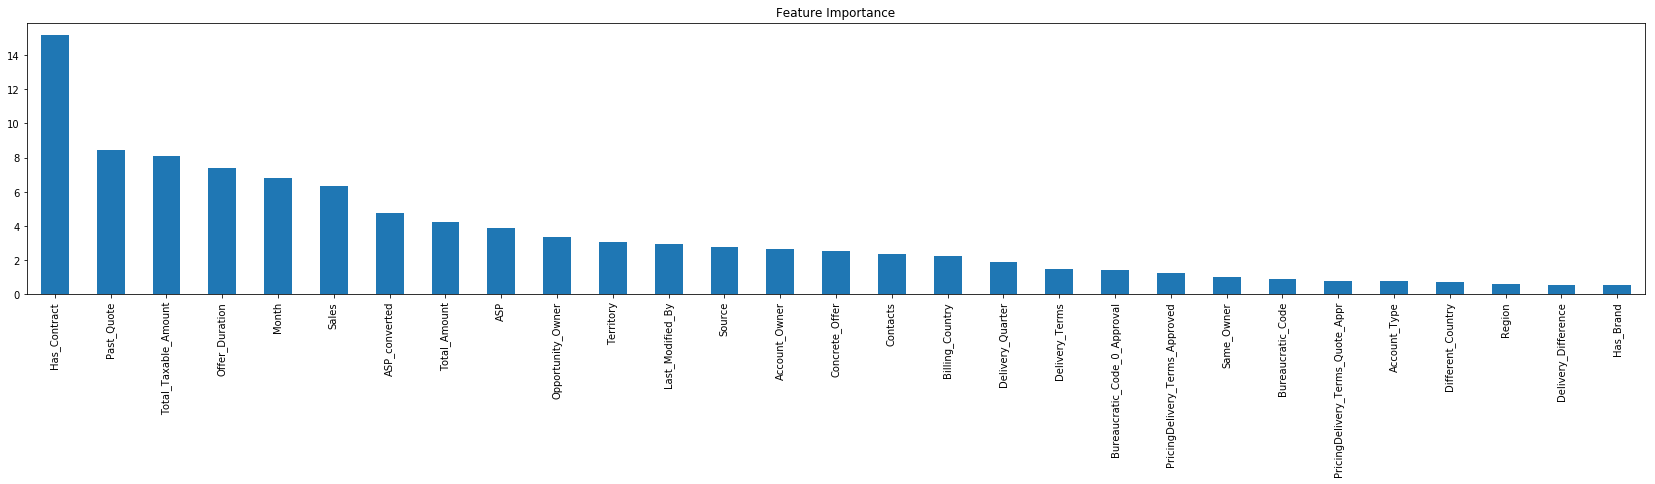

In [77]:
predictors = [x for x in x_test.drop(target, axis = 1).columns]
print len(predictors)
feat_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:29]
plt.rcParams['figure.figsize'] = 29, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

In [78]:
bad = x_test_pred[(x_test_pred.Prediction > 0.5) & (x_test_pred.Stage == 0) | (x_test_pred.Prediction < 0.5) & (x_test_pred.Stage == 1)]

In [79]:
bad.Stage.value_counts()

0.0    61
1.0    23
Name: Stage, dtype: int64

In [80]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)
    
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = model.predict_proba(validation.drop(leak, axis = 1))[:,1]

# agrupo por Opportunity_ID para dar una sola prediccion por solicitud

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
validation = validation.join(pred)

answer = pd.DataFrame(validation.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())

In [81]:
prev = pd.read_csv("acceptable/submission_23.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9882515962532223

In [82]:
prev = pd.read_csv("acceptable/submission_11.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9891850517668207

In [83]:
answer["Opportunity_ID"] = answer["Opportunity_ID"].astype(int)

In [84]:
answer.to_csv("fabri/adab2.csv", header = False, index = False)